In [2]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplleaflet
import json
import requests
import re
%matplotlib inline
import time
import geopandas as gpd
from fastkml import  kml
import geopy.distance # measuring distance
import folium
from IPython.display import IFrame

In [46]:
# read scrapped file

column_names = ['time_scrapped','page','url','property_title','directory','type1','type2','near_mrt','address','listing_time', 'rent_yn',
               'rental_price', 'features', 'amenities', 'rental_dict', 'agent_name', 'agency', 'property_dict', 'description']

mrt_df1 = pd.read_csv("./residential_details2.csv", names = column_names, index_col=False)

mrt_df1.head()




time_scrapped  page  \
0  2019-05-18T22:46:17.962733     2   
1  2019-05-18T22:46:29.958353     1   
2  2019-05-18T22:46:34.879887     2   
3  2019-05-18T22:46:39.208721     3   
4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

   listing_time   rent_yn rental_price  \
0  10 hours ago  For rent   S$2,500/mo   
1  12 hours ago  For rent   S$2,500/mo   
2  10 hours ago  For rent   S$2,500/mo   
3    5 days ago  For rent   S$2,500/mo   
4   3 weeks ago  For rent   S$2,500/mo   

                                            features  \
0  ['2 Beds', '1 Bath', '731 sqft (built up)', 'S...   
1  ['1 Bed', '1 Bath', '690 sqft (built up)', 'S$...   
2  ['2 Beds', '1 Bath', '731 sqft (built up)', 'S...   
3  ['2 Beds', '2 Baths', '730 sqft (built up)', '...   
4  ['2 Beds', '1 Bath', '730 sqft (built up)', 'S...   

                                           amenities  \
0  ['High Floor', 'Bomb Shelter', 'Washer', 'Airc...   
1                  ['Mid Floor', 'Fridge', 'Aircon']   
2  ['High Floor', 'Bomb Shelter', 'Washer', 'Airc...   
3  ['Closet', 'Aircon', 'TV', 'Sofa', 'Stove', 'F...   
4  ['Renovated', 'Closet', 'Sofa', 'Stove', 'Frid...   

                                         rental_dict              agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
1  {'Furnishing': 'Partially Furnished', 'Facing'...        (Edmund Lim B C)   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
3  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...                   Lydia   
4  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...              Peter Quah   

                       agency  \
0      PropNex Realty Pte Ltd   
1      PropNex Realty Pte Ltd   
2      PropNex Realty Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description  
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...  
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...  
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...  
3  2 Bedroom Apartment for Rent Interior Design t...  
4  * nice and renovated unit* high floor* availab...

In [47]:
mrt_df1['property_title'].value_counts().head(10)

Orchard Scotts           127
Altez                    127
The Clift                112
North Park Residences    111
The Sail @ Marina Bay     99
Centro Residences         92
Leonie Condotel           89
The Scotts Tower          88
Pastoral View             82
Marina Bay Residences     78
Name: property_title, dtype: int64

In [48]:
mrt_df2 = mrt_df1.copy()
for i, row in mrt_df1[['property_title']].iterrows():
    mrt_df2.loc[i,'property_title2'] = re.sub(r'[^\w]', ' ', row['property_title'])

mrt_df2.head()

time_scrapped  page  \
0  2019-05-18T22:46:17.962733     2   
1  2019-05-18T22:46:29.958353     1   
2  2019-05-18T22:46:34.879887     2   
3  2019-05-18T22:46:39.208721     3   
4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

   listing_time   rent_yn rental_price  \
0  10 hours ago  For rent   S$2,500/mo   
1  12 hours ago  For rent   S$2,500/mo   
2  10 hours ago  For rent   S$2,500/mo   
3    5 days ago  For rent   S$2,500/mo   
4   3 weeks ago  For rent   S$2,500/mo   

                                            features  \
0  ['2 Beds', '1 Bath', '731 sqft (built up)', 'S...   
1  ['1 Bed', '1 Bath', '690 sqft (built up)', 'S$...   
2  ['2 Beds', '1 Bath', '731 sqft (built up)', 'S...   
3  ['2 Beds', '2 Baths', '730 sqft (built up)', '...   
4  ['2 Beds', '1 Bath', '730 sqft (built up)', 'S...   

                                           amenities  \
0  ['High Floor', 'Bomb Shelter', 'Washer', 'Airc...   
1                  ['Mid Floor', 'Fridge', 'Aircon']   
2  ['High Floor', 'Bomb Shelter', 'Washer', 'Airc...   
3  ['Closet', 'Aircon', 'TV', 'Sofa', 'Stove', 'F...   
4  ['Renovated', 'Closet', 'Sofa', 'Stove', 'Frid...   

                                         rental_dict              agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
1  {'Furnishing': 'Partially Furnished', 'Facing'...        (Edmund Lim B C)   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
3  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...                   Lydia   
4  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...              Peter Quah   

                       agency  \
0      PropNex Realty Pte Ltd   
1      PropNex Realty Pte Ltd   
2      PropNex Realty Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road  
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road  
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road  
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road  
4  * nice and renovated unit* high floor* availab...    1 Beach Road

In [55]:
result.json()['results'][0]['LATITUDE']

{'SEARCHVAL': '1 CANBERRA',
 'BLK_NO': '1',
 'ROAD_NAME': 'CANBERRA DRIVE',
 'BUILDING': '1 CANBERRA',
 'ADDRESS': '1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101',
 'POSTAL': '768101',
 'X': '27661.5872690412',
 'Y': '46598.194169255',
 'LATITUDE': '1.43769199919621',
 'LONGITUDE': '103.830277614211',
 'LONGTITUDE': '103.830277614211'}

### Getting the geo location from the onemap API below. See developers.onemap.sg for more info

In [68]:
mrt_df3 = mrt_df2.copy()
count = 0
for i, row in mrt_df3.iterrows():
    try: 
        search_text = row['property_title2']
        result = requests.get("https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=Y&pageNum=1".format(search_text))
        mrt_df3.loc[i,'ADDRESS'] = result.json()['results'][0]['ADDRESS']
        mrt_df3.loc[i,'ROAD_NAME'] = result.json()['results'][0]['ROAD_NAME']        
        mrt_df3.loc[i,'LATITUDE'] = result.json()['results'][0]['LATITUDE']
        mrt_df3.loc[i,'LONGITUDE'] = result.json()['results'][0]['LONGITUDE']
        print(i, 'ok')
        time.sleep(np.random.normal(1,0.123))
        if i % 10 == 0:
            mrt_df3.to_csv('residential_details2_geoinfo.csv')
            print('saved', count)
            count += 1
    except:
        mrt_df3.loc[i,'ADDRESS'] = 'error'
        mrt_df3.loc[i,'ROAD_NAME'] = 'error'
        mrt_df3.loc[i,'LATITUDE'] = 'error'
        mrt_df3.loc[i,'LONGITUDE'] = 'error'
        print(i, 'error')
        time.sleep(np.random.normal(1,0.123))




0 ok
saved 0
1 ok
2 ok
3 ok
4 ok
5 ok
6 ok
7 ok
8 ok
9 ok
10 ok
saved 1
11 ok
12 ok
13 ok
14 ok
15 ok
16 ok
17 ok
18 ok
19 ok
20 ok
saved 2
21 ok
22 ok
23 ok
24 ok
25 ok
26 ok
27 ok
28 ok
29 ok
30 ok
saved 3
31 ok
32 ok
33 ok
34 ok
35 ok
36 ok
37 ok
38 ok
39 ok
40 ok
saved 4
41 ok
42 ok
43 ok
44 ok
45 ok
46 ok
47 ok
48 ok
49 ok
50 ok
saved 5
51 ok
52 ok
53 ok
54 ok
55 ok
56 ok
57 ok
58 ok
59 ok
60 ok
saved 6
61 ok
62 ok
63 ok
64 ok
65 ok
66 ok
67 ok
68 ok
69 ok
70 ok
saved 7
71 ok
72 ok
73 ok
74 ok
75 ok
76 ok
77 ok
78 ok
79 ok
80 ok
saved 8
81 ok
82 ok
83 ok
84 ok
85 ok
86 ok
87 ok
88 ok
89 ok
90 ok
saved 9
91 ok
92 ok
93 ok
94 ok
95 ok
96 ok
97 ok
98 ok
99 ok
100 ok
saved 10
101 ok
102 ok
103 ok
104 ok
105 ok
106 ok
107 ok
108 ok
109 ok
110 ok
saved 11
111 ok
112 ok
113 ok
114 ok
115 ok
116 ok
117 ok
118 ok
119 ok
120 ok
saved 12
121 ok
122 ok
123 ok
124 ok
125 ok
126 ok
127 ok
128 ok
129 ok
130 ok
saved 13
131 ok
132 ok
133 ok
134 ok
135 ok
136 ok
137 ok
138 ok
139 ok
140 ok
saved 1

1045 ok
1046 ok
1047 ok
1048 ok
1049 ok
1050 ok
saved 105
1051 ok
1052 ok
1053 ok
1054 ok
1055 ok
1056 ok
1057 ok
1058 ok
1059 ok
1060 ok
saved 106
1061 ok
1062 ok
1063 ok
1064 ok
1065 ok
1066 ok
1067 ok
1068 ok
1069 ok
1070 ok
saved 107
1071 ok
1072 ok
1073 ok
1074 ok
1075 ok
1076 ok
1077 ok
1078 ok
1079 ok
1080 ok
saved 108
1081 ok
1082 ok
1083 ok
1084 ok
1085 ok
1086 ok
1087 ok
1088 ok
1089 ok
1090 ok
saved 109
1091 ok
1092 ok
1093 ok
1094 ok
1095 ok
1096 ok
1097 ok
1098 ok
1099 ok
1100 ok
saved 110
1101 ok
1102 ok
1103 ok
1104 ok
1105 ok
1106 ok
1107 ok
1108 ok
1109 ok
1110 ok
saved 111
1111 ok
1112 ok
1113 ok
1114 ok
1115 ok
1116 ok
1117 ok
1118 ok
1119 ok
1120 ok
saved 112
1121 ok
1122 ok
1123 ok
1124 ok
1125 ok
1126 ok
1127 ok
1128 ok
1129 ok
1130 ok
saved 113
1131 ok
1132 ok
1133 ok
1134 ok
1135 ok
1136 ok
1137 ok
1138 ok
1139 ok
1140 ok
saved 114
1141 ok
1142 ok
1143 ok
1144 ok
1145 ok
1146 ok
1147 ok
1148 ok
1149 ok
1150 ok
saved 115
1151 ok
1152 ok
1153 ok
1154 ok
1155 ok
11

1952 ok
1953 ok
1954 ok
1955 ok
1956 ok
1957 ok
1958 ok
1959 ok
1960 ok
saved 193
1961 ok
1962 ok
1963 ok
1964 ok
1965 ok
1966 ok
1967 ok
1968 ok
1969 ok
1970 ok
saved 194
1971 error
1972 ok
1973 ok
1974 ok
1975 ok
1976 ok
1977 ok
1978 ok
1979 ok
1980 ok
saved 195
1981 ok
1982 ok
1983 ok
1984 ok
1985 ok
1986 ok
1987 ok
1988 ok
1989 ok
1990 ok
saved 196
1991 ok
1992 ok
1993 ok
1994 ok
1995 ok
1996 ok
1997 ok
1998 ok
1999 ok
2000 ok
saved 197
2001 ok
2002 ok
2003 ok
2004 ok
2005 ok
2006 ok
2007 ok
2008 ok
2009 ok
2010 ok
saved 198
2011 ok
2012 ok
2013 ok
2014 ok
2015 ok
2016 ok
2017 ok
2018 ok
2019 ok
2020 ok
saved 199
2021 ok
2022 ok
2023 ok
2024 ok
2025 ok
2026 ok
2027 ok
2028 ok
2029 ok
2030 ok
saved 200
2031 ok
2032 ok
2033 ok
2034 ok
2035 ok
2036 ok
2037 ok
2038 ok
2039 ok
2040 ok
saved 201
2041 ok
2042 ok
2043 ok
2044 ok
2045 ok
2046 ok
2047 ok
2048 ok
2049 ok
2050 ok
saved 202
2051 ok
2052 ok
2053 ok
2054 ok
2055 ok
2056 ok
2057 ok
2058 ok
2059 ok
2060 ok
saved 203
2061 ok
2062 ok

2853 error
2854 error
2855 error
2856 error
2857 error
2858 error
2859 error
2860 error
2861 error
2862 error
2863 error
2864 error
2865 error
2866 ok
2867 ok
2868 ok
2869 ok
2870 ok
saved 282
2871 ok
2872 ok
2873 ok
2874 ok
2875 ok
2876 ok
2877 ok
2878 ok
2879 ok
2880 ok
saved 283
2881 ok
2882 ok
2883 ok
2884 ok
2885 ok
2886 ok
2887 ok
2888 ok
2889 ok
2890 ok
saved 284
2891 ok
2892 ok
2893 ok
2894 ok
2895 ok
2896 ok
2897 ok
2898 ok
2899 ok
2900 ok
saved 285
2901 ok
2902 ok
2903 ok
2904 ok
2905 ok
2906 ok
2907 ok
2908 ok
2909 ok
2910 ok
saved 286
2911 ok
2912 ok
2913 ok
2914 ok
2915 ok
2916 ok
2917 ok
2918 ok
2919 ok
2920 ok
saved 287
2921 ok
2922 ok
2923 error
2924 ok
2925 ok
2926 ok
2927 ok
2928 ok
2929 ok
2930 ok
saved 288
2931 ok
2932 ok
2933 ok
2934 ok
2935 ok
2936 ok
2937 ok
2938 ok
2939 ok
2940 ok
saved 289
2941 ok
2942 ok
2943 ok
2944 ok
2945 ok
2946 ok
2947 ok
2948 ok
2949 ok
2950 ok
saved 290
2951 ok
2952 ok
2953 ok
2954 ok
2955 ok
2956 ok
2957 ok
2958 ok
2959 ok
2960 ok
save

3760 ok
saved 371
3761 ok
3762 ok
3763 ok
3764 ok
3765 ok
3766 ok
3767 ok
3768 ok
3769 ok
3770 ok
saved 372
3771 ok
3772 ok
3773 ok
3774 ok
3775 ok
3776 ok
3777 ok
3778 ok
3779 ok
3780 ok
saved 373
3781 ok
3782 ok
3783 ok
3784 ok
3785 ok
3786 ok
3787 ok
3788 ok
3789 ok
3790 ok
saved 374
3791 ok
3792 ok
3793 ok
3794 ok
3795 ok
3796 ok
3797 ok
3798 ok
3799 ok
3800 ok
saved 375
3801 ok
3802 ok
3803 ok
3804 ok
3805 ok
3806 ok
3807 ok
3808 ok
3809 ok
3810 ok
saved 376
3811 ok
3812 ok
3813 ok
3814 ok
3815 ok
3816 ok
3817 ok
3818 ok
3819 ok
3820 ok
saved 377
3821 ok
3822 ok
3823 ok
3824 ok
3825 ok
3826 ok
3827 ok
3828 ok
3829 ok
3830 ok
saved 378
3831 ok
3832 ok
3833 ok
3834 ok
3835 ok
3836 ok
3837 ok
3838 ok
3839 ok
3840 ok
saved 379
3841 ok
3842 ok
3843 ok
3844 ok
3845 ok
3846 ok
3847 ok
3848 ok
3849 ok
3850 ok
saved 380
3851 ok
3852 ok
3853 ok
3854 ok
3855 ok
3856 ok
3857 ok
3858 ok
3859 ok
3860 ok
saved 381
3861 ok
3862 ok
3863 ok
3864 ok
3865 ok
3866 ok
3867 ok
3868 ok
3869 ok
3870 ok
sa

4665 ok
4666 ok
4667 ok
4668 ok
4669 ok
4670 ok
saved 460
4671 ok
4672 ok
4673 ok
4674 ok
4675 ok
4676 ok
4677 ok
4678 ok
4679 ok
4680 ok
saved 461
4681 ok
4682 ok
4683 ok
4684 ok
4685 ok
4686 ok
4687 ok
4688 ok
4689 ok
4690 ok
saved 462
4691 ok
4692 ok
4693 ok
4694 ok
4695 ok
4696 ok
4697 ok
4698 ok
4699 ok
4700 ok
saved 463
4701 ok
4702 ok
4703 ok
4704 ok
4705 ok
4706 ok
4707 ok
4708 ok
4709 ok
4710 ok
saved 464
4711 ok
4712 ok
4713 ok
4714 ok
4715 ok
4716 ok
4717 ok
4718 ok
4719 ok
4720 ok
saved 465
4721 ok
4722 ok
4723 ok
4724 ok
4725 ok
4726 ok
4727 ok
4728 ok
4729 ok
4730 ok
saved 466
4731 ok
4732 ok
4733 ok
4734 ok
4735 ok
4736 ok
4737 ok
4738 ok
4739 ok
4740 ok
saved 467
4741 ok
4742 ok
4743 ok
4744 ok
4745 ok
4746 ok
4747 ok
4748 ok
4749 ok
4750 ok
saved 468
4751 ok
4752 ok
4753 ok
4754 ok
4755 ok
4756 ok
4757 ok
4758 ok
4759 ok
4760 ok
saved 469
4761 ok
4762 ok
4763 ok
4764 ok
4765 ok
4766 ok
4767 ok
4768 ok
4769 ok
4770 ok
saved 470
4771 ok
4772 ok
4773 ok
4774 ok
4775 ok
47

5568 ok
5569 ok
5570 ok
saved 546
5571 ok
5572 ok
5573 ok
5574 ok
5575 ok
5576 ok
5577 ok
5578 ok
5579 ok
5580 ok
saved 547
5581 ok
5582 ok
5583 ok
5584 ok
5585 ok
5586 ok
5587 ok
5588 ok
5589 ok
5590 ok
saved 548
5591 ok
5592 ok
5593 ok
5594 ok
5595 ok
5596 ok
5597 ok
5598 ok
5599 ok
5600 ok
saved 549
5601 ok
5602 ok
5603 ok
5604 ok
5605 ok
5606 ok
5607 ok
5608 ok
5609 ok
5610 ok
saved 550
5611 ok
5612 ok
5613 ok
5614 ok
5615 ok
5616 ok
5617 ok
5618 ok
5619 ok
5620 ok
saved 551
5621 ok
5622 ok
5623 ok
5624 ok
5625 ok
5626 ok
5627 ok
5628 ok
5629 ok
5630 ok
saved 552
5631 ok
5632 ok
5633 ok
5634 ok
5635 ok
5636 ok
5637 ok
5638 ok
5639 ok
5640 ok
saved 553
5641 ok
5642 ok
5643 ok
5644 ok
5645 ok
5646 ok
5647 ok
5648 ok
5649 ok
5650 ok
saved 554
5651 ok
5652 ok
5653 ok
5654 ok
5655 ok
5656 ok
5657 ok
5658 ok
5659 ok
5660 ok
saved 555
5661 ok
5662 ok
5663 ok
5664 ok
5665 ok
5666 ok
5667 ok
5668 ok
5669 ok
5670 ok
saved 556
5671 ok
5672 ok
5673 ok
5674 ok
5675 error
5676 error
5677 ok
5678

6473 ok
6474 ok
6475 ok
6476 ok
6477 ok
6478 ok
6479 ok
6480 ok
saved 635
6481 ok
6482 ok
6483 ok
6484 ok
6485 ok
6486 ok
6487 ok
6488 ok
6489 ok
6490 ok
saved 636
6491 ok
6492 ok
6493 ok
6494 ok
6495 ok
6496 ok
6497 ok
6498 ok
6499 ok
6500 ok
saved 637
6501 ok
6502 ok
6503 ok
6504 ok
6505 ok
6506 ok
6507 ok
6508 ok
6509 ok
6510 ok
saved 638
6511 ok
6512 ok
6513 ok
6514 ok
6515 ok
6516 ok
6517 ok
6518 ok
6519 ok
6520 ok
saved 639
6521 ok
6522 ok
6523 ok
6524 ok
6525 ok
6526 ok
6527 ok
6528 ok
6529 ok
6530 ok
saved 640
6531 ok
6532 ok
6533 ok
6534 ok
6535 ok
6536 ok
6537 ok
6538 ok
6539 ok
6540 ok
saved 641
6541 ok
6542 ok
6543 ok
6544 ok
6545 ok
6546 ok
6547 ok
6548 ok
6549 ok
6550 ok
saved 642
6551 ok
6552 ok
6553 ok
6554 ok
6555 ok
6556 ok
6557 ok
6558 ok
6559 ok
6560 ok
saved 643
6561 ok
6562 ok
6563 ok
6564 ok
6565 ok
6566 ok
6567 ok
6568 ok
6569 ok
6570 ok
saved 644
6571 ok
6572 ok
6573 ok
6574 ok
6575 ok
6576 ok
6577 ok
6578 ok
6579 ok
6580 ok
saved 645
6581 ok
6582 ok
6583 ok
65

saved 724
7381 ok
7382 ok
7383 ok
7384 ok
7385 ok
7386 ok
7387 ok
7388 ok
7389 ok
7390 ok
saved 725
7391 ok
7392 ok
7393 ok
7394 ok
7395 ok
7396 ok
7397 ok
7398 ok
7399 ok
7400 ok
saved 726
7401 ok
7402 ok
7403 ok
7404 ok
7405 ok
7406 ok
7407 ok
7408 ok
7409 ok
7410 ok
saved 727
7411 ok
7412 ok
7413 ok
7414 ok
7415 ok
7416 ok
7417 ok
7418 ok
7419 ok
7420 ok
saved 728
7421 ok
7422 ok
7423 ok
7424 ok
7425 ok
7426 ok
7427 ok
7428 ok
7429 ok
7430 ok
saved 729
7431 ok
7432 ok
7433 ok
7434 ok
7435 ok
7436 ok
7437 ok
7438 ok
7439 ok
7440 ok
saved 730
7441 ok
7442 ok
7443 ok
7444 ok
7445 ok
7446 ok
7447 ok
7448 ok
7449 ok
7450 ok
saved 731
7451 ok
7452 ok
7453 ok
7454 ok
7455 ok
7456 ok
7457 ok
7458 ok
7459 ok
7460 ok
saved 732
7461 ok
7462 ok
7463 ok
7464 ok
7465 ok
7466 ok
7467 ok
7468 ok
7469 ok
7470 ok
saved 733
7471 ok
7472 ok
7473 ok
7474 ok
7475 ok
7476 ok
7477 ok
7478 ok
7479 ok
7480 ok
saved 734
7481 ok
7482 ok
7483 ok
7484 ok
7485 ok
7486 ok
7487 ok
7488 ok
7489 ok
7490 ok
saved 735


8282 ok
8283 ok
8284 ok
8285 ok
8286 ok
8287 ok
8288 ok
8289 ok
8290 ok
saved 810
8291 ok
8292 ok
8293 ok
8294 ok
8295 ok
8296 ok
8297 ok
8298 ok
8299 ok
8300 ok
saved 811
8301 ok
8302 ok
8303 ok
8304 ok
8305 ok
8306 ok
8307 ok
8308 ok
8309 ok
8310 ok
saved 812
8311 ok
8312 ok
8313 ok
8314 ok
8315 ok
8316 ok
8317 ok
8318 ok
8319 ok
8320 ok
saved 813
8321 ok
8322 ok
8323 ok
8324 ok
8325 ok
8326 ok
8327 ok
8328 ok
8329 ok
8330 ok
saved 814
8331 ok
8332 ok
8333 ok
8334 ok
8335 ok
8336 ok
8337 ok
8338 ok
8339 ok
8340 ok
saved 815
8341 ok
8342 ok
8343 ok
8344 ok
8345 ok
8346 ok
8347 ok
8348 ok
8349 ok
8350 ok
saved 816
8351 ok
8352 ok
8353 ok
8354 ok
8355 ok
8356 ok
8357 ok
8358 ok
8359 ok
8360 ok
saved 817
8361 ok
8362 ok
8363 ok
8364 ok
8365 ok
8366 ok
8367 ok
8368 ok
8369 ok
8370 ok
saved 818
8371 ok
8372 ok
8373 ok
8374 ok
8375 ok
8376 ok
8377 ok
8378 ok
8379 ok
8380 ok
saved 819
8381 ok
8382 ok
8383 ok
8384 ok
8385 ok
8386 ok
8387 ok
8388 ok
8389 ok
8390 ok
saved 820
8391 ok
8392 ok
83

In [69]:
# save the final df to a csv file
#mrt_df3.to_csv('residential_details2_geoinfo.csv')

In [5]:
mrt_df3 = pd.read_csv('residential_details2_geoinfo.csv')

In [6]:
mrt_df3.head()

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-18T22:46:17.962733     2   
1           1  2019-05-18T22:46:29.958353     1   
2           2  2019-05-18T22:46:34.879887     2   
3           3  2019-05-18T22:46:39.208721     3   
4           4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

         ...                                               rental_dict  \
0        ...         {'Furnishing': 'Fully Furnished', 'Facing': 'N...   
1        ...         {'Furnishing': 'Partially Furnished', 'Facing'...   
2        ...         {'Furnishing': 'Fully Furnished', 'Facing': 'N...   
3        ...         {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...   
4        ...         {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...   

               agent_name                      agency  \
0  Tiffany Tee - 83334519      PropNex Realty Pte Ltd   
1        (Edmund Lim B C)      PropNex Realty Pte Ltd   
2  Tiffany Tee - 83334519      PropNex Realty Pte Ltd   
3                   Lydia      PropNex Realty Pte Ltd   
4              Peter Quah  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                                            ADDRESS   ROAD_NAME  \
0  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD   
1  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD   
2  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD   
3  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD   
4  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD   

           LATITUDE         LONGITUDE  
0  1.30367135060881  103.864478660925  
1  1.30367135060881  103.864478660925  
2  1.30367135060881  103.864478660925  
3  1.30367135060881  103.864478660925  
4  1.30367135060881  103.864478660925  

[5 rows x 25 columns]

In [7]:
mrt_df3['LATITUDE'] = pd.to_numeric(mrt_df3['LATITUDE'], errors='coerce')
mrt_df3['LONGITUDE'] = pd.to_numeric(mrt_df3['LONGITUDE'], errors='coerce')
print(mrt_df3.isnull().sum())


Unnamed: 0           0
time_scrapped        0
page                 0
url                  0
property_title       0
directory            0
type1                0
type2                0
near_mrt             0
address              0
listing_time         0
rent_yn              0
rental_price         0
features             0
amenities            0
rental_dict          0
agent_name           0
agency               0
property_dict        0
description         85
property_title2      0
ADDRESS              0
ROAD_NAME            0
LATITUDE           212
LONGITUDE          212
dtype: int64


In [198]:
# drop the na
print(mrt_df3.shape)
mrt_df4 = mrt_df3.dropna()
print(mrt_df4.shape)
mrt_df4.head()

(8747, 25)
(8453, 25)


Unnamed: 0               time_scrapped  page  \
0           0  2019-05-18T22:46:17.962733     2   
1           1  2019-05-18T22:46:29.958353     1   
2           2  2019-05-18T22:46:34.879887     2   
3           3  2019-05-18T22:46:39.208721     3   
4           4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

      ...                                            rental_dict  \
0     ...      {'Furnishing': 'Fully Furnished', 'Facing': 'N...   
1     ...      {'Furnishing': 'Partially Furnished', 'Facing'...   
2     ...      {'Furnishing': 'Fully Furnished', 'Facing': 'N...   
3     ...      {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...   
4     ...      {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...   

               agent_name                      agency  \
0  Tiffany Tee - 83334519      PropNex Realty Pte Ltd   
1        (Edmund Lim B C)      PropNex Realty Pte Ltd   
2  Tiffany Tee - 83334519      PropNex Realty Pte Ltd   
3                   Lydia      PropNex Realty Pte Ltd   
4              Peter Quah  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                                            ADDRESS   ROAD_NAME  LATITUDE  \
0  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
1  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
2  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
3  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
4  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   

    LONGITUDE  
0  103.864479  
1  103.864479  
2  103.864479  
3  103.864479  
4  103.864479  

[5 rows x 25 columns]

# LETS PLOT THIS...

In [199]:
fig = plt.figure(figsize=(8,8))
lats = mrt_df4['LATITUDE'][0:1000]
lons = mrt_df4['LONGITUDE'][0:1000]
# plt.scatter(lons, lats, 'r.')
plt.scatter(x=lons, y=lats,alpha=0.5, edgecolors='k')

#And after this call the funtion:

mplleaflet.display(fig=fig)
#It will display the matplotlib object created by plot function

/Users/nicholastay/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# ## TRY THIS. HOW TO PLOT GEO

In [ ]:
# 
https://www.youtube.com/watch?v=SEGFo1w2T78

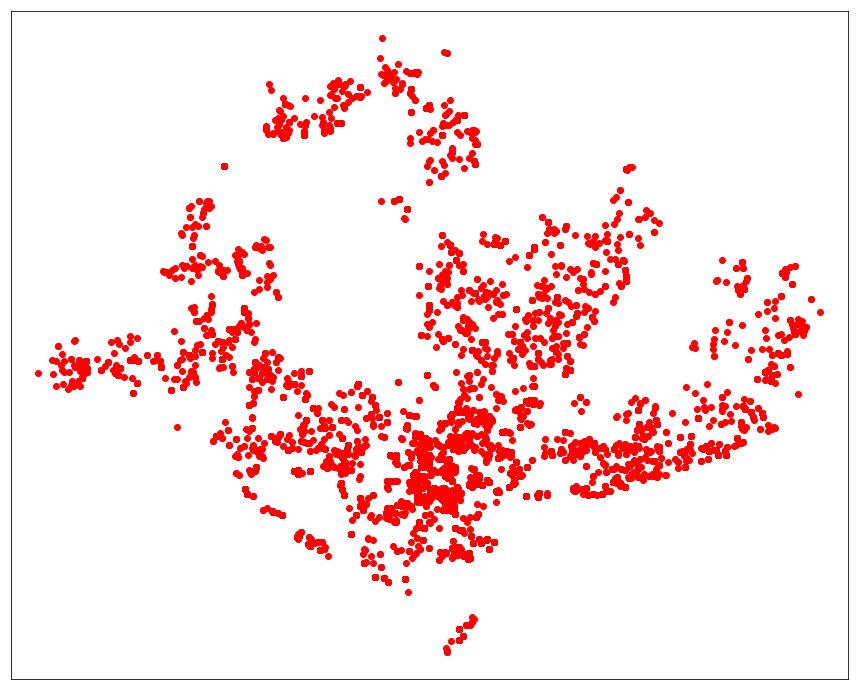

In [200]:
# using basemap because mplleaflet doesn't seem to work

fig = plt.figure(figsize=(15,15))
m.fillcontinents(color = 'white',lake_color='#46bcec')

lat = mrt_df4['LATITUDE'].values
lon = mrt_df4['LONGITUDE'].values

margin = 0.01 # create a margin for the maps

lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            resolution = 'h',
            area_thresh=10000.
          )
m.scatter(lon, lat, marker = 'o', color='r', zorder=500)

In [149]:
m = folium.Map(location=[1.303671, 103.864479],zoom_start=11)
m
# folium python
# plotly


# Trying to find the MRTs lat long


https://jovianlin.io/plotting-data-onto-geological-maps/

if I have the time can explore how to do this... 

In [93]:
mrt_locations = pd.read_csv('./mrt/mrtsg.csv')
print(mrt_locations.shape)
mrt_locations.head()

(188, 8)


OBJECTID                STN_NAME STN_NO           X           Y  Latitude  \
0        12   ADMIRALTY MRT STATION   NS10  24402.1063  46918.1131  1.440585   
1        16    ALJUNIED MRT STATION    EW9  33518.6049  33190.0020  1.316433   
2        17  ANG MO KIO MRT STATION   NS16  29848.9836  39040.9896  1.369347   
3        33  ANG MO KIO MRT STATION   NS16  29807.2655  39105.7720  1.369933   
4        81       BAKAU LRT STATION    SE3  36026.0821  41113.8766  1.388093   

    Longitude   COLOR  
0  103.800998     RED  
1  103.882893   GREEN  
2  103.849928     RED  
3  103.849553     RED  
4  103.905418  OTHERS

In [207]:
lrt_locations = mrt_locations[mrt_locations['STN_NAME'].str.contains("LRT", case=False, na=False)]
mrt_locations2 = mrt_locations[mrt_locations['STN_NAME'].str.contains("MRT", case=False, na=False)]
print(lrt_locations.shape, mrt_locations2.shape)

(43, 8) (145, 8)


In [208]:
for i, row in mrt_df4.iterrows():
    coords_1 = (row['LATITUDE'], row['LONGITUDE'])
    nearest_mrt = []
    nearest_distance = 0
    for ii, mrt in mrt_locations2.iterrows():
        coords_2 = (mrt['Latitude'], mrt['Longitude'])
        if nearest_mrt == []:
            nearest_mrt = mrt['STN_NAME']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("first entry")
        elif geopy.distance.vincenty(coords_1, coords_2).km < nearest_distance:
            nearest_mrt = mrt['STN_NAME']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("found nearer")
    mrt_df4.loc[i,'nearest_mrt'] = nearest_mrt
    mrt_df4.loc[i,'nearest_distance'] = nearest_distance
    print(i, mrt_df4.loc[i,'ADDRESS'], nearest_mrt, nearest_distance)

/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # This is added back by InteractiveShellApp.init_path()
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]


first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
0 1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001 NICOLL HIGHWAY MRT STATION 0.44197034689471393
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1 1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001 NICOLL HIGHWAY MRT STATION 0.44197034689471393
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2 1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001 NICOLL HIGHWAY MRT STATION 0.44197034689471393
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3 1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001 NICOLL HIGHWAY MRT STATION 0.44197034689471393
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4 1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001 NICOLL HIGHWAY MRT STATION 0.4419703468947

47 10 TANGLIN RISE SINGAPORE 247992 REDHILL MRT STATION 1.3579966817988744
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
48 10 TANGLIN RISE SINGAPORE 247992 REDHILL MRT STATION 1.3579966817988744
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
49 10 TANGLIN RISE SINGAPORE 247992 REDHILL MRT STATION 1.3579966817988744
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
50 10 TANGLIN RISE SINGAPORE 247992 REDHILL MRT STATION 1.3579966817988744
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
51 10 TANGLIN RISE SINGAPORE 247992 REDHILL MRT STATION 1.3579966817988744
first entry
found nearer
found nearer
found nearer
found 

found nearer
found nearer
found nearer
91 114 SERANGOON NORTH AVENUE 1 HWI YOH VILLE SINGAPORE 550114 KOVAN MRT STATION 1.787710980363465
first entry
found nearer
found nearer
found nearer
found nearer
92 115 BISHAN STREET 12 BISHAN VIEW SINGAPORE 570115 BISHAN MRT STATION 0.3300104147736112
first entry
found nearer
found nearer
93 115 MARSILING RISE HDB-WOODLANDS SINGAPORE 730115 WOODLANDS MRT STATION 0.6350573924255222
first entry
found nearer
found nearer
found nearer
found nearer
94 116 BUKIT BATOK WEST AVENUE 6 HDB-BUKIT BATOK SINGAPORE 650116 BUKIT BATOK MRT STATION 0.3631186713885159
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
95 116 LORONG 2 TOA PAYOH TOA PAYOH VIEW SINGAPORE 310116 BRADDELL MRT STATION 0.07252548980435858
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
96 116 LORONG 2 TOA PAYOH TOA PAYOH VIEW SINGAPORE 310116 BRADDELL MRT STATION 0.07252548980435858
first entry
found nearer
found nearer
found nearer

142 130A LORONG 1 TOA PAYOH TOA PAYOH CREST SINGAPORE 311130 CALDECOTT MRT STATION 0.40800797330229477
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
143 131 CHOA CHU KANG AVENUE 1 HDB-CHOA CHU KANG SINGAPORE 680131 CHOA CHU KANG MRT STATION 0.8488925002497758
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
144 131C KIM TIAN ROAD KIM TIAN VISTA SINGAPORE 163131 TIONG BAHRU MRT STATION 0.6804848495976292
first entry
found nearer
found nearer
145 134 MARSILING ROAD HDB-WOODLANDS SINGAPORE 730134 MARSILING MRT STATION 0.5859148097541563
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
146 134 WATTEN ESTATE ROAD SINGAPORE 287601 TAN KAH KEE MRT STATION 0.7996141773818775
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
147 134 WATTEN ESTATE ROAD SINGAPORE 287601 TAN KAH KEE MRT STATION 0.7996141773818775
first entry
found nea

found nearer
found nearer
found nearer
found nearer
190 16 TECK WHYE LANE TECK WHYE HEIGHTS III SINGAPORE 680016 BUKIT PANJANG MRT STATION 0.758911907564097
first entry
found nearer
found nearer
found nearer
found nearer
191 16 TECK WHYE LANE TECK WHYE HEIGHTS III SINGAPORE 680016 BUKIT PANJANG MRT STATION 0.758911907564097
first entry
found nearer
found nearer
192 160 BUKIT BATOK STREET 11 HDB-BUKIT BATOK SINGAPORE 650160 BUKIT BATOK MRT STATION 0.8408605994903144
first entry
found nearer
found nearer
193 160 BUKIT BATOK STREET 11 HDB-BUKIT BATOK SINGAPORE 650160 BUKIT BATOK MRT STATION 0.8408605994903144
first entry
found nearer
found nearer
194 160 BUKIT BATOK STREET 11 HDB-BUKIT BATOK SINGAPORE 650160 BUKIT BATOK MRT STATION 0.8408605994903144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
195 161B PUNGGOL CENTRAL HDB-PUNGGOL SINGAPORE 822161 PUNGGOL MRT STATION 1.76850418432866
first entry
found nearer
found nearer
found nearer
found near

240 185A JELEBU ROAD MULTI STOREY CAR PARK SINGAPORE 671185 BUKIT PANJANG MRT STATION 0.11689235358456279
first entry
found nearer
found nearer
found nearer
found nearer
241 187 BUKIT BATOK WEST AVENUE 6 HDB-BUKIT BATOK SINGAPORE 650187 BUKIT BATOK MRT STATION 0.6199251305734269
first entry
found nearer
found nearer
found nearer
242 189 BISHAN STREET 13 HDB-BISHAN SINGAPORE 570189 BISHAN MRT STATION 0.32189217504807416
first entry
found nearer
found nearer
found nearer
243 19 EUNOS CRESCENT EUNOS CRESCENT VIEW SINGAPORE 400019 EUNOS MRT STATION 0.4972528175076881
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
244 19 HOUGANG AVENUE 3 HOUGANG VIEW SINGAPORE 530019 HOUGANG MRT STATION 0.8318653562546061
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
245 1919 SINGAPORE DHOBY GHAUT MRT STATION 0.3618584103974713
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
246 1919 SINGAPORE DHOBY GHAUT MRT STATION 0

291 223 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPORE 560223 ANG MO KIO MRT STATION 1.342687992309628
first entry
found nearer
found nearer
found nearer
292 223 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPORE 560223 ANG MO KIO MRT STATION 1.342687992309628
first entry
found nearer
found nearer
found nearer
found nearer
293 225 BUKIT BATOK CENTRAL HDB-BUKIT BATOK SINGAPORE 650225 BUKIT BATOK MRT STATION 0.34107011516839014
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
294 226C COMPASSVALE WALK COMPASSVALE VISTA SINGAPORE 543226 SENGKANG MRT STATION 0.6333406725160878
first entry
found nearer
found nearer
295 228 YISHUN STREET 21 HDB-YISHUN SINGAPORE 760228 YISHUN MRT STATION 0.7094786336223304
first entry
found nearer
found nearer
found nearer
296 229 BISHAN STREET 23 HDB-BISHAN SINGAPORE 570229 BISHAN MRT STATION 0.7816977611979742
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
297 229 CHOA CHU KANG CENTRAL HDB-CHOA CHU KANG SING

found nearer
found nearer
342 251 KIM KEAT LINK HDB-TOA PAYOH SINGAPORE 310251 TOA PAYOH MRT STATION 1.0661526094015115
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
343 254 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530254 KOVAN MRT STATION 0.7127611143000784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
344 254 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530254 KOVAN MRT STATION 0.7127611143000784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
345 255 KIM KEAT AVENUE HDB-TOA PAYOH SINGAPORE 310255 TOA PAYOH MRT STATION 1.1472578318464053
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
346 258 KIM KEAT AVENUE HDB-TOA PAYOH SINGAPORE 310258 TOA PAYOH MRT STATION 1.1499668793197226
first entry
found nearer
found nearer
found nearer
found nearer
347 259A BUKIT BATOK EAST AVENUE 4 SINGAPORE 651259 BUKIT BATOK MRT STATION 1.1677241737360604


392 282 CHOA CHU KANG AVENUE 3 HDB-CHOA CHU KANG SINGAPORE 680282 CHOA CHU KANG MRT STATION 0.5791199031856425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
393 285 TAMPINES STREET 22 HDB-TAMPINES SINGAPORE 520285 TAMPINES EAST MRT STATION 0.7117023832598658
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
394 285C TOH GUAN ROAD HDB-JURONG EAST SINGAPORE 603285 JURONG EAST MRT STATION 0.708847161286048
first entry
found nearer
found nearer
found nearer
found nearer
395 287 BUKIT BATOK EAST AVENUE 3 HDB-BUKIT BATOK SINGAPORE 650287 BUKIT BATOK MRT STATION 1.016472124073616
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
396 288D JURONG EAST STREET 21 HDB-JURONG EAST SINGAPORE 604288 JURONG EAST MRT STATION 0.7528467465287303
first entry
found nearer
found nearer
found nearer
397 289 YISHUN AVENUE 6 HDB-YISHUN SINGAPORE 760289 YISHUN MRT STATION 1.303716591059042

446 311 JURONG EAST STREET 32 HDB-JURONG EAST SINGAPORE 600311 CHINESE GARDEN MRT STATION 0.5875898655177453
first entry
found nearer
found nearer
found nearer
found nearer
447 311 JURONG EAST STREET 32 HDB-JURONG EAST SINGAPORE 600311 CHINESE GARDEN MRT STATION 0.5875898655177453
first entry
found nearer
found nearer
found nearer
found nearer
448 311C ANCHORVALE LANE ANCHORVALE VISTA SINGAPORE 543311 SENGKANG MRT STATION 1.2275967118737658
first entry
found nearer
449 312 SEMBAWANG DRIVE HDB-SEMBAWANG SINGAPORE 750312 SEMBAWANG MRT STATION 0.5141151851270874
first entry
found nearer
found nearer
found nearer
450 313 BUKIT BATOK STREET 32 HDB-BUKIT BATOK SINGAPORE 650313 BUKIT GOMBAK MRT STATION 0.48855541303063926
first entry
found nearer
found nearer
451 313 WOODLANDS STREET 31 HDB-WOODLANDS SINGAPORE 730313 MARSILING MRT STATION 0.2991291416934269
first entry
found nearer
found nearer
found nearer
found nearer
452 314B ANCHORVALE LINK ANCHORVALE GARDENS SINGAPORE 542314 SENGKANG MRT

501 346 BUKIT BATOK STREET 34 HDB-BUKIT BATOK SINGAPORE 650346 BUKIT GOMBAK MRT STATION 0.4370354319404598
first entry
found nearer
found nearer
found nearer
502 347 UBI AVENUE 1 KAMPONG UBI VIEW SINGAPORE 400347 UBI MRT STATION 0.4782195514357734
first entry
found nearer
found nearer
504 347A YISHUN AVENUE 11 ADORA GREEN SINGAPORE 761347 YISHUN MRT STATION 0.8698741469833358
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
506 349A CLEMENTI AVENUE 2 SINGAPORE 121349 CLEMENTI MRT STATION 0.6885157352665888
first entry
found nearer
found nearer
found nearer
found nearer
507 35A MARINE CRESCENT MULTI STOREY CAR PARK SINGAPORE 441035 KEMBANGAN MRT STATION 1.9082698647343013
first entry
found nearer
found nearer
found nearer
found nearer
508 35A MARINE CRESCENT MULTI STOREY CAR PARK SINGAPORE 441035 KEMBANGAN MRT STATION 1.9082698647343013
first entry
found nearer
found nearer
509 350 WOODLANDS AVENUE 3 HDB-WOODLANDS SINGAPORE 730350 WOODLANDS MRT S

562 389 YISHUN AVENUE 6 HDB-YISHUN SINGAPORE 760389 YISHUN MRT STATION 1.4485512741566975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
563 39 JALAN RUMAH TINGGI RUMAH TINGGI VIEW SINGAPORE 151039 REDHILL MRT STATION 0.7642791459514262
first entry
found nearer
found nearer
564 390 YISHUN AVENUE 6 HDB-YISHUN SINGAPORE 760390 YISHUN MRT STATION 1.4913666734457518
first entry
found nearer
found nearer
found nearer
565 391A BUKIT BATOK WEST AVENUE 5 GOODVIEW GARDENS SINGAPORE 651391 BUKIT GOMBAK MRT STATION 0.7766930979710894
first entry
found nearer
found nearer
found nearer
566 391A BUKIT BATOK WEST AVENUE 5 GOODVIEW GARDENS SINGAPORE 651391 BUKIT GOMBAK MRT STATION 0.7766930979710894
first entry
found nearer
found nearer
found nearer
567 394 BUKIT BATOK WEST AVENUE 5 GOODVIEW GARDENS SINGAPORE 650394 BUKIT GOMBAK MRT STATION 0.8514905065603051
first entry
found nearer
found neare

615 432 CLEMENTI AVENUE 3 HDB-CLEMENTI SINGAPORE 120432 CLEMENTI MRT STATION 0.3047384055260515
first entry
found nearer
found nearer
616 432C YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 763432 KHATIB MRT STATION 1.4647244238997603
first entry
found nearer
found nearer
found nearer
found nearer
617 434 JURONG WEST STREET 42 HDB-JURONG WEST SINGAPORE 640434 LAKESIDE MRT STATION 0.9209992648583661
first entry
found nearer
found nearer
618 435 YISHUN AVENUE 6 HDB-YISHUN SINGAPORE 760435 YISHUN MRT STATION 1.6342714417149973
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
619 435C FERNVALE ROAD FERNVALE RESIDENCE SINGAPORE 793435 SENGKANG MRT STATION 2.075469427108135
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
620 436C FERNVALE ROAD FERNVALE GROVE SINGAPORE 793436 SENGKANG MRT STATION 2.0595269000785836
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
621 438B SENGKANG WEST AVENUE FERNVALE COURT 

found nearer
found nearer
found nearer
found nearer
664 48A STRATHMORE AVENUE FORFAR HEIGHTS SINGAPORE 143048 QUEENSTOWN MRT STATION 0.3165681165912286
first entry
found nearer
found nearer
found nearer
found nearer
665 480 JURONG WEST STREET 41 JURONGVILLE @ STREET 41 SINGAPORE 640480 LAKESIDE MRT STATION 0.4449832822801121
first entry
found nearer
found nearer
found nearer
found nearer
666 481 SEGAR ROAD SEGAR GARDENS SINGAPORE 670481 BUKIT PANJANG MRT STATION 1.6572008481314415
first entry
found nearer
667 481A SEMBAWANG DRIVE MULTI STOREY CAR PARK SINGAPORE 751481 SEMBAWANG MRT STATION 0.6408908543521086
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
668 484A CHOA CHU KANG AVENUE 5 HDB-CHOA CHU KANG SINGAPORE 681484 CHOA CHU KANG MRT STATION 1.2752951465213953
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
669 487A CHOA CHU KANG AVENUE 5 SUNSHINE GARDENS SINGAPORE 681487 CHOA CHU KANG MRT STATION 1.2006573642219511
first e

711 52 STRATHMORE AVENUE FORFAR HEIGHTS SINGAPORE 141052 QUEENSTOWN MRT STATION 0.31368713366341666
first entry
found nearer
found nearer
found nearer
712 520 ANG MO KIO AVENUE 5 HDB-ANG MO KIO SINGAPORE 560520 ANG MO KIO MRT STATION 0.42232360728303847
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
713 520 SERANGOON NORTH AVENUE 4 HDB-SERANGOON NORTH ESTATE SINGAPORE 550520 KOVAN MRT STATION 1.8186386085161572
first entry
found nearer
found nearer
714 520 WOODLANDS DRIVE 14 FRAGRANT WOODS SINGAPORE 730520 WOODLANDS MRT STATION 0.5378586221929778
first entry
found nearer
found nearer
found nearer
715 523 BUKIT BATOK STREET 52 HDB-BUKIT BATOK SINGAPORE 650523 BUKIT GOMBAK MRT STATION 0.2320910066904008
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
716 524 SERANGOON NORTH AVENUE 4 HDB-SERANGOON NORTH ESTATE SINGAPORE 550524 KOVAN MRT STATION 1.9382291008148695
first entry
found nearer
found nearer
found nearer
found nearer
foun

762 583 WOODLANDS DRIVE 16 HDB-WOODLANDS SINGAPORE 730583 WOODLANDS SOUTH MRT STATION 0.38263338627599597
first entry
found nearer
found nearer
763 585 ANG MO KIO AVENUE 3 CHENG SAN COURT SINGAPORE 560585 ANG MO KIO MRT STATION 0.3045840507515738
first entry
found nearer
found nearer
764 585 ANG MO KIO AVENUE 3 CHENG SAN COURT SINGAPORE 560585 ANG MO KIO MRT STATION 0.3045840507515738
first entry
found nearer
found nearer
found nearer
765 585 WOODLANDS DRIVE 16 HDB-WOODLANDS SINGAPORE 730585 WOODLANDS SOUTH MRT STATION 0.2754494911456151
first entry
found nearer
found nearer
766 586 ANG MO KIO AVENUE 3 CHENG SAN COURT SINGAPORE 560586 ANG MO KIO MRT STATION 0.4065686034533003
first entry
found nearer
found nearer
767 587 ANG MO KIO AVENUE 3 CHENG SAN COURT SINGAPORE 560587 ANG MO KIO MRT STATION 0.2934925396075325
first entry
found nearer
768 588A MONTREAL DRIVE MONTREAL SPRING SINGAPORE 751588 SEMBAWANG MRT STATION 0.6479782700020639
first entry
found nearer
769 588A MONTREAL DRIVE MO

813 612 SENJA ROAD HDB-BUKIT PANJANG SINGAPORE 670612 BUKIT PANJANG MRT STATION 0.5579959209363954
first entry
found nearer
found nearer
found nearer
found nearer
814 613A BUKIT PANJANG RING ROAD MULTI STOREY CAR PARK SINGAPORE 671613 BUKIT PANJANG MRT STATION 0.5799521898028581
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
815 614 CHOA CHU KANG STREET 62 HDB-CHOA CHU KANG SINGAPORE 680614 YEW TEE MRT STATION 0.5442629649852012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
816 614 CHOA CHU KANG STREET 62 HDB-CHOA CHU KANG SINGAPORE 680614 YEW TEE MRT STATION 0.5442629649852012
first entry
found nearer
found nearer
817 617 WOODLANDS AVENUE 4 HDB-WOODLANDS SINGAPORE 730617 WOODLANDS SOUTH MRT STATION 0.7628006765694463
first entry
found nearer
found nearer
found nearer
818 618 ANG MO KIO AVENUE 4 HDB-ANG MO KIO SINGAPORE 560618 YIO CHU KANG MRT STATION 0.8364656708293053
first entry
found nearer
found

867 660 YISHUN AVENUE 4 NEE SOON CENTRAL VIEW SINGAPORE 760660 KHATIB MRT STATION 0.8832925294333164
first entry
found nearer
found nearer
869 661D JURONG WEST STREET 64 HDB-JURONG WEST SINGAPORE 644661 BOON LAY MRT STATION 0.2830189270806446
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
870 662 CHOA CHU KANG CRESCENT HDB-CHOA CHU KANG SINGAPORE 680662 YEW TEE MRT STATION 0.5741632082664802
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
871 663 CHOA CHU KANG CRESCENT HDB-CHOA CHU KANG SINGAPORE 680663 YEW TEE MRT STATION 0.6178337201467722
first entry
found nearer
found nearer
found nearer
872 663B JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 642663 PIONEER MRT STATION 0.4761933690815338
first entry
found nearer
found nearer
873 664B JURONG WEST STREET 64 HDB-JURONG WEST SINGAPORE 642664 BOON LAY MRT STATION 0.2811119923682448
first entry
found nearer
found nearer
874 669C JURONG WEST STREET 64 HDB-JURONG WEST SINGAPORE 64

found nearer
found nearer
found nearer
927 7 CLAYMORE ROAD SINGAPORE 229538 ORCHARD MRT STATION 0.5735315751831035
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
928 7 CLAYMORE ROAD SINGAPORE 229538 ORCHARD MRT STATION 0.5735315751831035
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
929 7 CLAYMORE ROAD SINGAPORE 229538 ORCHARD MRT STATION 0.5735315751831035
first entry
found nearer
found nearer
found nearer
found nearer
930 7 MARINE TERRACE MARINE TERRACE WALK SINGAPORE 440007 KEMBANGAN MRT STATION 1.934641741883965
first entry
found nearer
found nearer
931 7 CHAPEL ROAD 7 ON CHAPEL SINGAPORE 429510 EUNOS MRT STATION 1.5320841789123618
first entry
found nearer
found nearer
932 7 CHAPEL ROAD 7 ON CHAPEL SINGAPORE 429510 EUNOS MRT STATION 1.5320841789123618
first entry
found nearer
found nearer
933 7 CHAPEL ROAD 7 ON CHAPEL SINGAPORE 429510 EUNOS MRT 

981 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
982 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
983 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
984 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
985 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
986 76 SHENTON WAY 7

1023 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1024 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1025 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1026 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1027 76 SHENTON WAY 76 SHENTON SINGAPORE 079119 TANJONG PAGAR MRT STATION 0.33925813825724344
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1028 76 SHENTON

1073 8 MOUNT SOPHIA 8 @ MOUNT SOPHIA SINGAPORE 228463 DHOBY GHAUT MRT STATION 0.1488120289392837
first entry
found nearer
found nearer
found nearer
found nearer
1074 8 WOODLEIGH CLOSE 8@WOODLEIGH SINGAPORE 357903 WOODLEIGH MRT STATION 0.3293468008776087
first entry
found nearer
found nearer
found nearer
found nearer
1075 8 WOODLEIGH CLOSE 8@WOODLEIGH SINGAPORE 357903 WOODLEIGH MRT STATION 0.3293468008776087
first entry
found nearer
found nearer
found nearer
found nearer
1076 8 WOODLEIGH CLOSE 8@WOODLEIGH SINGAPORE 357903 WOODLEIGH MRT STATION 0.3293468008776087
first entry
found nearer
found nearer
found nearer
found nearer
1077 8 WOODLEIGH CLOSE 8@WOODLEIGH SINGAPORE 357903 WOODLEIGH MRT STATION 0.3293468008776087
first entry
found nearer
1078 802A WOODLANDS STREET 81 HDB-WOODLANDS SINGAPORE 731802 WOODLANDS MRT STATION 0.47217414644603534
first entry
found nearer
1079 802 YISHUN RING ROAD KHATIB GARDENS SINGAPORE 760802 KHATIB MRT STATION 0.18616488951604326
first entry
found nearer


found nearer
found nearer
1118 897A TAMPINES STREET 81 TAMPINES POLYVIEW SINGAPORE 521897 TAMPINES WEST MRT STATION 0.4221267828278229
first entry
1119 899B WOODLANDS DRIVE 50 HDB-WOODLANDS SINGAPORE 731899 ADMIRALTY MRT STATION 0.8058965392018673
first entry
found nearer
found nearer
found nearer
1120 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
found nearer
1121 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
found nearer
1122 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
found nearer
1123 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1124 90 TANGLIN HALT ROAD COMMONWEALTH VIEW SINGAPORE 141090 COMMONWEALTH MRT STATION 0.22492883704308803
first entry
found nearer


1171 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1172 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1173 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1174 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1175 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1176 ALBA SINGAPORE NEWTON MRT STATION 0.5715683157948076
first entry
found nearer
found nearer
found nearer
found nearer
found ne

1218 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1219 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1220 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1221 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1222 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1223 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1224 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.271525212641096

1271 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1272 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1273 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1274 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1275 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1276 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1277 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.271525212641096

found nearer
found nearer
1325 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1326 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1327 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1328 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1329 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1330 ALTEZ SINGAPORE TANJONG PAGAR MRT STATION 0.2715252126410968
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1331 ALTEZ SINGAPORE TANJONG PAGAR MRT

1392 15 ARDMORE PARK ARDMORE PARK SINGAPORE 259959 ORCHARD MRT STATION 0.7882937453163846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1393 15 ARDMORE PARK ARDMORE PARK SINGAPORE 259959 ORCHARD MRT STATION 0.7882937453163846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1394 15 ARDMORE PARK ARDMORE PARK SINGAPORE 259959 ORCHARD MRT STATION 0.7882937453163846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1395 15 ARDMORE PARK ARDMORE PARK SINGAPORE 259959 ORCHARD MRT STATION 0.7882937453163846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1396 ARDMORE RESIDENCE SINGAPORE ORCHARD MRT STATION 0.7876605375297576
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1397 ARDMORE RESIDENCE SINGAPORE ORCHARD MRT STATION 

1439 ASCENTIA SKY SINGAPORE REDHILL MRT STATION 0.14407839223437854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1440 ASCENTIA SKY SINGAPORE REDHILL MRT STATION 0.14407839223437854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1441 ASCENTIA SKY SINGAPORE REDHILL MRT STATION 0.14407839223437854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1442 ASCENTIA SKY SINGAPORE REDHILL MRT STATION 0.14407839223437854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1443 ASCENTIA SKY SINGAPORE REDHILL MRT STATION 0.14407839223437854
first entry
found nearer
found nearer
14

1494 BALMORAL TOWER SINGAPORE NEWTON MRT STATION 0.5761860935494004
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1495 BANYAN CONDOMINIUM SINGAPORE PASIR PANJANG MRT STATION 0.40578030292273043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1496 BANYAN CONDOMINIUM SINGAPORE PASIR PANJANG MRT STATION 0.40578030292273043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1497 BANYAN CONDOMINIUM SINGAPORE PASIR PANJANG MRT STATION 0.40578030292273043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1498 BANYAN CONDOMINIUM SINGAPORE PASIR PANJANG MRT STATION 0.40578030292273043
first entry
found nearer
found nearer
found 

1544 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1545 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1546 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1547 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1548 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1549 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1550 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1551 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1552 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.5761327929797608
first entry
found nearer
found nearer
1553 BAYSHORE PARK SINGAPORE BEDOK MRT STATION 1.576132792979760

1607 BELMOND GREEN SINGAPORE NEWTON MRT STATION 0.719738997980105
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1608 BELMONT ROAD HOLLAND VILLAGE MRT STATION 0.7254198414611885
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1609 BELMONT ROAD HOLLAND VILLAGE MRT STATION 0.7254198414611885
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1610 BELMONT ROAD HOLLAND VILLAGE MRT STATION 0.7254198414611885
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1611 BELMONT ROAD HOLLAND VILLAGE MRT STATION 0.7254198414611885
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1612 BELMONT ROAD HOLLAND VIL

1646 BIJOU SINGAPORE PASIR PANJANG MRT STATION 0.0815346758598724
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1647 BIJOU SINGAPORE PASIR PANJANG MRT STATION 0.0815346758598724
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1648 BIJOU SINGAPORE PASIR PANJANG MRT STATION 0.0815346758598724
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1649 BIJOU SINGAPORE PASIR PANJANG MRT STATION 0.0815346758598724
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1650 BIJOU SINGAPORE PASIR PANJANG MRT STATION 0.0815346758598724
first entry
found nearer
found nearer
found nearer

1695 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1696 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1697 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1698 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1699 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1700 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1701 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found nearer
found nearer
1702 BISHAN 8 SINGAPORE BISHAN MRT STATION 0.19745493837297454
first entry
found nearer
found nearer
found near

1760 BOONVIEW SINGAPORE MARYMOUNT MRT STATION 0.37211974834660555
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1761 BOONVIEW SINGAPORE MARYMOUNT MRT STATION 0.37211974834660555
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1762 BOTANIC GARDENS MANSION SINGAPORE ORCHARD MRT STATION 1.4728972004133003
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1763 BOTANIC GARDENS MANSION SINGAPORE ORCHARD MRT STATION 1.4728972004133003
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1764 BOTANIC GARDENS MANSION SINGAPORE ORCHARD MRT STATION 1.4728972004133003
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1765 BOTANIC GARDENS MANSION SINGAPORE ORCHARD MRT STATION 1.4728972004133003
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1766 BOTANIC GARDENS VIEW SINGAPORE STEVENS MRT STATION 1.46692851222382
first en

1821 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1823 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1824 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1826 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1827 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1828 BUKIT TIMAH ROAD STEVENS MRT STATION 0.35723228701181736
first entry
found nearer
found nearer
found nearer
1829 MONT TIMAH SINGAPORE BEAUTY WORLD MRT STATION 0.600151189

1871 CAIRNHILL RESIDENCES SINGAPORE NEWTON MRT STATION 0.4971176425051217
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1872 CAIRNHILL RESIDENCES SINGAPORE NEWTON MRT STATION 0.4971176425051217
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1873 28 CAIRNHILL ROAD EMERALD HILL CONSERVATION AREA SINGAPORE 229656 SOMERSET MRT STATION 0.36469779134463876
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1874 28 CAIRNHILL ROAD EMERALD HILL CONSERVATION AREA SINGAPORE 229656 SOMERSET MRT STATION 0.36469779134463876
first entry
found nearer
found nearer
found nearer
found nearer
1875 CALARASI SINGAPORE BOON KENG MRT STATION 0.9474193452157316
first entry
found nearer
found nearer
found nearer
found nearer
1876 CALARASI SINGAPORE BOON KENG MRT STATION 0.9474193452157316
first entry
found nearer
found nearer
found near

found nearer
found nearer
1929 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1930 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1931 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1932 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1933 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1934 CARISSA PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.0483972676635582
first entry
found nearer

1989 CASPIAN SINGAPORE LAKESIDE MRT STATION 0.3603796197358293
first entry
found nearer
found nearer
found nearer
1990 CASPIAN SINGAPORE LAKESIDE MRT STATION 0.3603796197358293
first entry
found nearer
found nearer
found nearer
1991 CASPIAN SINGAPORE LAKESIDE MRT STATION 0.3603796197358293
first entry
found nearer
found nearer
found nearer
1992 CASPIAN SINGAPORE LAKESIDE MRT STATION 0.3603796197358293
first entry
found nearer
found nearer
found nearer
1993 CASSIA VIEW SINGAPORE OUTRAM PARK MRT STATION 0.36834094941741147
first entry
found nearer
found nearer
found nearer
1994 CASSIA VIEW SINGAPORE OUTRAM PARK MRT STATION 0.36834094941741147
first entry
found nearer
found nearer
found nearer
1995 CASTLE GREEN SINGAPORE YIO CHU KANG MRT STATION 0.6437091599672777
first entry
found nearer
found nearer
found nearer
found nearer
1996 CASTLE LOFT SINGAPORE KEMBANGAN MRT STATION 0.8009175497214874
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found 

2038 WOODGROVE ESTATE SINGAPORE MARSILING MRT STATION 0.6194773788310548
first entry
found nearer
found nearer
2039 CEDARWOOD GROVE MARSILING MRT STATION 0.6021295780362812
first entry
found nearer
found nearer
2040 CENTRA LOFT SINGAPORE PAYA LEBAR MRT STATION 0.5117472251761662
first entry
found nearer
found nearer
2041 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
found nearer
2042 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
found nearer
2043 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
found nearer
2044 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
found nearer
2045 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
found nearer
2046 CENTRA RESIDENCE SINGAPORE KALLANG MRT STATION 0.5285690079330103
first entry
found nearer
2048 38 LORONG 25A GEYLANG CENTRA SUITES 

2105 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2106 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2107 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2108 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2109 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2110 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2111 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found nearer
found nearer
2112 CENTRO RESIDENCES SINGAPORE ANG MO KIO MRT STATION 0.14373655960514742
first entry
found nearer
found near

2163 CHANCERY GROVE SINGAPORE NOVENA MRT STATION 0.7777741901975992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2164 CHANCERY GROVE SINGAPORE NOVENA MRT STATION 0.7777741901975992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2165 CHANCERY GROVE SINGAPORE NOVENA MRT STATION 0.7777741901975992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2166 CHANCERY GROVE SINGAPORE NOVENA MRT STATION 0.7777741901975992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2167 CHANCERY GROVE SINGAPORE NOVENA MRT STATION 0.7777741901975992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2168 CHANCERY G

2207 CHANGI ROAD KEMBANGAN MRT STATION 0.4996559037343282
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2208 CHANGI ROAD KEMBANGAN MRT STATION 0.4996559037343282
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2209 CHANGI ROAD KEMBANGAN MRT STATION 0.4996559037343282
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2210 CHANGI ROAD KEMBANGAN MRT STATION 0.4996559037343282
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2211 CHANGI ROAD KEMBANGAN MRT STATION 0.4996559037343282
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2212 CHANTILLY RISE SINGAPORE HILLVIEW MRT STATION 0.5884957111311656
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2213 CHANTILLY RISE SINGAPORE HILLVIEW MRT STATION 0.5884957111311656
first entry
found nearer
found nearer
2214 CHAPEL ROAD E

found nearer
found nearer
2259 371 BEACH ROAD CITY GATE SINGAPORE 199597 NICOLL HIGHWAY MRT STATION 0.31670079815671337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2260 371 BEACH ROAD CITY GATE SINGAPORE 199597 NICOLL HIGHWAY MRT STATION 0.31670079815671337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2261 371 BEACH ROAD CITY GATE SINGAPORE 199597 NICOLL HIGHWAY MRT STATION 0.31670079815671337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2262 371 BEACH ROAD CITY GATE SINGAPORE 199597 NICOLL HIGHWAY MRT STATION 0.31670079815671337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2263 371 BEACH ROAD CITY GATE SINGAPORE 199597 NICOLL HIGHWAY MRT STATION 0.31670079815671337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
fo

2307 CITY STUDIOS SINGAPORE FARRER PARK MRT STATION 0.2881590917801825
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2308 CITY STUDIOS SINGAPORE FARRER PARK MRT STATION 0.2881590917801825
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2309 69 TAMPINES CENTRAL 7 CITYLIFE@TAMPINES SINGAPORE 528599 TAMPINES MRT STATION 0.5780222729741916
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2310 69 TAMPINES CENTRAL 7 CITYLIFE@TAMPINES SINGAPORE 528599 TAMPINES MRT STATION 0.5780222729741916
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2311 69 TAMPINES CENTRAL 7 CITYLIFE@TAMPINES SINGAPORE 528599 TAMPINES MRT STATION 0.5780222729741916
first entry
found nearer
found nearer
found nearer
found nearer
2312 CITYLI

2364 CLIVEDEN AT GRANGE SINGAPORE ORCHARD MRT STATION 0.8011728507986132
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2365 CLIVEDEN AT GRANGE SINGAPORE ORCHARD MRT STATION 0.8011728507986132
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2366 CLIVEDEN AT GRANGE SINGAPORE ORCHARD MRT STATION 0.8011728507986132
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2367 CLIVEDEN AT GRANGE SINGAPORE ORCHARD MRT STATION 0.8011728507986132
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2368 CLIVEDEN AT GRANGE SINGAPORE ORCHARD MRT STATION 0.8011728507986132
first entry
found nearer
found nearer
found nearer
found nearer
fou

2409 COMMONWEALTH TOWERS SINGAPORE QUEENSTOWN MRT STATION 0.0854220887868504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2410 COMMONWEALTH TOWERS SINGAPORE QUEENSTOWN MRT STATION 0.0854220887868504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2411 COMMONWEALTH TOWERS SINGAPORE QUEENSTOWN MRT STATION 0.0854220887868504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2412 COMMONWEALTH TOWERS SINGAPORE QUEENSTOWN MRT STATION 0.0854220887868504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2413 COMMONWEALTH TOWERS SINGAPORE QUEENSTOWN MRT STATION 0.0854220887868504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nea

2460 CORONATION ROAD WEST SIXTH AVENUE MRT STATION 1.035913032677326
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2461 CORONATION ROAD WEST SIXTH AVENUE MRT STATION 1.035913032677326
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2462 CORONATION ROAD WEST SIXTH AVENUE MRT STATION 1.035913032677326
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2463 CORONATION ROAD WEST SIXTH AVENUE MRT STATION 1.035913032677326
first entry
found nearer
found nearer
found nearer
2464 LAKESIDE GROVE SINGAPORE LAKESIDE MRT STATION 0.512693675942759
first entry
found nearer
found nearer
found nearer
2465 LAKESIDE GROVE SINGAPORE LAKESIDE MRT STATION 0.512693675942759
first entry
found nearer
found nearer
found nearer
2466 LAKESIDE GROVE SINGAPORE LAKESIDE MRT STA

found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2527 CUBE 8 SINGAPORE TOA PAYOH MRT STATION 0.8151422057374756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2528 CUBE 8 SINGAPORE TOA PAYOH MRT STATION 0.8151422057374756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2530 CUBE 8 SINGAPORE TOA PAYOH MRT STATION 0.8151422057374756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2531 CUBE 8 SINGAPORE TOA PAYOH MRT STATION 0.8151422057374756
first entry
found nearer
found neare

found nearer
found nearer
2578 CYAN SINGAPORE STEVENS MRT STATION 0.5264477637873612
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2579 CYAN SINGAPORE STEVENS MRT STATION 0.5264477637873612
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2580 CYAN SINGAPORE STEVENS MRT STATION 0.5264477637873612
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2581 CYAN SINGAPORE STEVENS MRT STATION 0.5264477637873612
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2582 CYAN SINGAPORE STEVENS MRT STATION 0.5264477637873612
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2583 DAHLIA PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.2751131652027798
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
258

2628 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2629 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2630 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2631 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2632 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer

2681 DOVER PARKVIEW SINGAPORE BUONA VISTA MRT STATION 0.7227738406837564
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2682 DOVER PARKVIEW SINGAPORE BUONA VISTA MRT STATION 0.7227738406837564
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2683 DOVER PARKVIEW SINGAPORE BUONA VISTA MRT STATION 0.7227738406837564
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2684 DOVER PARKVIEW SINGAPORE BUONA VISTA MRT STATION 0.7227738406837564
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2685 8 DRAYCOTT PARK DRAYCOTT EIGHT SINGAPORE 259404 NEWTON MRT STATION 0.6660855012081772
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2686 DUBLIN ROAD SOMERSET MRT STATION 0.20788201164681575
first entry
found nearer
found nearer
found nearer
found nearer
found 

2754 EASTERN LAGOON SINGAPORE BEDOK MRT STATION 1.2860690317778265
first entry
found nearer
found nearer
2755 EASTERN LAGOON SINGAPORE BEDOK MRT STATION 1.2860690317778265
first entry
found nearer
found nearer
2756 EASTERN LAGOON SINGAPORE BEDOK MRT STATION 1.2860690317778265
first entry
found nearer
found nearer
2757 EASTERN LAGOON SINGAPORE BEDOK MRT STATION 1.2860690317778265
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2758 EASTPOINT GREEN SINGAPORE SIMEI MRT STATION 0.5375113187648461
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2759 EASTPOINT GREEN SINGAPORE SIMEI MRT STATION 0.5375113187648461
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2760 EASTPOINT GREEN SINGAPORE SIMEI MRT STATION 0.5375113187648461
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2761 EASTPOINT GREEN SINGAPORE SIMEI MRT STATION 0.537

2806 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2807 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2808 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2809 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2810 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2811 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2812 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer
2813 EIGHT RIVERSUITES SINGAPORE BOON KENG MRT STATION 0.4102405719675543
first entry
found nearer
found nearer
found nearer


2877 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 0.29429064576601455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2878 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 0.29429064576601455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2879 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 0.29429064576601455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2880 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 0.29429064576601455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2881 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 0.29429064576601455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2882 70 SHENTON WAY EON SHENTON SINGAPORE 079118 TANJONG PAGAR MRT STATION 

2929 89 KAMPONG BAHRU ROAD BLAIR PLAIN CONSERVATION AREA SINGAPORE 169382 OUTRAM PARK MRT STATION 0.6083850403448849
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2930 89 KAMPONG BAHRU ROAD BLAIR PLAIN CONSERVATION AREA SINGAPORE 169382 OUTRAM PARK MRT STATION 0.6083850403448849
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2931 3B EWART PARK EWART PARK SINGAPORE 279735 KING ALBERT PARK MRT STATION 1.0974519792896549
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2932 EWE BOON REGENT SINGAPORE STEVENS MRT STATION 0.6336468150376351
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2933 EWE BOON REGENT SINGAPORE STEVENS MRT STATION 0.6336468150376351
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2934 FABER HILLS SINGAPORE CLEMENTI MRT STATION 1.0077443789733451
first entry
found nearer
found nearer
found nearer
fo

2988 FRAGRANCE COURT SINGAPORE PASIR PANJANG MRT STATION 0.2285179058143379
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2989 FRAGRANCE COURT SINGAPORE PASIR PANJANG MRT STATION 0.2285179058143379
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2990 2 MOUNT ELIZABETH LINK FRASER RESIDENCE SINGAPORE SINGAPORE 227973 ORCHARD MRT STATION 0.5447319563355788
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2991 2 MOUNT ELIZABETH LINK FRASER RESIDENCE SINGAPORE SINGAPORE 227973 ORCHARD MRT STATION 0.5447319563355788
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2992 2 MOUNT ELIZABETH LINK FRASER RESIDENCE SINGAPORE SINGAPORE 227973 ORCHARD MRT STATION 0.5447319563355788

3040 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STATION 0.28671068643483083
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3041 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STATION 0.28671068643483083
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3042 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STATION 0.28671068643483083
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3043 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STATION 0.28671068643483083
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3044 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STATION 0.28671068643483083
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3045 GLOUCESTER MANSIONS SINGAPORE NEWTON MRT STAT

3090 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3091 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3092 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3093 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3094 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nea

3131 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3132 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3133 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3134 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3135 GRANGE 70 SINGAPORE ORCHARD MRT STATION 0.6285000689555852
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nea

3174 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3175 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3176 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3177 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3178 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3179 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3180 GREENWOOD M

3227 GUILIN MANSIONS SINGAPORE PAYA LEBAR MRT STATION 0.3047699691801818
first entry
found nearer
found nearer
found nearer
3228 GUILIN VIEW SINGAPORE BUKIT GOMBAK MRT STATION 0.37939642236625254
first entry
found nearer
found nearer
found nearer
3229 GUILIN VIEW SINGAPORE BUKIT GOMBAK MRT STATION 0.37939642236625254
first entry
found nearer
found nearer
found nearer
3230 GUILIN VIEW SINGAPORE BUKIT GOMBAK MRT STATION 0.37939642236625254
first entry
found nearer
found nearer
found nearer
3231 GUILIN VIEW SINGAPORE BUKIT GOMBAK MRT STATION 0.37939642236625254
first entry
found nearer
found nearer
3232 GUILLEMARD EDGE SINGAPORE OUTRAM PARK MRT STATION 0.5000969972403979
first entry
found nearer
found nearer
3233 GUILLEMARD EDGE SINGAPORE OUTRAM PARK MRT STATION 0.5000969972403979
first entry
found nearer
found nearer
3234 GUILLEMARD EDGE SINGAPORE OUTRAM PARK MRT STATION 0.5000969972403979
first entry
found nearer
found nearer
3235 GUILLEMARD EDGE SINGAPORE OUTRAM PARK MRT STATION 0.5000

3291 HARBOURLIGHTS SINGAPORE HARBOURFRONT MRT STATION 0.183059327294807
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3292 HARBOURLIGHTS SINGAPORE HARBOURFRONT MRT STATION 0.183059327294807
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3293 HARBOURLIGHTS SINGAPORE HARBOURFRONT MRT STATION 0.183059327294807
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3294 HARMONY @ 1A SINGAPORE KOVAN MRT STATION 0.49074168915230626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3295 HARVEY AVENUE SIMEI MRT STATION 0.4715116591976019
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3296 2 HAVELOCK ROAD HAVELOCK2 SINGAPORE 059763 CLARKE QUAY MRT STATION 0.20705907336295937
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3297 HEDGES PARK 

3344 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3345 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3346 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3347 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3348 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3349 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3350 HIGH PARK RESIDENCES SINGAPORE SENGKANG MRT STATION 2.352977444827082
first entry
f

3395 HIGHLINE RESIDENCES SINGAPORE TIONG BAHRU MRT STATION 0.3435229992595264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3396 HIGHLINE RESIDENCES SINGAPORE TIONG BAHRU MRT STATION 0.3435229992595264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3397 HIGHLINE RESIDENCES SINGAPORE TIONG BAHRU MRT STATION 0.3435229992595264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3398 HILLBROOKS SINGAPORE HILLVIEW MRT STATION 0.7038416169994105
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3399 HILLBROOKS SINGAPORE HILLVIEW MRT STATION 0.7038416169994105
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3400 HILLCREST ARCADIA SINGAPORE TAN KAH KEE MRT STATION 1.0030753974811606
first entry
found nearer
found nearer
found nearer
found nearer
found

3447 HOLLAND 100 SINGAPORE HOLLAND VILLAGE MRT STATION 0.6514226603899745
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3448 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24334466519570735
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3449 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24334466519570735
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3450 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24334466519570735
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3451 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24334466519570735
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3452 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24334466519570735
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3453 HOLLAND GROVE SINGAPORE DOVER MRT STATION 0.24

3495 MCMAHON PARK SINGAPORE BUONA VISTA MRT STATION 0.9672889503011197
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3496 HOLLAND ROAD HOLLAND VILLAGE MRT STATION 0.6011730339713338
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3497 HOLLAND ROAD HOLLAND VILLAGE MRT STATION 0.6011730339713338
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3498 MCMAHON PARK SINGAPORE BUONA VISTA MRT STATION 0.9672889503011197
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3499 HOLLAND ROAD HOLLAND VILLAGE MRT STATION 0.6011730339713338
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3500 HOLLYWOOD APARTMENTS SINGAPORE DHOBY GHAUT MRT STATION 0.43751068267607524
first entry
found nearer
found nearer
found nearer
found nearer
foun

3536 HORIZON RESIDENCES SINGAPORE HAW PAR VILLA MRT STATION 0.2667282983883537
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3537 HORIZON RESIDENCES SINGAPORE HAW PAR VILLA MRT STATION 0.2667282983883537
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3538 HORIZON RESIDENCES SINGAPORE HAW PAR VILLA MRT STATION 0.2667282983883537
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3539 HORIZON RESIDENCES SINGAPORE HAW PAR VILLA MRT STATION 0.2667282983883537
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3540 HORIZON TOWERS SINGAPORE ORCHARD MRT STATION 0.6774224132381494
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nea

found nearer
found nearer
3588 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3589 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3590 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3591 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3592 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3593 ICON SINGAPORE TANJONG PAGAR MRT STATION 0.21477507775809443
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3594 ICON SINGAPORE TANJONG PAGAR MRT 

3635 ISLAND VIEW SINGAPORE PASIR PANJANG MRT STATION 0.4079516825809922
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3636 ISUITES @ TANI SINGAPORE KOVAN MRT STATION 0.6281494531062806
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3637 ISUITES @ TANI SINGAPORE KOVAN MRT STATION 0.6281494531062806
first entry
found nearer
found nearer
3638 IVORY SINGAPORE EUNOS MRT STATION 0.9800116557187856
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3639 IVORY HEIGHTS SINGAPORE JURONG EAST MRT STATION 0.566030825012775
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3640 IVORY HEIGHTS SINGAPORE JURONG EAST MRT STATION 0.566030825012775
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3641 IVORY HEIGHTS SINGAPORE JURONG EAST MRT STATION 0.566030825012

3689 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
found nearer
found nearer
3690 MING PARK SINGAPORE BISHAN MRT STATION 0.35434866439488955
first entry
found nearer
found nearer
3691 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
3692 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3693 THOMSON GARDEN ESTATE SINGAPORE MARYMOUNT MRT STATION 0.582649243709568
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3694 JALAN CHEMPAKA KUNING TANAH MERAH MRT STATION 0.489250818929094
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3695 JALAN CHEMPAKA KUNING TANAH MERAH MRT STATION 0.489250818929094
first entry
found nearer
found nearer
found nearer
3696 SEMBAWANG HILLS ESTATE SINGAPORE YIO CHU KANG MRT STATION 1.8364546810652

found nearer
3746 SELETAR HILLS ESTATE SINGAPORE YIO CHU KANG MRT STATION 2.5788007728347715
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3747 JALAN SAMPURNA HOLLAND VILLAGE MRT STATION 0.6856354546130281
first entry
found nearer
3748 SEMBAWANG STRAITS ESTATE SINGAPORE SEMBAWANG MRT STATION 2.1390022042396
first entry
found nearer
found nearer
found nearer
3749 SEA VIEW PARK SINGAPORE OUTRAM PARK MRT STATION 1.1959217729285978
first entry
found nearer
found nearer
found nearer
found nearer
3750 KIMNAN PARK SINGAPORE KEMBANGAN MRT STATION 0.37466365297642706
first entry
found nearer
found nearer
3751 JALAN SEMPADAN BEDOK MRT STATION 1.3353409110410404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3752 JALAN SENYUM KEMBANGAN MRT STATION 0.24499326069022348
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3753 JALAN SENYUM KEMBANGAN MRT STATION 0.24499326069022

3804 JERVOIS MANSIONS SINGAPORE TIONG BAHRU MRT STATION 0.8147056535453665
first entry
found nearer
found nearer
found nearer
found nearer
3805 JEWEL @ BUANGKOK SINGAPORE BUANGKOK MRT STATION 0.25219565763299734
first entry
found nearer
found nearer
found nearer
found nearer
3806 JEWEL @ BUANGKOK SINGAPORE BUANGKOK MRT STATION 0.25219565763299734
first entry
found nearer
found nearer
found nearer
found nearer
3807 JEWEL @ BUANGKOK SINGAPORE BUANGKOK MRT STATION 0.25219565763299734
first entry
found nearer
found nearer
found nearer
found nearer
3808 JEWEL @ BUANGKOK SINGAPORE BUANGKOK MRT STATION 0.25219565763299734
first entry
found nearer
found nearer
found nearer
found nearer
3809 JEWEL @ BUANGKOK SINGAPORE BUANGKOK MRT STATION 0.25219565763299734
first entry
found nearer
found nearer
found nearer
found nearer
3810 JI XIANG COURT SINGAPORE KEMBANGAN MRT STATION 0.8658721266620434
first entry
found nearer
found nearer
found nearer
3811 JING SUITES SINGAPORE EUNOS MRT STATION 0.4033897

3862 KENSINGTON PARK CONDOMINIUM SINGAPORE LORONG CHUAN MRT STATION 1.871942277157048
first entry
found nearer
found nearer
found nearer
found nearer
3863 KENSINGTON PARK CONDOMINIUM SINGAPORE LORONG CHUAN MRT STATION 1.871942277157048
first entry
found nearer
found nearer
3864 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
3865 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
3866 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
found nearer
found nearer
3867 KERRISDALE SINGAPORE FARRER PARK MRT STATION 0.42727846074968934
first entry
found nearer
found nearer
found nearer
found nearer
3868 KERRISDALE SINGAPORE FARRER PARK MRT STATION 0.42727846074968934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3869 DUNEARN ESTATE SINGAPORE STEVENS MRT STATION 0.66472144551

3918 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3919 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3920 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3921 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3922 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3923 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3924 KINGSFORD WATERBAY SINGAPORE HOUGANG MRT STATION 1.2687661588324626
first entry
found nearer
fo

3990 LAGUNA GREEN SINGAPORE BEDOK MRT STATION 1.3216978182005439
first entry
found nearer
found nearer
3991 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
3992 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
3993 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
found nearer
found nearer
3994 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
3995 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
3996 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
3997 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
3998 LAKE GRANDE SINGAPORE LAKESIDE M

4053 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4054 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4055 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4056 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4057 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4058 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
4059 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
4060 LAKEHOLMZ SINGAPORE LAKESIDE MRT STATION 0.5267403996479669
first entry
found nearer

4111 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4112 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4113 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4114 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4115 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4116 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4117 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4118 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
found nearer
found nearer
4119 BAN

4156 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4157 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4158 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4159 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4160 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer


found nearer
found nearer
found nearer
found nearer
found nearer
4196 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4197 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4198 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4199 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4200 LEONIE CONDOTEL SINGAPORE SOMERSET MRT STATION 0.6632385005929824
first entry


found nearer
4244 1 LIANG SEAH STREET LIANG SEAH PLACE SINGAPORE 189022 BUGIS MRT STATION 0.19047560727600207
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4245 1 LIANG SEAH STREET LIANG SEAH PLACE SINGAPORE 189022 BUGIS MRT STATION 0.19047560727600207
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4246 1 LIANG SEAH STREET LIANG SEAH PLACE SINGAPORE 189022 BUGIS MRT STATION 0.19047560727600207
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4247 1 LIANG SEAH STREET LIANG SEAH PLACE SINGAPORE 189022 BUGIS MRT STATION 0.19047560727600207
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4248 33 LIANG SEAH STREET BEACH ROAD CONSERVATION AREA SINGAPORE 189054 BUGIS MRT STATION 0.17006514553677904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4249 LIANG SEAH STREET BUGIS MRT STATION 0.17506240856174118
first entry
found nearer
found nearer
found

4302 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4303 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4304 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4305 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4306 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4307 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4308 LLOYD SIXTYFIVE SINGAPORE SOM

found nearer
4353 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4354 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4355 151 HOLLAND ROAD LOFT@HOLLAND SINGAPORE 278580 HOLLAND VILLAGE MRT STATION 0.12249732574515901
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4356 LOFT @ NATHAN SINGAPORE TIONG BAHRU MRT STATION 0.9161884295764254
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4357 LOFT @ NATHAN SINGAPORE TIONG BAHRU MRT STATION 0.9161884295764254
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4358 LOF

4410 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4411 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4412 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4413 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4414 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4415 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.19890128963771525
first entry
found nearer
found nearer
found nearer
found nearer
4416 LOTUS AT PAYA LEBAR (EAST WING) SINGAPORE PAYA LEBAR MRT STATION 0.1989

found nearer
found nearer
found nearer
4464 LOTUS AT PAYA LEBAR (WEST WING) SINGAPORE PAYA LEBAR MRT STATION 0.22987206828499296
first entry
found nearer
found nearer
4465 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4466 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4467 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4468 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4469 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4470 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4471 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118
first entry
found nearer
found nearer
4472 LOTUS AT JOO CHIAT SINGAPORE EUNOS MRT STATION 0.6498581101005118

4524 MANDARIN GARDENS SINGAPORE BEDOK MRT STATION 1.9545379988869656
first entry
found nearer
found nearer
4525 MANDARIN GARDENS SINGAPORE BEDOK MRT STATION 1.9545379988869656
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4527 MAR THOMA MANSIONS SINGAPORE POTONG PASIR MRT STATION 0.7555582088991489
first entry
found nearer
found nearer
4528 MARGATE TERRACE SINGAPORE MOUNTBATTEN MRT STATION 1.125929922003076
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4529 ADELPHI PARK ESTATE SINGAPORE MARYMOUNT MRT STATION 1.3871728421780318
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4530 301 UPPER THOMSON ROAD THOMSON PLAZA SINGAPORE 574408 MARYMOUNT MRT STATION 1.1531445580312836
first entry
found nearer
found nearer
found nearer
4531 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4532 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MR

4590 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4591 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4592 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4593 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4594 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4595 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4596 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found nearer
found nearer
found nearer
4597 MARINA BAY RESIDENCES SINGAPORE DOWNTOWN MRT STATION 0.24156228809136238
first entry
found n

4652 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
4653 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
4654 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
4655 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
4656 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
4657 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
4658 MARINE PARADE EUNOS MRT STATION 1.8784621863927315
first entry
found nearer
found nearer
4659 MARINE VILLE SINGAPORE EUNOS MRT STATION 1.7190466450326174
fir

4711 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4712 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4713 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4714 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4715 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4716 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4717 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
4718 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576


4760 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4761 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4762 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4763 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4764 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4765 MERAPRIME SINGAPORE TIONG BAHRU MRT STATION 0.1307297938427012
first entry


4814 MOUNT PLEASANT DRIVE BUKIT BROWN MRT STATION 0.43125602186893847
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4815 MOUNT PLEASANT DRIVE BUKIT BROWN MRT STATION 0.43125602186893847
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4816 MOUNT PLEASANT ROAD STEVENS MRT STATION 0.6295840559361955
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4817 MOUNT PLEASANT ROAD STEVENS MRT STATION 0.6295840559361955
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4818 MOUNT PLEASANT ROAD STEVENS MRT STATION 0.6295840559361955
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4819 MOUNT PLEASANT ROAD STEVENS MRT STATION 0.6295840559361955
first entry
found nearer

4867 NASSIM REGENCY SINGAPORE STEVENS MRT STATION 1.1889828255772357
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4868 NASSIM REGENCY SINGAPORE STEVENS MRT STATION 1.1889828255772357
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4869 NASSIM REGENCY SINGAPORE STEVENS MRT STATION 1.1889828255772357
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4870 NASSIM REGENCY SINGAPORE STEVENS MRT STATION 1.1889828255772357
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4871 NASSIM REGENCY SINGAPORE STEVENS MRT STATION 1.1889828255772357
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4874 NATHAN RESIDENCES SINGAPORE TIONG BAHRU MRT STATION 0.9447643249309366
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4875 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STA

4933 NIVEN ROAD LITTLE INDIA MRT STATION 0.3345722612215836
first entry
found nearer
found nearer
found nearer
found nearer
4934 NIVEN ROAD LITTLE INDIA MRT STATION 0.3345722612215836
first entry
found nearer
found nearer
found nearer
found nearer
4935 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145
first entry
found nearer
found nearer
found nearer
found nearer
4936 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145
first entry
found nearer
found nearer
found nearer
found nearer
4937 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145
first entry
found nearer
found nearer
found nearer
found nearer
4938 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145
first entry
found nearer
found nearer
found nearer
found nearer
4939 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145
first entry
found nearer
found nearer
found nearer
found nearer
4940 NIVEN SUITES SINGAPORE LITTLE INDIA MRT STATION 0.4134661306660145


5004 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5005 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5006 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5007 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5008 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5009 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5010 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5011 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry
found nearer
found nearer
5012 NORTH PARK RESIDENCES SINGAPORE YISHUN MRT STATION 0.21353593297931944
first entry


5078 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5079 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5080 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5081 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5082 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5083 NOUVEL 18 SINGAPORE ORCHARD MRT STATION 0.8993903472287913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found neare

5128 NOVENA COURT SINGAPORE NOVENA MRT STATION 0.30422750719015734
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5129 NOVENA HILL SINGAPORE NOVENA MRT STATION 0.37250667754933836
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5130 NOVENA SUITES SINGAPORE NOVENA MRT STATION 0.19957982017895787
first entry
found nearer
found nearer
found nearer
5131 NUOVO SINGAPORE YIO CHU KANG MRT STATION 0.45604667328811455
first entry
found nearer
found nearer
found nearer
5132 NUOVO SINGAPORE YIO CHU KANG MRT STATION 0.45604667328811455
first entry
found nearer
found nearer
found nearer
5133 NUOVO SINGAPORE YIO CHU KANG MRT STATION 0.45604667328811455
first entry
found nearer
found nearer
found nearer
5134 NUOVO SINGAPORE YIO CHU KANG MRT STATION 0.45604667328811455
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5135 NV R

5189 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STATION 0.7325854607495595
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5190 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STATION 0.7325854607495595
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5191 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STATION 0.7325854607495595
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5192 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STATION 0.7325854607495595
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5193 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STATION 0.7325854607495595
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5194 ONE DUSUN RESIDENCES SINGAPORE NOVENA MRT STA

5266 ONE TREE HILL RESIDENCE SINGAPORE ORCHARD MRT STATION 0.9059539898693129
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5267 ONE TREE HILL RESIDENCE SINGAPORE ORCHARD MRT STATION 0.9059539898693129
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5268 ONE TREE HILL RESIDENCE SINGAPORE ORCHARD MRT STATION 0.9059539898693129
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5269 ONE TREE HILL RESIDENCE SINGAPORE ORCHARD MRT STATION 0.9059539898693129
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5270 ONE TREE HILL RESIDENCE SINGAPORE ORCHARD MRT STATION 0.9059539898693129
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
foun

found nearer
found nearer
found nearer
5319 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5320 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5321 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5322 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5323 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5324 ORANGE REGENCY SINGAPORE STEVENS MRT STATION 0.9146241585822579
first entry
found nearer
found n

5366 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5367 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5368 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5369 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5370 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5371 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found 

5413 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5414 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5415 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5416 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5417 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5418 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found 

5461 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5462 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5463 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5464 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5465 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5466 ORCHARD SCOTTS SINGAPORE NEWTON MRT STATION 0.288644732104756
first entry
found 

found nearer
found nearer
found nearer
5512 OXLEY NEO RESIDENCES SINGAPORE SOMERSET MRT STATION 0.36337946877187877
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5513 VILLA MADELEINE SINGAPORE SOMERSET MRT STATION 0.27786347752219914
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5514 OXLEY ROAD SOMERSET MRT STATION 0.2869265614537907
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5515 VILLA MADELEINE SINGAPORE SOMERSET MRT STATION 0.27786347752219914
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5516 VILLA MADELEINE SINGAPORE SOMERSET MRT STATION 0.27786347752219914
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5517 OXLEY ROAD SOMERSET MRT STATION 0.2869265614537907
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5518 OXLEY ROAD 

found nearer
found nearer
5566 PARC ELEGANCE SINGAPORE KEMBANGAN MRT STATION 0.5778677617367828
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5567 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5568 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5569 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5570 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5571 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
5572 

5618 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5619 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5620 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5621 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5622 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5623 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5624 PARC ROSEWOOD SINGAPORE WOODLANDS SOUTH MRT STATION 0.8956029125484979
first entry
found nearer
found nearer
found nearer
found nearer
5625 PARC ROSEWOOD S

found nearer
5677 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5678 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5679 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5680 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5681 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5682 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5683 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5684 PARKWAY VIEW SINGAPORE OUTRAM PARK MRT STATION 1.8288605551928319
first entry
found nearer
found nearer
found nearer
5685 PARKWA

5723 PASIR VIEW PARK SINGAPORE PASIR PANJANG MRT STATION 0.521766352557268
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5724 PASIR VIEW PARK SINGAPORE PASIR PANJANG MRT STATION 0.521766352557268
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5725 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5726 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5727 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5728 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
fou

5775 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5776 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5777 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5778 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5779 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5780 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.5349337092209118
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5781 PASTORAL VIEW SINGAPORE NOVENA MRT STATION 0.53493370

5832 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CHINATOWN MRT STATION 0.2752575412864146
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5833 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CHINATOWN MRT STATION 0.2752575412864146
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5834 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CHINATOWN MRT STATION 0.2752575412864146
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5835 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CHINATOWN MRT STATION 0.2752575412864146
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5836 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CHINATOWN MRT STATION 0.2752575412864146
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5837 201 PEARL'S HILL TERRACE YO:HA @ PEARL'S HILL SINGAPORE 168977 CH

5882 POLLEN & BLEU SINGAPORE FARRER ROAD MRT STATION 0.3898874011260993
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5883 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5884 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5885 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5886 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5887 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5888 WHITESHORES SINGAPORE PUNGGOL MRT STATION 1.1912949432081992
first entry
found nearer
found nearer
found nearer
found nearer
found 

5934 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.6499618677776882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5935 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.6499618677776882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5936 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.6499618677776882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5937 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.6499618677776882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5938 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.6499618677776882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5939 PRINCIPAL GARDEN SINGAPORE REDHILL MRT STATION 0.64996186777

5979 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
5981 CHARLTON PARK SINGAPORE KOVAN MRT STATION 0.6517305628406798
first entry
found nearer
found nearer
found nearer
5982 PAVILION PARK SINGAPORE BUKIT GOMBAK MRT STATION 1.1528805839279126
first entry
found nearer
found nearer
found nearer
5983 BUKIT VILLAS SINGAPORE KRANJI MRT STATION 1.142037928382047
first entry
found nearer
found nearer
found nearer
5984 MELODY VILLAS SINGAPORE YIO CHU KANG MRT STATION 1.0938425209946478
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5985 9C BRIZAY PARK BRIZAY PARK SINGAPORE 279956 KING ALBERT PARK MRT STATION 0.513511285992123
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5986 CHIP BEE GARDENS SINGAPORE HOLLAND VILLAGE MRT STATION 0.2473973096276089
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found

6039 TOWNERVILLE SINGAPORE BOON KENG MRT STATION 0.42365491673619576
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6040 BRIGHTON CREST SINGAPORE LORONG CHUAN MRT STATION 1.1457306597385124
first entry
found nearer
found nearer
found nearer
6041 HAMPSTEAD SINGAPORE BEAUTY WORLD MRT STATION 1.5349493209071614
first entry
found nearer
found nearer
found nearer
6042 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
found nearer
6043 BEDOK GROVE SINGAPORE TANAH MERAH MRT STATION 0.7904449015882198
first entry
found nearer
found nearer
found nearer
6044 98 CHENG SOON GARDEN CHENG SOON GARDEN SINGAPORE 599867 BEAUTY WORLD MRT STATION 0.668945608933837
first entry
found nearer
found nearer
found nearer
6045 BUKIT VILLAS SINGAPORE KRANJI MRT STATION 1.142037928382047
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6046 EMERALD HILL CONSERVATION AREA

6099 84 PAGODA STREET KRETA AYER CONSERVATION AREA SINGAPORE 059243 CHINATOWN MRT STATION 0.049213405102473226
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6100 BEDOK RIA SINGAPORE TANAH MERAH MRT STATION 0.7076685337779836
first entry
found nearer
found nearer
found nearer
6101 BUKIT VILLAS SINGAPORE KRANJI MRT STATION 1.142037928382047
first entry
found nearer
6102 25 LORONG 33 GEYLANG PU TIAN BUILDING SINGAPORE 387985 ALJUNIED MRT STATION 0.5321218400417005
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6103 Q BAY RESIDENCES SINGAPORE TAMPINES WEST MRT STATION 1.3726896205928212
first entry
found nearer
found nearer
found nearer
found nearer
6104 QUBE SUITES SINGAPORE KAKI BUKIT MRT STATION 0.5646135654652596
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6105 6A QUEEN ASTRID PARK QUEEN ASTRID PARK SINGAPORE 266797 HOLLAND VILLAGE MRT STATIO

6149 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6150 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6151 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6152 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6153 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found neare

6188 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6189 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6190 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6191 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6192 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found neare

found nearer
found nearer
found nearer
6238 RICHMOND PARK SINGAPORE ORCHARD MRT STATION 0.4740588404002586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6239 RICHMOND PARK SINGAPORE ORCHARD MRT STATION 0.4740588404002586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6240 RICHMOND PARK SINGAPORE ORCHARD MRT STATION 0.4740588404002586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6241 RICHMOND PARK SINGAPORE ORCHARD MRT STATION 0.4740588404002586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6242 RICHMOND PARK SINGAPORE ORCHARD MRT STATION 0.4740588404002586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6243 RICHMOND PARK SINGAPORE ORCHARD MRT 

6287 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6288 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6289 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6290 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6291 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6292 RIVER PLACE SINGAPORE FORT CANNING MRT STATION 0.4776953682251504
first entry
found nearer
found nearer
found nearer
found ne

6336 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6337 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6338 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6339 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6340 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6341 RIVERSIDE 48 SINGAPORE FORT CANNING MRT STATION 0.5307536739770262
first entry
found nearer
found nearer
found nearer
fo

6389 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6390 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6391 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6392 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6393 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6394 ROBERTSON 100 SINGAPORE FORT CANNING MRT STATION 0.7386120473501737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6395 ROBERTSON 100 SIN

6440 ROYAL PALM MANSIONS SINGAPORE KENT RIDGE MRT STATION 0.85715165296149
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6441 ROYAL PALM MANSIONS SINGAPORE KENT RIDGE MRT STATION 0.85715165296149
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6442 ROYAL PALM MANSIONS SINGAPORE KENT RIDGE MRT STATION 0.85715165296149
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6443 ROYAL PALM MANSIONS SINGAPORE KENT RIDGE MRT STATION 0.85715165296149
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6444 ROYAL PALM MANSIONS SINGAPORE KENT RIDGE MRT STATION 0.85715165296149
first entry
found nearer
found nearer
found nearer
found 

6479 ROYCE RESIDENCES SINGAPORE KALLANG MRT STATION 0.5474770550580305
first entry
found nearer
found nearer
6480 ROYCE RESIDENCES SINGAPORE KALLANG MRT STATION 0.5474770550580305
first entry
found nearer
found nearer
6481 ROYCE RESIDENCES SINGAPORE KALLANG MRT STATION 0.5474770550580305
first entry
found nearer
found nearer
6483 ROYCE RESIDENCES SINGAPORE KALLANG MRT STATION 0.5474770550580305
first entry
found nearer
found nearer
6484 ROYCE RESIDENCES SINGAPORE KALLANG MRT STATION 0.5474770550580305
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6486 RV EDGE SINGAPORE TIONG BAHRU MRT STATION 0.9682063114374889
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6487 RV EDGE SINGAPORE TIONG BAHRU MRT STATION 0.9682063114374889
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6488 RV EDGE 

found nearer
found nearer
found nearer
found nearer
found nearer
6529 SANCTUARY GREEN SINGAPORE STADIUM MRT STATION 0.9044179949570638
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6530 SANCTUARY GREEN SINGAPORE STADIUM MRT STATION 0.9044179949570638
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6531 SANCTUARY GREEN SINGAPORE STADIUM MRT STATION 0.9044179949570638
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6532 22 SANDY ISLAND SANDY ISLAND SINGAPORE 098254 HARBOURFRONT MRT STATION 3.23873419264913
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6533 SANT RITZ SINGAPORE POTONG PASIR MRT STATION 0.16634950627765144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6534 SANT RITZ SINGAPORE POTONG PASIR MRT STATION 0.16634950627765144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6535

found nearer
found nearer
found nearer
6578 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6579 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6580 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6581 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6582 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6583 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATI

6631 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6632 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6633 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6634 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6635 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6636 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6637 SEAHILL SINGAPORE CLEMENTI MRT STATION 1.7767315756074404
first entry
found n

6691 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6692 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6693 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6694 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6695 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6696 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6697 SERENITY PARK SINGAPORE YIO CHU KANG MRT STATION 1.7786533485555105
first entry
found nearer
found nearer
found nearer
found nearer
6698 SERENITY PARK SINGAPORE YIO CHU KANG

6756 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6757 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6758 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6759 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6760 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6761 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6762 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6763 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION 1.8507686860013428
first entry
found nearer
found nearer
found nearer
6764 SILVERSEA SINGAPORE OUTRAM PARK MRT STATION

6821 SKIES MILTONIA SINGAPORE KHATIB MRT STATION 1.653659965088696
first entry
found nearer
found nearer
found nearer
6822 SKIES MILTONIA SINGAPORE KHATIB MRT STATION 1.653659965088696
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6824 SKY GREEN SINGAPORE TAI SENG MRT STATION 0.3662345516377061
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6825 SKY GREEN SINGAPORE TAI SENG MRT STATION 0.3662345516377061
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6826 SKY GREEN SINGAPORE TAI SENG MRT STATION 0.3662345516377061
first entry
found nearer
found nearer
found nearer
6827 SKY HABITAT SINGAPORE BISHAN MRT STATION 0.31548341718193607
first entry
found nearer
found nearer
found nearer
6828 SKY HABITAT SINGAPORE BISHAN MRT STATION 0.31548341718193607
first entry
found nearer
found nearer
found nearer
6829 SKY HABITAT SINGAPORE BISHAN MRT STATION 0.31548341718193607

6871 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6872 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6873 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6874 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6875 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6876 SKYLI

6910 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6911 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6912 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6913 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6914 SKYLINE

found nearer
found nearer
found nearer
found nearer
6967 SOMMERVILLE LOFT SINGAPORE WOODLEIGH MRT STATION 0.50710545358122
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6968 SOMMERVILLE LOFT SINGAPORE WOODLEIGH MRT STATION 0.50710545358122
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6969 SOMMERVILLE PARK SINGAPORE FARRER ROAD MRT STATION 0.5770326973739897
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6970 SOMMERVILLE PARK SINGAPORE FARRER ROAD MRT STATION 0.5770326973739897
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6971 SOMMERVILLE PARK SINGAPORE FARRER ROAD MRT STATION 0.5770326973739897
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6972 SOMMERVILLE PARK SINGAPORE FARRER ROAD MRT STATION 0.5770326973739897
firs

7024 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7025 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7026 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7027 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7028 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7029 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.5671307491188372
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7030 SPOTTISWOODE RESIDENCES SINGAPORE OUTRAM 

7083 SAINT THOMAS SUITES SINGAPORE SOMERSET MRT STATION 0.4167869841411836
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7084 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7085 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7086 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7087 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7088 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7089 STARFIRE @ SOPHIA SINGAPORE DHOBY GHAUT MRT STATION 0.34077446300581554
f

7134 SUITES 123 SINGAPORE FARRER PARK MRT STATION 0.3172032695913181
first entry
found nearer
7135 SUITES 28 SINGAPORE ALJUNIED MRT STATION 0.5360942518671377
first entry
found nearer
7136 SUITES 28 SINGAPORE ALJUNIED MRT STATION 0.5360942518671377
first entry
found nearer
found nearer
found nearer
7137 SUITES AT BUKIT TIMAH SINGAPORE BEAUTY WORLD MRT STATION 0.2531275711001233
first entry
found nearer
found nearer
found nearer
7138 SUITES AT BUKIT TIMAH SINGAPORE BEAUTY WORLD MRT STATION 0.2531275711001233
first entry
found nearer
found nearer
found nearer
7139 SUITES AT BUKIT TIMAH SINGAPORE BEAUTY WORLD MRT STATION 0.2531275711001233
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7140 SUITES AT ORCHARD SINGAPORE DHOBY GHAUT MRT STATION 0.0975697196044387
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7141 SUITES AT ORCHARD SINGAPORE DHOBY GHAUT MRT STATION 0.0975697196044387
first entry
found nearer
found nearer
found neare

7187 SUITES @ NEWTON SINGAPORE NOVENA MRT STATION 0.5068524680637704
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7188 SUITES @ NEWTON SINGAPORE NOVENA MRT STATION 0.5068524680637704
first entry
found nearer
found nearer
found nearer
7189 SUITES @ PAYA LEBAR SINGAPORE SERANGOON MRT STATION 0.7268115268326634
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7190 SUITES @ SHREWSBURY SINGAPORE NOVENA MRT STATION 0.6165077014658495
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7191 SUITES @ SHREWSBURY SINGAPORE NOVENA MRT STATION 0.6165077014658495
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7192 SUITES @ SHREWSBURY SINGAPORE NOVENA MRT STATION 0.6165077014658495
first entry
found nearer
7193 SUITES @ SIMS SINGAPORE ALJUNIED MRT STATION 0.48388663461350784
first entry
found near

7246 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7247 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7248 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7249 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
7250 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7251 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7252 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
7253 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
7255 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first

7316 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7317 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7318 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7319 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7320 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7321 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7322 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7323 SUNSHINE PLAZA SINGAPORE BENCOOLEN MRT STATION 0.17853980310685366
first entry
found nearer
found nearer
found nearer
7324 SUNSHINE PL

7376 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7377 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7378 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7379 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7380 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7381 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7382 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
7383 SYMPHONY SUITES SINGAPORE YISHUN MRT STATION 1.2173781237011527
first entry
found nearer
found nearer
found nearer
found nearer
7384 TAI HWAN PARK SINGAPORE LORONG CHUAN MRT STATION 0.6170669669006265
first entry
found nearer
found nearer
found n

7426 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7427 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7428 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7429 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7430 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7431 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7432 TERRASSE SINGAPORE KOVAN MRT STATION 1.2181202964795028
first entry
found nearer
found ne

7478 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7479 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7480 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7481 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7482 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7483 THE BALMORAL SPRING SINGAPORE NEWTON MRT STATION 0.4442753174237176
first entry
found nearer
found nearer
found nea

7549 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7550 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7551 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7552 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7553 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7554 180 BENCOOLEN STREET THE BENCOOLEN SINGAPORE 189646 LITTLE INDIA MRT STATION 0.2703101130868793
first ent

found nearer
7599 THE BLOSSOMVALE SINGAPORE KING ALBERT PARK MRT STATION 0.2365173223885033
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7600 THE BOUTIQ SINGAPORE SOMERSET MRT STATION 0.40068384180782163
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7601 THE BOUTIQ SINGAPORE SOMERSET MRT STATION 0.40068384180782163
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7602 THE BOUTIQ SINGAPORE SOMERSET MRT STATION 0.40068384180782163
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7603 THE BOUTIQ SINGAPORE SOMERSET MRT STATION 0.40068384180782163
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7604 THE BOUTIQ SINGAPORE SOMERSET MRT STATION 0.40068384180

7649 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7650 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7651 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7652 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7653 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7654 THE CAIRNHILL SINGAPORE NEWTON MRT STATION 0.6577705919997904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found 

7734 THE CENTREN SINGAPORE ALJUNIED MRT STATION 0.28658033300404395
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7735 176 ORCHARD ROAD THE CENTREPOINT SINGAPORE 238843 SOMERSET MRT STATION 0.20470029712518742
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7736 176 ORCHARD ROAD THE CENTREPOINT SINGAPORE 238843 SOMERSET MRT STATION 0.20470029712518742
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7737 176 ORCHARD ROAD THE CENTREPOINT SINGAPORE 238843 SOMERSET MRT STATION 0.20470029712518742
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7738 176 ORCHARD ROAD THE CENTREPOINT SINGAPORE 238843 SOMERSET MRT STATION 0.20470029712518742
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7739 176 ORCHARD ROAD THE CENTREPOINT SINGAPORE 238843 SOMERSET MRT STATION 0.20470029712518742
fi

7786 THE CLEMENT CANOPY SINGAPORE CLEMENTI MRT STATION 0.959787678615633
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7787 THE CLEMENT CANOPY SINGAPORE CLEMENTI MRT STATION 0.959787678615633
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7788 THE CLEMENT CANOPY SINGAPORE CLEMENTI MRT STATION 0.959787678615633
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7789 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7790 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7791 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
f

7835 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7836 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7837 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7838 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7839 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7840 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found 

found nearer
found nearer
found nearer
7887 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7888 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7889 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7890 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7891 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7892 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found 

7950 THE COLONNADE SINGAPORE ORCHARD MRT STATION 0.6862591292363784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7951 THE COLONNADE SINGAPORE ORCHARD MRT STATION 0.6862591292363784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7952 THE COLONNADE SINGAPORE ORCHARD MRT STATION 0.6862591292363784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7953 THE COLONNADE SINGAPORE ORCHARD MRT STATION 0.6862591292363784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7954 THE COLONNADE SINGAPORE ORCHARD MRT STATION 0.6862591292363784
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
fo

8001 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8002 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8003 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8004 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8005 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8006 THE DRAYCOTT SINGAPORE NEWTON MRT STATION 0.7454585723855388
first entry
found nearer

found nearer
8050 THE GARDENS AT BISHAN SINGAPORE MARYMOUNT MRT STATION 1.9307396862386585
first entry
found nearer
found nearer
found nearer
found nearer
8051 THE GARDENS AT BISHAN SINGAPORE MARYMOUNT MRT STATION 1.9307396862386585
first entry
found nearer
found nearer
found nearer
found nearer
8052 THE GARDENS AT BISHAN SINGAPORE MARYMOUNT MRT STATION 1.9307396862386585
first entry
found nearer
found nearer
found nearer
found nearer
8053 THE GARDENS AT BISHAN SINGAPORE MARYMOUNT MRT STATION 1.9307396862386585
first entry
found nearer
found nearer
found nearer
found nearer
8054 THE GARDENS AT BISHAN SINGAPORE MARYMOUNT MRT STATION 1.9307396862386585
first entry
found nearer
found nearer
8055 THE GERANIUM SINGAPORE EUNOS MRT STATION 0.7495950203866346
first entry
found nearer
found nearer
found nearer
8056 THE GLACIER SINGAPORE EUNOS MRT STATION 0.7730705895783948
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8057 THE GLADES SINGAPORE TANAH MERAH MRT STAT

8107 THE INFLORA SINGAPORE TAMPINES EAST MRT STATION 1.3228463395832215
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8108 THE INSPIRA SINGAPORE FORT CANNING MRT STATION 0.602673610065698
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8109 THE INSPIRA SINGAPORE FORT CANNING MRT STATION 0.602673610065698
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8110 THE INSPIRA SINGAPORE FORT CANNING MRT STATION 0.602673610065698
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8111 THE INSPIRA SINGAPORE FORT CANNING MRT STATION 0.602673610065698
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8112 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
found nea

8155 THE JADE SINGAPORE BUKIT BATOK MRT STATION 0.07671648021059534
first entry
found nearer
found nearer
found nearer
found nearer
8156 THE JADE SINGAPORE BUKIT BATOK MRT STATION 0.07671648021059534
first entry
found nearer
found nearer
found nearer
found nearer
8157 THE JADE SINGAPORE BUKIT BATOK MRT STATION 0.07671648021059534
first entry
found nearer
found nearer
found nearer
found nearer
8158 THE JADE SINGAPORE BUKIT BATOK MRT STATION 0.07671648021059534
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8159 THE LADYHILL SINGAPORE ORCHARD MRT STATION 1.0743377275180925
first entry
found nearer
found nearer
found nearer
found nearer
8160 THE LAKEFRONT RESIDENCES SINGAPORE LAKESIDE MRT STATION 0.23321127399217526
first entry
found nearer
found nearer
found nearer
found nearer
8161 THE LAKEFRONT RESIDENCES SINGAPORE LAKESIDE MRT STATION 0.23321127399217526
first entry
found nearer
found nearer
found nearer
found nearer
8162 THE LAK

8207 THE LUXURIE SINGAPORE SENGKANG MRT STATION 0.3037177029907425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8208 THE LUXURIE SINGAPORE SENGKANG MRT STATION 0.3037177029907425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8209 THE LUXURIE SINGAPORE SENGKANG MRT STATION 0.3037177029907425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8210 THE LUXURIE SINGAPORE SENGKANG MRT STATION 0.3037177029907425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8211 THE LUXURIE SINGAPORE SENGKANG MRT STATION 0.3037177029907425
first entry
found nearer
found nearer
found nearer
8212 THE MADEIRA SINGAPORE BUKIT GOMBAK MRT STATION 0.2878100351744701
first entry
found nearer
found nearer
found nearer
8213 THE MADEIRA SINGAPORE BUKIT GOMBAK MRT STATION 0.2878100351744701
first entry
found nearer
found nearer
found nearer
8214 THE MAKENA SINGAPORE OUTRAM PARK MRT STATION 1.3977878449

8254 THE METROPOLITAN CONDOMINIUM SINGAPORE REDHILL MRT STATION 0.13677551219671308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8255 THE METROPOLITAN CONDOMINIUM SINGAPORE REDHILL MRT STATION 0.13677551219671308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8256 THE METROPOLITAN CONDOMINIUM SINGAPORE REDHILL MRT STATION 0.13677551219671308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8257 THE METROPOLITAN CONDOMINIUM SINGAPORE REDHILL MRT STATION 0.13677551219671308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found

found nearer
found nearer
8289 THE METZ SINGAPORE SOMERSET MRT STATION 0.247934271193871
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8290 THE METZ SINGAPORE SOMERSET MRT STATION 0.247934271193871
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8291 THE METZ SINGAPORE SOMERSET MRT STATION 0.247934271193871
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8292 THE METZ SINGAPORE SOMERSET MRT STATION 0.247934271193871
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8293 THE METZ SINGAPORE SOMERSET MRT STATION 0.247934271193871
first entry
found nearer
found nearer
found nearer
8294 THE MEYERISE SINGAPORE OUTRAM PARK MRT STATION 1.3666380014537107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8295 THE MEZZO SINGAPORE FARRER PARK MRT STATION

8343 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8344 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8345 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8346 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8347 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8348 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
foun

8400 THE ORCHARD RESIDENCES SINGAPORE ORCHARD MRT STATION 0.025150802916647456
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8401 THE ORCHARD RESIDENCES SINGAPORE ORCHARD MRT STATION 0.025150802916647456
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8403 THE ORIENT SINGAPORE HAW PAR VILLA MRT STATION 0.26914389154619833
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8404 THE ORIENT SINGAPORE HAW PAR VILLA MRT STATION 0.26914389154619833
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8405 9 OXLEY RISE THE OXLEY SINGAPORE 238697 SOMERSET MRT STATION 0.36899691928175055
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8406 9 OXLEY RISE THE OXLEY SINGAPORE 238697 SOMERSET MRT 

8447 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8448 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8449 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8450 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8451 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8452 THE PEAK @ CAIRNHILL II SINGAP

8496 THE POIZ RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.07545817256022846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8497 THE POIZ RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.07545817256022846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8498 THE POIZ RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.07545817256022846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8499 THE POIZ RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.07545817256022846
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8500 THE POIZ RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.07545817256022846
first entry
found nearer
found nearer
found nearer
8501 183 JALAN PELIKAT THE PROMENADE@PELIKAT SINGAPORE 537643 KOVAN MRT STATION 0.622554965190551
first entry
found nearer
found nearer
found nearer
8502 183 JALAN PELIKAT THE PROMENADE@PELIKAT SINGAPORE 537643 KOVAN MRT STATION 0.6225549651

8546 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.2910192766760929
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8547 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.2910192766760929
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8548 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.2910192766760929
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8549 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.2910192766760929
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8550 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.2910192766760929
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8551 THE ROCHESTER SINGAPORE BUONA VISTA MRT STATION 0.29101

8607 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8608 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8609 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8610 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8611 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8612 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8613 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8614 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found n

8669 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8670 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8671 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8672 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8673 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8674 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264


8716 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8717 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8718 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8719 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8720 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8721 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264


In [132]:
mrt_df4.head()

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-18T22:46:17.962733     2   
1           1  2019-05-18T22:46:29.958353     1   
2           2  2019-05-18T22:46:34.879887     2   
3           3  2019-05-18T22:46:39.208721     3   
4           4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

        ...                             agency  \
0       ...             PropNex Realty Pte Ltd   
1       ...             PropNex Realty Pte Ltd   
2       ...             PropNex Realty Pte Ltd   
3       ...             PropNex Realty Pte Ltd   
4       ...         ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                                            ADDRESS   ROAD_NAME  LATITUDE  \
0  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
1  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
2  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
3  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   
4  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001  BEACH ROAD  1.303671   

    LONGITUDE                 nearest_mrt nearest_distance  
0  103.864479  NICOLL HIGHWAY MRT STATION          0.44197  
1  103.864479  NICOLL HIGHWAY MRT STATION          0.44197  
2  103.864479  NICOLL HIGHWAY MRT STATION          0.44197  
3  103.864479  NICOLL HIGHWAY MRT STATION          0.44197  
4  103.864479  NICOLL HIGHWAY MRT STATION          0.44197  

[5 rows x 27 columns]

In [223]:
# top 11 primary schools based on balance vacancies https://www.salary.sg/2018/best-primary-schools-2018/
top_primary = ['Catholic High', 'Kong Hwa', 'Pei Hwa Primary', 'South View Primary', 'St Hilda Primary', 
               'Henry Park School', 'Pei Chun', 'Rosyth School', 'Maha Bodhi', 'Ai Tong', 'Nanyang Primary'] 

top_primary_df = pd.DataFrame({'top_primary':top_primary})

In [224]:
for i, row in top_primary_df.iterrows():
    try: 
        search_text = row['top_primary']
        result = requests.get("https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=Y&pageNum=1".format(search_text))
        top_primary_df.loc[i,'SEARCHVAL'] = result.json()['results'][0]['SEARCHVAL']
        top_primary_df.loc[i,'ADDRESS'] = result.json()['results'][0]['ADDRESS']
        top_primary_df.loc[i,'ROAD_NAME'] = result.json()['results'][0]['ROAD_NAME']        
        top_primary_df.loc[i,'LATITUDE'] = result.json()['results'][0]['LATITUDE']
        top_primary_df.loc[i,'LONGITUDE'] = result.json()['results'][0]['LONGITUDE']
        print(i, 'ok')
        time.sleep(np.random.normal(1,0.123))
        top_primary_df.to_csv('top_primary_details1_geoinfo.csv')
        count += 1
    except:
        print("error")


0 ok
1 ok
2 ok
3 ok
4 ok
5 ok
6 ok
7 ok
8 ok
9 ok
10 ok


In [226]:
top_primary_df.head()

top_primary                            SEARCHVAL  \
0       Catholic High                 CATHOLIC HIGH SCHOOL   
1            Kong Hwa                      KONG HWA SCHOOL   
2     Pei Hwa Primary  PEI HWA PRESBYTERIAN PRIMARY SCHOOL   
3  South View Primary            SOUTH VIEW PRIMARY SCHOOL   
4    St Hilda Primary         SAINT HILDA'S PRIMARY SCHOOL   

                                             ADDRESS              ROAD_NAME  \
0  9 BISHAN STREET 22 CATHOLIC HIGH SCHOOL SINGAP...       BISHAN STREET 22   
1  350 GUILLEMARD ROAD KONG HWA SCHOOL SINGAPORE ...        GUILLEMARD ROAD   
2  7 PEI WAH AVENUE PEI HWA PRESBYTERIAN PRIMARY ...         PEI WAH AVENUE   
3  6 CHOA CHU KANG CENTRAL SOUTH VIEW PRIMARY SCH...  CHOA CHU KANG CENTRAL   
4  2 TAMPINES AVENUE 3 SAINT HILDA'S PRIMARY SCHO...      TAMPINES AVENUE 3   

           LATITUDE         LONGITUDE  
0  1.35472307471664  103.844874676599  
1  1.31099674009195  103.888352029067  
2  1.33805507824253  103.776108247761  
3  1.38166664389752  103.746275846011  
4  1.34938565036338  103.937007133662

In [227]:
for i, row in mrt_df4.iterrows():
    coords_1 = (row['LATITUDE'], row['LONGITUDE'])
    nearest_pri = []
    nearest_distance = 0
    for ii, primary in top_primary_df.iterrows():
        coords_2 = (primary['LATITUDE'], primary['LONGITUDE'])
        if nearest_pri == []:
            nearest_pri = primary['top_primary']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("first entry")
        elif geopy.distance.vincenty(coords_1, coords_2).km < nearest_distance:
            nearest_pri = primary['top_primary']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("found nearer")
    mrt_df4.loc[i,'nearest_pri'] = nearest_pri
    mrt_df4.loc[i,'p_nearest_distance'] = nearest_distance
    print(i, mrt_df4.loc[i,'nearest_pri'], nearest_pri, nearest_distance)

/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # This is added back by InteractiveShellApp.init_path()
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]


first entry
found nearer
0 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
1 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
2 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
3 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
4 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
found nearer
5 Ai Tong Ai Tong 8.531736421326027
first entry
found nearer
found nearer
6 Ai Tong Ai Tong 8.531736421326027
first entry
found nearer
found nearer
7 Nanyang Primary Nanyang Primary 5.994570831507259
first entry
found nearer
8 Kong Hwa Kong Hwa 0.5722612663589418
first entry
found nearer
9 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
10 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
11 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
12 Kong Hwa Kong Hwa 2.7776139158825375
first entry
found nearer
found nearer
13 Ai Tong Ai Tong 8.531736421326027
first entry
found nearer
found nearer
14 Ai 

102 Rosyth School Rosyth School 3.2085480445537717
first entry
found nearer
103 Pei Chun Pei Chun 1.1752743272309338
first entry
found nearer
104 Ai Tong Ai Tong 1.4319969341279482
first entry
found nearer
found nearer
105 South View Primary South View Primary 7.369341152734335
first entry
found nearer
106 Pei Chun Pei Chun 0.8695509633755112
first entry
found nearer
found nearer
found nearer
107 Nanyang Primary Nanyang Primary 4.8969650760352215
first entry
found nearer
found nearer
108 Nanyang Primary Nanyang Primary 6.2633276350579985
first entry
found nearer
found nearer
109 Henry Park School Henry Park School 1.3190903512839125
first entry
found nearer
found nearer
110 Maha Bodhi Maha Bodhi 3.0834851559060925
first entry
found nearer
111 Ai Tong Ai Tong 1.5432975968174434
first entry
found nearer
found nearer
112 St Hilda Primary St Hilda Primary 2.1768170346514184
first entry
found nearer
found nearer
113 Maha Bodhi Maha Bodhi 1.0169904641357663
first entry
found nearer
found nea

196 Nanyang Primary Nanyang Primary 3.216179953161918
first entry
found nearer
found nearer
197 Rosyth School Rosyth School 4.113606625167424
first entry
found nearer
198 Ai Tong Ai Tong 1.5441884702992843
first entry
found nearer
199 Ai Tong Ai Tong 1.5441884702992843
first entry
found nearer
200 Pei Chun Pei Chun 1.1840467898932636
first entry
found nearer
found nearer
201 St Hilda Primary St Hilda Primary 3.37031030168469
first entry
found nearer
202 Pei Chun Pei Chun 1.3133304811792272
first entry
found nearer
found nearer
203 South View Primary South View Primary 2.1769938768788633
first entry
found nearer
found nearer
204 South View Primary South View Primary 6.571918505054741
first entry
found nearer
205 Pei Chun Pei Chun 1.5687202440687262
first entry
found nearer
found nearer
206 Nanyang Primary Nanyang Primary 6.307169246871398
first entry
found nearer
207 Kong Hwa Kong Hwa 3.012301744886423
first entry
found nearer
found nearer
208 St Hilda Primary St Hilda Primary 3.2866217

303 St Hilda Primary St Hilda Primary 2.3045131927770046
first entry
304 Catholic High Catholic High 0.39570972648724506
first entry
305 Catholic High Catholic High 0.39570972648724506
first entry
306 Catholic High Catholic High 0.39570972648724506
first entry
found nearer
found nearer
307 Rosyth School Rosyth School 3.47601320811029
first entry
found nearer
found nearer
308 South View Primary South View Primary 2.9632869810405755
first entry
found nearer
309 Ai Tong Ai Tong 0.8744672276776224
first entry
found nearer
310 Pei Hwa Primary Pei Hwa Primary 2.563458057694688
first entry
found nearer
found nearer
311 South View Primary South View Primary 0.26264140943280523
first entry
found nearer
found nearer
312 South View Primary South View Primary 0.34694181797334456
first entry
313 Catholic High Catholic High 0.5295827554299968
first entry
found nearer
found nearer
314 Rosyth School Rosyth School 2.2763352222184383
first entry
found nearer
found nearer
315 Rosyth School Rosyth School 

409 Henry Park School Henry Park School 1.2341442835485923
first entry
found nearer
found nearer
found nearer
410 Nanyang Primary Nanyang Primary 2.5946893246909406
first entry
found nearer
found nearer
found nearer
411 Nanyang Primary Nanyang Primary 2.5946893246909406
first entry
412 Catholic High Catholic High 0.10321475697317416
first entry
found nearer
413 Pei Hwa Primary Pei Hwa Primary 2.25149547056543
first entry
414 Catholic High Catholic High 0.13500601967337375
first entry
found nearer
found nearer
415 St Hilda Primary St Hilda Primary 2.0238811884087085
first entry
found nearer
416 Pei Hwa Primary Pei Hwa Primary 2.394726511946695
first entry
found nearer
417 Pei Hwa Primary Pei Hwa Primary 2.3833368206489727
first entry
found nearer
found nearer
418 Rosyth School Rosyth School 3.629900332486174
first entry
found nearer
419 Pei Hwa Primary Pei Hwa Primary 3.371955941069129
first entry
found nearer
found nearer
420 Rosyth School Rosyth School 3.856925442602296
first entry
fo

504 Rosyth School Rosyth School 7.070498489282903
first entry
found nearer
found nearer
506 Henry Park School Henry Park School 1.4328134367550671
first entry
found nearer
507 Kong Hwa Kong Hwa 2.846482226276343
first entry
found nearer
508 Kong Hwa Kong Hwa 2.846482226276343
first entry
found nearer
found nearer
509 South View Primary South View Primary 7.025138605714194
first entry
found nearer
found nearer
510 St Hilda Primary St Hilda Primary 2.8795919365389864
first entry
found nearer
found nearer
511 Maha Bodhi Maha Bodhi 0.4162913768154159
first entry
found nearer
found nearer
512 South View Primary South View Primary 6.975092108019373
first entry
found nearer
found nearer
513 South View Primary South View Primary 5.459863776050055
first entry
found nearer
found nearer
514 South View Primary South View Primary 2.2750620969966127
first entry
found nearer
found nearer
515 Henry Park School Henry Park School 1.5355520620795506
first entry
found nearer
found nearer
516 Ai Tong Ai To

608 Catholic High Catholic High 1.76010634184244
first entry
609 Catholic High Catholic High 1.76010634184244
first entry
found nearer
found nearer
611 South View Primary South View Primary 2.6738372125186456
first entry
found nearer
found nearer
612 Henry Park School Henry Park School 1.4002678285879804
first entry
613 Catholic High Catholic High 1.805563281152456
first entry
found nearer
found nearer
614 South View Primary South View Primary 2.7766752721421297
first entry
found nearer
found nearer
615 Henry Park School Henry Park School 2.416843571168082
first entry
found nearer
616 Rosyth School Rosyth School 6.082166916701317
first entry
found nearer
found nearer
617 South View Primary South View Primary 4.165054504107178
first entry
found nearer
618 Rosyth School Rosyth School 6.181265559066215
first entry
found nearer
619 Rosyth School Rosyth School 2.2997674837733766
first entry
found nearer
620 Rosyth School Rosyth School 2.1589530657572964
first entry
found nearer
621 Rosyth S

found nearer
707 Rosyth School Rosyth School 0.17054518225429785
first entry
found nearer
708 Rosyth School Rosyth School 0.10937937074300792
first entry
found nearer
found nearer
709 St Hilda Primary St Hilda Primary 0.8234161806038639
first entry
found nearer
710 Kong Hwa Kong Hwa 1.085340468264402
first entry
found nearer
found nearer
found nearer
711 Nanyang Primary Nanyang Primary 3.045122344123561
first entry
712 Catholic High Catholic High 2.180088772100529
first entry
found nearer
713 Rosyth School Rosyth School 0.17071144879406797
first entry
found nearer
714 South View Primary South View Primary 7.749459631585099
first entry
found nearer
found nearer
715 South View Primary South View Primary 2.841096621649278
first entry
found nearer
716 Rosyth School Rosyth School 0.2396634857884785
first entry
found nearer
found nearer
717 South View Primary South View Primary 1.2090723592612131
first entry
found nearer
718 South View Primary South View Primary 7.656872738809972
first entry

807 South View Primary South View Primary 1.7365778034601373
first entry
found nearer
808 South View Primary South View Primary 8.413622456469007
first entry
found nearer
809 Ai Tong Ai Tong 2.291362680246786
first entry
found nearer
810 Ai Tong Ai Tong 2.291362680246786
first entry
found nearer
found nearer
811 Henry Park School Henry Park School 2.4020629111713157
first entry
found nearer
812 Ai Tong Ai Tong 2.01396034954062
first entry
found nearer
found nearer
813 South View Primary South View Primary 1.6629260601246012
first entry
found nearer
found nearer
814 South View Primary South View Primary 1.7597466562570485
first entry
found nearer
found nearer
815 South View Primary South View Primary 2.1598232416668464
first entry
found nearer
found nearer
816 South View Primary South View Primary 2.1598232416668464
first entry
found nearer
817 South View Primary South View Primary 7.977826825926653
first entry
found nearer
818 Ai Tong Ai Tong 2.013285200024595
first entry
found nearer


905 South View Primary South View Primary 2.511322803301473
first entry
found nearer
found nearer
906 South View Primary South View Primary 6.361487119829313
first entry
found nearer
found nearer
907 South View Primary South View Primary 2.4002923876808886
first entry
found nearer
found nearer
908 Ai Tong Ai Tong 9.565726666351935
first entry
found nearer
909 Pei Chun Pei Chun 2.1108242578848366
first entry
found nearer
found nearer
910 South View Primary South View Primary 2.3558872276428557
first entry
found nearer
found nearer
911 South View Primary South View Primary 6.255960772043178
first entry
found nearer
found nearer
912 South View Primary South View Primary 2.2314526012958216
first entry
found nearer
found nearer
914 South View Primary South View Primary 6.202419185834308
first entry
found nearer
found nearer
915 South View Primary South View Primary 6.202419185834308
first entry
found nearer
found nearer
916 South View Primary South View Primary 6.202419185834308
first entry

first entry
found nearer
1011 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1012 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1013 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1014 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1015 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1016 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1017 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1018 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1019 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1020 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1021 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1022 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1023 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1024 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
1025 Kong Hwa Kong Hwa 6.315082799726578
first entr

1116 Nanyang Primary Nanyang Primary 1.95073146900648
first entry
found nearer
found nearer
1117 St Hilda Primary St Hilda Primary 0.2888387682148014
first entry
found nearer
found nearer
1118 St Hilda Primary St Hilda Primary 0.2888387682148014
first entry
found nearer
1119 South View Primary South View Primary 8.123651229974012
first entry
found nearer
1120 Kong Hwa Kong Hwa 1.293779497498314
first entry
found nearer
1121 Kong Hwa Kong Hwa 1.293779497498314
first entry
found nearer
1122 Kong Hwa Kong Hwa 1.293779497498314
first entry
found nearer
1123 Kong Hwa Kong Hwa 1.293779497498314
first entry
found nearer
found nearer
1124 Henry Park School Henry Park School 2.4211370162224197
first entry
found nearer
found nearer
1125 Henry Park School Henry Park School 2.4211370162224197
first entry
found nearer
found nearer
found nearer
1126 Nanyang Primary Nanyang Primary 2.3750209724897497
first entry
found nearer
found nearer
found nearer
1127 Nanyang Primary Nanyang Primary 2.37502097248

1219 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1220 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1221 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1222 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1223 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1224 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1225 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1226 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1227 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1228 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1229 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1230 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1231 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1232 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1233 Kong Hwa Kong Hwa 6.339983878945732
first entry
found nearer
1234 Kong 

1345 Pei Chun Pei Chun 2.9250400679063366
first entry
found nearer
1346 Pei Chun Pei Chun 2.9250400679063366
first entry
found nearer
1347 Pei Chun Pei Chun 2.9250400679063366
first entry
found nearer
1348 Pei Chun Pei Chun 2.9250400679063366
first entry
found nearer
1364 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1365 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1366 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1367 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1368 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1369 Kong Hwa Kong Hwa 1.760058868722886
first entry
found nearer
1370 Kong Hwa Kong Hwa 1.708974843364933
first entry
1371 Catholic High Catholic High 2.398136019154402
first entry
1372 Catholic High Catholic High 2.398136019154402
first entry
found nearer
1373 Rosyth School Rosyth School 10.244503702660152
first entry
found nearer
1374 Rosyth School Rosyth School 10.244503702660152
first entry
fou

1446 South View Primary South View Primary 6.237613094904369
first entry
found nearer
found nearer
1447 South View Primary South View Primary 6.237613094904369
first entry
found nearer
found nearer
1448 South View Primary South View Primary 6.237613094904369
first entry
found nearer
found nearer
1449 South View Primary South View Primary 6.237613094904369
first entry
found nearer
found nearer
1450 South View Primary South View Primary 6.237613094904369
first entry
found nearer
1451 Pei Chun Pei Chun 2.943782912554021
first entry
found nearer
1452 Pei Chun Pei Chun 2.8911660617202872
first entry
found nearer
found nearer
found nearer
1453 Nanyang Primary Nanyang Primary 4.662032379756496
first entry
found nearer
found nearer
found nearer
1454 Nanyang Primary Nanyang Primary 4.54966840324972
first entry
found nearer
found nearer
found nearer
1455 Nanyang Primary Nanyang Primary 4.54966840324972
first entry
found nearer
found nearer
1456 Maha Bodhi Maha Bodhi 1.571151946302305
first entry

1543 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1544 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1545 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1546 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1547 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1548 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1549 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1550 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1551 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1552 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
1553 St Hilda Primary St Hilda Primary 4.197889721

1629 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1630 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1631 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1632 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1633 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1634 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1635 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1636 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1637 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1638 Henry Park School Henry Park School 4.480420425452089
first entry
found nearer
found nearer
1639 Henry Park School Henry P

1739 Nanyang Primary Nanyang Primary 3.0980638197655868
first entry
found nearer
found nearer
1740 St Hilda Primary St Hilda Primary 3.815328191253175
first entry
found nearer
found nearer
1741 St Hilda Primary St Hilda Primary 3.815328191253175
first entry
found nearer
1742 Pei Chun Pei Chun 1.587351398704294
first entry
found nearer
1743 Kong Hwa Kong Hwa 0.37360565047293787
first entry
found nearer
1744 Pei Chun Pei Chun 1.4685523998375867
first entry
found nearer
found nearer
1745 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
1746 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
1747 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
1748 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
1749 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
1750 Henry Park School He

1838 Pei Chun Pei Chun 3.8937704269775835
first entry
found nearer
found nearer
1839 Pei Chun Pei Chun 3.8937704269775835
first entry
found nearer
found nearer
1840 Pei Chun Pei Chun 3.8937704269775835
first entry
found nearer
found nearer
1841 Pei Chun Pei Chun 3.8937704269775835
first entry
found nearer
1842 Rosyth School Rosyth School 3.2405425236725747
first entry
found nearer
found nearer
1843 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1844 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1845 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1846 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1847 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1848 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
1849 Nanyang Primary Nanyang Primary 3.816223

1924 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1925 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1926 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1927 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1928 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1929 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1930 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1931 Nanyang Primary Nanyang Primary 6.067377868503289
first entry
found nearer
found nearer
found nearer
found nearer
1932 Nanyang Primary Nanyang Primary 6.067377868

2018 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2019 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2020 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2021 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2022 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2023 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2024 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2025 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2026 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2027 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2028 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2029 Pei Chun Pei Chun 3.8278485810923493
first entry
found nearer
found nearer
2030 Pei Chun Pei Chun 3.827848581092349

2138 Catholic High Catholic High 1.7650134675847646
first entry
2139 Catholic High Catholic High 1.7650134675847646
first entry
2140 Catholic High Catholic High 1.7650134675847646
first entry
2141 Catholic High Catholic High 1.7650134675847646
first entry
2142 Catholic High Catholic High 1.7650134675847646
first entry
2143 Catholic High Catholic High 1.7650134675847646
first entry
2144 Catholic High Catholic High 1.7650134675847646
first entry
2145 Catholic High Catholic High 1.7650134675847646
first entry
2146 Catholic High Catholic High 1.7650134675847646
first entry
2147 Catholic High Catholic High 1.7650134675847646
first entry
2148 Catholic High Catholic High 1.7650134675847646
first entry
found nearer
2149 Pei Chun Pei Chun 2.308474870553185
first entry
found nearer
2150 Pei Chun Pei Chun 2.362914986079793
first entry
found nearer
2151 Pei Chun Pei Chun 2.568330891565473
first entry
found nearer
2152 Pei Chun Pei Chun 2.568330891565473
first entry
found nearer
2153 Pei Chun Pei C

2252 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2253 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2254 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2255 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2256 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2257 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2258 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2259 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2260 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2261 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2262 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2263 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2264 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2265 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found nearer
2266 Kong Hwa Kong Hwa 3.0507673645968088
first entry
found ne

2361 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2362 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2363 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2364 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2365 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2366 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2367 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2368 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2369 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2370 Nanyang Primary Nanyang Primary 3.1173207960575278
first entry
found nearer
found nearer
2371 Nanyang Primary Nanyang Primary 3.1173207960575278
firs

2454 Nanyang Primary Nanyang Primary 6.233746710521737
first entry
found nearer
found nearer
found nearer
found nearer
2455 Nanyang Primary Nanyang Primary 6.233746710521737
first entry
found nearer
found nearer
found nearer
2456 Nanyang Primary Nanyang Primary 0.3608532813331916
first entry
found nearer
found nearer
found nearer
2457 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2458 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2459 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2460 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2461 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2462 Nanyang Primary Nanyang Primary 1.2788821845402043
first entry
found nearer
found nearer
found nearer
2463 Nanyang Primary Nanya

2559 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2560 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2561 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2562 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2563 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2564 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2565 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2566 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2567 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2568 Nanyang Primary Nanyang Primary 2.5079323149132375
first entry
found nearer
found nearer
2569 Nanyang Primary Nanyang Primary 2.5079323149132375
firs

2656 Nanyang Primary Nanyang Primary 5.792334687537145
first entry
found nearer
found nearer
2657 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2658 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2659 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2660 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2661 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2662 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2663 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2664 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2665 St Hilda Primary St Hilda Primary 2.37540422097849
first entry
found nearer
found nearer
2666 St Hilda Primary St Hilda Primary 2.37540422097849
first

2763 St Hilda Primary St Hilda Primary 3.581347924957932
first entry
found nearer
found nearer
2764 St Hilda Primary St Hilda Primary 3.8694241070462234
first entry
found nearer
found nearer
2765 St Hilda Primary St Hilda Primary 3.7792144422658196
first entry
found nearer
found nearer
found nearer
2766 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2767 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2768 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2769 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2770 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2771 Nanyang Primary Nanyang Primary 3.5218526311584597
first entry
found nearer
found nearer
found nearer
2772 Nanyang Primary Nanyang Primary 3.5218526311584597
fi

2872 Pei Hwa Primary Pei Hwa Primary 0.8516039251679772
first entry
found nearer
2873 Pei Hwa Primary Pei Hwa Primary 1.0140284886142823
first entry
found nearer
2874 Pei Hwa Primary Pei Hwa Primary 0.8516039251679772
first entry
found nearer
found nearer
2875 Maha Bodhi Maha Bodhi 1.659058890926561
first entry
found nearer
2876 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2877 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2878 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2879 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2880 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2881 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2882 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
2883 Kong Hwa Kong Hwa 6.229617493147517
first entry
found nearer
found nearer
found nearer
2884 Maha Bodhi Maha Bodhi 1.3731857916908388
first entry
found nearer
found nearer
found nearer
2885 Nanyang Primary Na

2968 South View Primary South View Primary 8.126056148168857
first entry
found nearer
2969 South View Primary South View Primary 8.126056148168857
first entry
found nearer
2970 Kong Hwa Kong Hwa 1.3571201596932758
first entry
found nearer
found nearer
2971 Pei Chun Pei Chun 2.1925707267317005
first entry
found nearer
found nearer
2972 Pei Chun Pei Chun 2.1925707267317005
first entry
found nearer
found nearer
2973 Pei Chun Pei Chun 2.1925707267317005
first entry
found nearer
found nearer
2974 Pei Chun Pei Chun 2.1925707267317005
first entry
found nearer
found nearer
2975 Rosyth School Rosyth School 2.1497864331252026
first entry
found nearer
found nearer
2976 Rosyth School Rosyth School 2.1497864331252026
first entry
found nearer
found nearer
2977 Rosyth School Rosyth School 2.1497864331252026
first entry
found nearer
found nearer
2978 Rosyth School Rosyth School 2.1497864331252026
first entry
found nearer
2979 Kong Hwa Kong Hwa 1.3101296927954083
first entry
found nearer
2980 Kong Hwa 

found nearer
3062 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3063 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3064 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3065 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3066 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3067 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3068 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3069 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3070 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3071 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3072 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
found nearer
3073 Maha Bodhi Maha Bodhi 2.209509699099978
first entry
found nearer
foun

3145 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3146 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3147 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3148 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3149 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3150 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3151 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3152 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3153 Nanyang Primary Nanyang Primary 3.30751242618842
first entry
found nearer
found nearer
found nearer
3154 Nanyang Primary Nanyang Primary 3.30751242618842
f

3226 St Hilda Primary St Hilda Primary 2.188218330146975
first entry
found nearer
3227 Kong Hwa Kong Hwa 0.5594915152022363
first entry
found nearer
found nearer
3228 South View Primary South View Primary 2.988299844709517
first entry
found nearer
found nearer
3229 South View Primary South View Primary 2.988299844709517
first entry
found nearer
found nearer
3230 South View Primary South View Primary 2.988299844709517
first entry
found nearer
found nearer
3231 South View Primary South View Primary 2.988299844709517
first entry
found nearer
3232 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3233 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3234 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3235 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3236 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3237 Kong Hwa Kong Hwa 0.28896994951624116
first entry
found nearer
3238 Kong Hwa Kong Hwa 0.28896994951624116
firs

3326 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3327 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3328 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3329 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3330 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3331 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3332 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3333 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3334 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3335 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3336 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3337 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3338 Rosyth School Rosyth School 2.568305413328267
first entry
found nearer
3339 Rosyth 

3421 South View Primary South View Primary 1.9372619080869344
first entry
found nearer
found nearer
3422 South View Primary South View Primary 1.9372619080869344
first entry
found nearer
3423 Pei Hwa Primary Pei Hwa Primary 2.5333370309645016
first entry
found nearer
found nearer
3424 Rosyth School Rosyth School 1.627308642671435
first entry
found nearer
found nearer
3425 South View Primary South View Primary 1.2632331413880082
first entry
found nearer
found nearer
3426 South View Primary South View Primary 1.2632331413880082
first entry
found nearer
found nearer
3427 South View Primary South View Primary 1.2632331413880082
first entry
found nearer
3428 Pei Hwa Primary Pei Hwa Primary 2.8577114163389146
first entry
found nearer
3429 Pei Hwa Primary Pei Hwa Primary 2.8577114163389146
first entry
found nearer
3430 Pei Hwa Primary Pei Hwa Primary 2.8577114163389146
first entry
found nearer
3431 Pei Hwa Primary Pei Hwa Primary 2.8577114163389146
first entry
found nearer
3432 Pei Hwa Primar

3510 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3511 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3512 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3513 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3514 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3515 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3516 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3517 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3518 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3519 Henry Park School Henry Park School 3.8404970636164597
first entry
found nearer
found nearer
3520 Henry Park Scho

3602 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3603 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3604 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3605 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3606 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3607 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3608 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3609 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3610 Kong Hwa Kong Hwa 6.2879079510584965
first entry
found nearer
3611 Kong Hwa Kong Hwa 0.291591668616397
first entry
found nearer
found nearer
found nearer
3612 Nanyang Primary Nanyang Primary 4.0342435620596
first entry
found nearer
found nearer
found nearer
3613 Nanyang Primary Nanyang Primary 4.0342435620596
first entry
found nearer
found nearer
found nearer
3614 Nanyang Primary Nanyang Primary 4.0342435620596
first entry
found nearer
found nearer
found 

3703 Maha Bodhi Maha Bodhi 0.9671483489597782
first entry
found nearer
found nearer
3704 Maha Bodhi Maha Bodhi 0.9671483489597782
first entry
found nearer
found nearer
3705 Maha Bodhi Maha Bodhi 0.9671483489597782
first entry
found nearer
found nearer
3706 Maha Bodhi Maha Bodhi 3.1371957937147954
first entry
found nearer
found nearer
3707 Maha Bodhi Maha Bodhi 3.1371957937147954
first entry
found nearer
found nearer
3708 Maha Bodhi Maha Bodhi 3.1371957937147954
first entry
found nearer
3709 Rosyth School Rosyth School 1.4646577974374528
first entry
found nearer
found nearer
3710 Henry Park School Henry Park School 0.4071407895822988
first entry
found nearer
found nearer
3711 Henry Park School Henry Park School 0.3073120843173891
first entry
found nearer
found nearer
3712 Henry Park School Henry Park School 0.3073120843173891
first entry
found nearer
found nearer
3713 Henry Park School Henry Park School 0.3073120843173891
first entry
found nearer
found nearer
3714 Nanyang Primary Nanyan

3800 Nanyang Primary Nanyang Primary 3.5822272299277786
first entry
found nearer
found nearer
3801 Nanyang Primary Nanyang Primary 3.5822272299277786
first entry
found nearer
found nearer
3802 Nanyang Primary Nanyang Primary 3.5822272299277786
first entry
found nearer
found nearer
3803 Nanyang Primary Nanyang Primary 3.5822272299277786
first entry
found nearer
found nearer
3804 Nanyang Primary Nanyang Primary 3.5822272299277786
first entry
found nearer
3805 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
3806 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
3807 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
3808 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
3809 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
found nearer
3810 Maha Bodhi Maha Bodhi 1.9476473044117193
first entry
found nearer
found nearer
3811 Maha Bodhi Maha Bodhi 1.284863215645611
first entry
foun

3900 Pei Hwa Primary Pei Hwa Primary 0.38112233608668944
first entry
found nearer
3901 Pei Chun Pei Chun 1.2911169985519022
first entry
found nearer
found nearer
3902 South View Primary South View Primary 2.729634805593568
first entry
found nearer
found nearer
3903 South View Primary South View Primary 2.729634805593568
first entry
found nearer
found nearer
3904 South View Primary South View Primary 2.729634805593568
first entry
found nearer
found nearer
3905 South View Primary South View Primary 2.729634805593568
first entry
found nearer
found nearer
3906 South View Primary South View Primary 2.729634805593568
first entry
found nearer
found nearer
3907 Rosyth School Rosyth School 3.154905358197937
first entry
found nearer
found nearer
3908 Rosyth School Rosyth School 3.154905358197937
first entry
found nearer
found nearer
3909 Rosyth School Rosyth School 3.154905358197937
first entry
found nearer
found nearer
3910 Rosyth School Rosyth School 3.154905358197937
first entry
found nearer


4003 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4004 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4005 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4006 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4007 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4008 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4009 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4010 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4011 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4012 South View Primary South View Primary 4.659960512784349
first entry
found nearer
found nearer
4013 South

4089 Pei Chun Pei Chun 2.832208297177996
first entry
found nearer
found nearer
4090 Pei Chun Pei Chun 2.832208297177996
first entry
found nearer
found nearer
4091 Maha Bodhi Maha Bodhi 2.151015996494812
first entry
found nearer
found nearer
4092 Maha Bodhi Maha Bodhi 1.425298693819565
first entry
found nearer
found nearer
4093 Maha Bodhi Maha Bodhi 1.425298693819565
first entry
found nearer
found nearer
4094 Henry Park School Henry Park School 3.7051723065238393
first entry
found nearer
found nearer
4095 Henry Park School Henry Park School 3.7051723065238393
first entry
found nearer
found nearer
4096 Henry Park School Henry Park School 3.7051723065238393
first entry
found nearer
4097 Kong Hwa Kong Hwa 0.9216780254950937
first entry
found nearer
4098 Kong Hwa Kong Hwa 0.9216780254950937
first entry
found nearer
4099 Pei Chun Pei Chun 1.6097270250767362
first entry
found nearer
found nearer
4100 Henry Park School Henry Park School 1.459806125737274
first entry
found nearer
found nearer
f

4169 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4170 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4171 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4172 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4173 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4174 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4175 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4176 Nanyang Primary Nanyang Primary 3.9234953212479757
first entry
found nearer
found nearer
found nearer
found nearer
4177 Nanyang Primary Nanyang Primary 3.9

4255 Rosyth School Rosyth School 6.383113331593123
first entry
found nearer
4256 Rosyth School Rosyth School 6.383113331593123
first entry
found nearer
found nearer
4257 St Hilda Primary St Hilda Primary 3.133166905717631
first entry
found nearer
4258 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4259 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4260 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4261 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4262 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4263 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
4264 Pei Chun Pei Chun 2.6575430633275476
first entry
found nearer
found nearer
4265 Pei Chun Pei Chun 4.096833333730314
first entry
found nearer
found nearer
4266 Pei Chun Pei Chun 4.096833333730314
first entry
found nearer
found nearer
4267 Pei Chun Pei Chun 4.096833333730314
first entry
found nearer
found nearer
4268 Pei Chun Pei Chun 4.096833333

4349 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4350 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4351 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4352 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4353 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4354 Nanyang Primary Nanyang Primary 4.349656874285801
first entry
found nearer
found nearer
found nearer
4355 Nanyang Primary Nanyang Primary 1.5055840307804007
first entry
found nearer
found nearer
4356 Nanyang Primary Nanyang Primary 3.661873448648539
first entry
found nearer
found nearer
4357 Nanyang Primary Nanyang Primary 3.661873448648539
first entry
found nearer
found nearer
4358 Nanyang Primary Nanyang Primary 3.661873448648539
first entry
found nearer
foun

4463 Kong Hwa Kong Hwa 0.5988348470714786
first entry
found nearer
4464 Kong Hwa Kong Hwa 0.5988348470714786
first entry
found nearer
4465 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4466 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4467 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4468 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4469 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4470 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4471 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4472 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4473 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4474 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4475 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4476 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found nearer
4477 Kong Hwa Kong Hwa 1.5976680717145875
first entry
found ne

4581 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4582 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4583 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4584 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4585 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4586 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4587 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4588 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4589 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4590 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4591 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4592 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4593 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4594 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4595 Kong Hwa Kong Hwa 5.078892658222748
first entry
found nearer
4596 Kong 

4695 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4696 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4697 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4698 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4699 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4700 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4701 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4702 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4703 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4704 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4705 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4706 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
4707 Pei Chun Pei Chun 1.959995564712260

4788 South View Primary South View Primary 0.3421937971613959
first entry
found nearer
found nearer
found nearer
found nearer
4789 Nanyang Primary Nanyang Primary 3.9964567840078566
first entry
found nearer
found nearer
found nearer
found nearer
4790 Nanyang Primary Nanyang Primary 3.9964567840078566
first entry
found nearer
4791 Rosyth School Rosyth School 1.7642930421223528
first entry
found nearer
4792 Rosyth School Rosyth School 1.8742450861386368
first entry
found nearer
found nearer
4793 Henry Park School Henry Park School 0.5978112910252962
first entry
found nearer
found nearer
found nearer
found nearer
4794 Nanyang Primary Nanyang Primary 4.353002671807268
first entry
found nearer
4795 Pei Chun Pei Chun 2.979949690493395
first entry
found nearer
4796 Pei Chun Pei Chun 2.979949690493395
first entry
found nearer
found nearer
4797 St Hilda Primary St Hilda Primary 2.123254381235052
first entry
found nearer
found nearer
4798 St Hilda Primary St Hilda Primary 2.123254381235052
first

4883 Rosyth School Rosyth School 1.4646577974374528
first entry
found nearer
4884 Kong Hwa Kong Hwa 0.2573176600510073
first entry
found nearer
4885 Kong Hwa Kong Hwa 0.2573176600510073
first entry
found nearer
4886 Kong Hwa Kong Hwa 0.2573176600510073
first entry
found nearer
4887 Kong Hwa Kong Hwa 0.2573176600510073
first entry
found nearer
found nearer
found nearer
found nearer
4888 Nanyang Primary Nanyang Primary 3.865396412363459
first entry
found nearer
4889 Pei Chun Pei Chun 3.0000764797937354
first entry
found nearer
4890 Pei Chun Pei Chun 3.1039958904008484
first entry
found nearer
4891 Pei Chun Pei Chun 3.1039958904008484
first entry
found nearer
4892 Pei Chun Pei Chun 2.6914528272921125
first entry
found nearer
4893 Pei Chun Pei Chun 2.6914528272921125
first entry
found nearer
4894 Pei Chun Pei Chun 2.6914528272921125
first entry
found nearer
4895 Pei Chun Pei Chun 2.6914528272921125
first entry
found nearer
4896 Pei Chun Pei Chun 2.6914528272921125
first entry
found nearer


4997 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
4998 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5000 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5001 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5002 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5003 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5004 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5005 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5006 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5007 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5008 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5009 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer
5010 Ai Tong Ai Tong 7.447353575370111
first entry
found nearer
found nearer

5098 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5099 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5100 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5101 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5102 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5103 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5104 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5105 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5106 Nanyang Primary Nanyang Primary 2.5232646956100266
first entry
found nearer
found nearer
found nearer
5107 Nanyang Primary Nanyang Primary 

5224 Nanyang Primary Nanyang Primary 4.470455736157984
first entry
found nearer
found nearer
found nearer
5225 Nanyang Primary Nanyang Primary 4.470455736157984
first entry
found nearer
found nearer
found nearer
5226 Nanyang Primary Nanyang Primary 4.470455736157984
first entry
found nearer
found nearer
5227 Maha Bodhi Maha Bodhi 1.8491226358378752
first entry
found nearer
5228 Rosyth School Rosyth School 1.09187143582194
first entry
found nearer
5229 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5230 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5231 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5232 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5233 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5234 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5235 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5236 Kong Hwa Kong Hwa 5.475730599112332
first entry
found nearer
5237 Kong Hwa Kong Hw

5321 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5322 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5323 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5324 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5325 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5326 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5327 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5328 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5329 Nanyang Primary Nanyang Primary 2.139191858241593
first entry
found nearer
found nearer
found nearer
5330 Nanyang Primary Nanyang Primary 2.1391918

5435 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5436 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5437 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5438 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5439 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5440 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5441 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5442 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5443 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5444 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5445 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5446 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5447 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5448 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5449 Pei Chun Pei Chun 3.581290745296458
first entry
found nearer
5450 Pei C

5528 Rosyth School Rosyth School 1.5043387424753702
first entry
found nearer
found nearer
5529 Rosyth School Rosyth School 1.4172947834885674
first entry
found nearer
found nearer
5530 Rosyth School Rosyth School 1.4172947834885674
first entry
found nearer
found nearer
5531 Rosyth School Rosyth School 1.4172947834885674
first entry
found nearer
found nearer
5532 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
5533 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
5534 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
5535 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
5536 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
5537 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
5538 Kong Hwa Kong Hwa 0.517092600716777
first entry
found nearer
found neare

5621 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5622 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5623 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5624 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5625 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5626 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5627 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5628 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5629 South View Primary South View Primary 6.75307144321258
first entry
found nearer
found nearer
5630 Pei Chun Pei Chun 2.8931911250057816
first entry
found nearer
found nearer
5631 Pei Chun Pei Chun 4.0710860646633

5719 St Hilda Primary St Hilda Primary 3.6797692827926265
first entry
found nearer
found nearer
5720 St Hilda Primary St Hilda Primary 3.6797692827926265
first entry
found nearer
found nearer
5721 St Hilda Primary St Hilda Primary 3.6797692827926265
first entry
found nearer
found nearer
5722 Henry Park School Henry Park School 4.20244272037049
first entry
found nearer
found nearer
5723 Henry Park School Henry Park School 4.20244272037049
first entry
found nearer
found nearer
5724 Henry Park School Henry Park School 4.20244272037049
first entry
found nearer
5725 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5726 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5727 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5728 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5729 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5730 Pei Chun Pei Chun 1.7993702653693293
first entry
found nearer
5731 Pei Chun Pei Chun 1.7993702653

5835 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
found nearer
5836 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
found nearer
5837 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
found nearer
5838 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
found nearer
5839 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
found nearer
5840 Nanyang Primary Nanyang Primary 5.4366510624641995
first entry
found nearer
5841 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5842 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5843 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5844 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5845 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5846 Kong Hwa Kong Hwa 2.383559228645007
first entry
found nearer
5847 Kong Hwa Kong Hwa 2.383559228645007
first entry


5929 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5930 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5931 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5932 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5933 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5934 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5935 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5936 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5937 Nanyang Primary Nanyang Primary 3.4797269757406357
first entry
found nearer
found nearer
found nearer
5938 Nanyang Primary Nanyang Primary 

6014 South View Primary South View Primary 4.0159649311938885
first entry
found nearer
found nearer
6015 Rosyth School Rosyth School 2.7557132219238487
first entry
found nearer
found nearer
6016 Pei Chun Pei Chun 1.9599955647122609
first entry
found nearer
found nearer
6017 St Hilda Primary St Hilda Primary 3.216866428334189
first entry
found nearer
found nearer
6018 South View Primary South View Primary 4.0159649311938885
first entry
found nearer
6019 Pei Hwa Primary Pei Hwa Primary 1.343179780596649
first entry
found nearer
6020 Ai Tong Ai Tong 4.58397031584004
first entry
found nearer
6021 Rosyth School Rosyth School 1.7234966708201584
first entry
found nearer
found nearer
6022 Nanyang Primary Nanyang Primary 2.325011572285831
first entry
found nearer
found nearer
6023 Rosyth School Rosyth School 5.640573450346793
first entry
found nearer
found nearer
found nearer
6025 Nanyang Primary Nanyang Primary 1.6242737657344934
first entry
found nearer
found nearer
6026 South View Primary So

6115 Nanyang Primary Nanyang Primary 3.708644440894072
first entry
found nearer
found nearer
6116 Henry Park School Henry Park School 0.4553887347076883
first entry
found nearer
found nearer
6117 Pei Chun Pei Chun 2.5808615363985514
first entry
found nearer
found nearer
6118 Pei Chun Pei Chun 2.5808615363985514
first entry
found nearer
found nearer
6119 Pei Chun Pei Chun 2.5808615363985514
first entry
found nearer
found nearer
6120 Pei Chun Pei Chun 2.5808615363985514
first entry
found nearer
found nearer
6121 Pei Chun Pei Chun 3.096944911237914
first entry
found nearer
found nearer
6122 Pei Chun Pei Chun 2.799348776158008
first entry
found nearer
found nearer
6126 Nanyang Primary Nanyang Primary 6.085181380847474
first entry
found nearer
found nearer
6127 Nanyang Primary Nanyang Primary 6.085181380847474
first entry
6128 Catholic High Catholic High 0.7742180875251707
first entry
found nearer
found nearer
6129 Pei Chun Pei Chun 2.5438988573475734
first entry
found nearer
found nearer
6

6192 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6193 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6194 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6195 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6196 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6197 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6198 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6199 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
6200 Nanyang Primary Nanyang Primary 5.982441184

6282 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6283 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6284 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6285 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6286 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6287 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6288 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6289 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6290 Nanyang Primary Nanyang Primary 5.052993368418232
first entry
found nearer
found nearer
found nearer
6291 Nanyang Primary Nanyang Primary 5.0529933

6362 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6363 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6364 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6365 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6366 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6367 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6368 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6369 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6370 Nanyang Primary Nanyang Primary 4.865872169228708
first entry
found nearer
found nearer
found nearer
6371 Nanyang Primary Nanyang Primary 4.8658721

6460 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6461 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6462 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6463 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6464 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6465 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6466 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6467 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6468 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6469 Henry Park School Henry Park School 3.071000635608616
first entry
found nearer
found nearer
6470 Henry Park School Henry P

6554 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6555 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6556 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6557 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6558 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6559 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6560 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6561 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6562 Nanyang Primary Nanyang Primary 3.2757978762530375
first entry
found nearer
found nearer
found nearer
6563 Nanyang Primary Nanyang Primary 

6638 Nanyang Primary Nanyang Primary 9.57502381056717
first entry
found nearer
found nearer
6639 Nanyang Primary Nanyang Primary 9.57502381056717
first entry
found nearer
found nearer
6640 Maha Bodhi Maha Bodhi 2.9900889667642057
first entry
found nearer
6641 Ai Tong Ai Tong 2.815360878739366
first entry
found nearer
6642 Ai Tong Ai Tong 2.815360878739366
first entry
found nearer
6643 Ai Tong Ai Tong 2.815360878739366
first entry
found nearer
6644 Ai Tong Ai Tong 2.815360878739366
first entry
found nearer
found nearer
6645 St Hilda Primary St Hilda Primary 3.9747149374924677
first entry
found nearer
found nearer
6646 St Hilda Primary St Hilda Primary 3.9747149374924677
first entry
found nearer
6647 Rosyth School Rosyth School 1.2820895094834721
first entry
found nearer
6648 Rosyth School Rosyth School 1.5834927339774145
first entry
found nearer
6649 Rosyth School Rosyth School 1.5834927339774145
first entry
found nearer
6650 Rosyth School Rosyth School 1.5834927339774145
first entry
fo

6746 Kong Hwa Kong Hwa 0.21651195208456575
first entry
found nearer
6747 Kong Hwa Kong Hwa 0.21651195208456575
first entry
found nearer
6748 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6749 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6750 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6751 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6752 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6753 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6754 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6755 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6756 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6757 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6758 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6759 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
6760 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found 

6855 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6856 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6857 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6858 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6859 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6860 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6861 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6862 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6863 Nanyang Primary Nanyang Primary 3.1226137110585106
first entry
found nearer
found nearer
found nearer
6864 Nanyang Primary Nanyang Primary 

6942 Kong Hwa Kong Hwa 1.347795752757017
first entry
found nearer
6943 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6944 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6945 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6946 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6947 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6948 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6949 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6950 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6951 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6952 Pei Chun Pei Chun 2.304808476842278
first entry
found nearer
6953 Pei Chun Pei Chun 1.7258484681762587
first entry
found nearer
6954 Pei Chun Pei Chun 1.7258484681762587
first entry
found nearer
6955 Pei Chun Pei Chun 1.7258484681762587
first entry
found nearer
6956 Pei Chun Pei Chun 1.7258484681762587
first entry
found nearer
6957 P

7043 Nanyang Primary Nanyang Primary 3.342260971592576
first entry
found nearer
found nearer
7044 Nanyang Primary Nanyang Primary 3.342260971592576
first entry
found nearer
found nearer
7045 Nanyang Primary Nanyang Primary 3.342260971592576
first entry
found nearer
found nearer
7046 Nanyang Primary Nanyang Primary 3.342260971592576
first entry
found nearer
found nearer
7047 Nanyang Primary Nanyang Primary 3.342260971592576
first entry
found nearer
7048 Pei Hwa Primary Pei Hwa Primary 1.2327837155546664
first entry
found nearer
7049 Pei Hwa Primary Pei Hwa Primary 1.2327837155546664
first entry
found nearer
7050 Pei Hwa Primary Pei Hwa Primary 1.2327837155546664
first entry
found nearer
7051 Ai Tong Ai Tong 4.58397031584004
first entry
found nearer
7052 Ai Tong Ai Tong 4.58397031584004
first entry
found nearer
7053 Ai Tong Ai Tong 4.58397031584004
first entry
found nearer
7054 Ai Tong Ai Tong 4.58397031584004
first entry
found nearer
7055 Ai Tong Ai Tong 4.58397031584004
first entry
fou

7148 Pei Chun Pei Chun 4.217362517195908
first entry
found nearer
found nearer
7149 Pei Chun Pei Chun 4.217362517195908
first entry
found nearer
found nearer
7150 Pei Chun Pei Chun 4.217362517195908
first entry
found nearer
found nearer
7151 Pei Chun Pei Chun 4.217362517195908
first entry
found nearer
found nearer
7152 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7153 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7154 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7155 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7156 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7157 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7158 Nanyang Primary Nanyang Primary 3.4180396658268903
first entry
found nearer
found nearer
7159 Nanyang Primary Nanya

7252 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7253 Rosyth School Rosyth School 2.783661474909161
first entry
found nearer
7255 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7256 Rosyth School Rosyth School 2.783661474909161
first entry
found nearer
7257 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7258 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7259 Rosyth School Rosyth School 2.783661474909161
first entry
found nearer
7260 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7261 Rosyth School Rosyth School 2.783661474909161
first entry
found nearer
7262 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7263 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7265 Rosyth School Rosyth School 2.783661474909161
first entry
found nearer
7266 Rosyth School Rosyth School 2.8076681780271113
first entry
found nearer
7267

7362 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7363 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7364 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7365 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7366 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7367 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7368 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7369 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7370 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7371 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7372 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7373 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7374 Rosyth School Rosyth School 7.682247172773806
first entry
found nearer
7375 Rosyth 

7462 Nanyang Primary Nanyang Primary 2.3687290641198504
first entry
found nearer
found nearer
7463 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7464 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7465 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7466 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7467 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7468 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7469 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7470 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7471 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
found nearer
found nearer
7472 Nanyang Primary Nanyang Primary 3.012805332480276
first entry
fo

7552 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7553 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7554 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7555 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7556 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7557 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7558 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7559 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7560 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7561 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7562 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7563 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
7564 Pei Chun Pei Chun 3.952578778953534
first entry

7662 Pei Chun Pei Chun 3.855754814053037
first entry
found nearer
7663 Pei Chun Pei Chun 3.855754814053037
first entry
found nearer
7664 Pei Chun Pei Chun 3.855754814053037
first entry
found nearer
7665 Pei Chun Pei Chun 3.855754814053037
first entry
found nearer
found nearer
7666 Pei Chun Pei Chun 1.3368148154779038
first entry
found nearer
found nearer
7667 Pei Chun Pei Chun 1.3368148154779038
first entry
found nearer
found nearer
7668 Pei Chun Pei Chun 1.3368148154779038
first entry
found nearer
found nearer
7669 St Hilda Primary St Hilda Primary 3.8505394073577546
first entry
found nearer
7670 Rosyth School Rosyth School 6.422852443380495
first entry
found nearer
7671 Kong Hwa Kong Hwa 1.8439629715205066
first entry
found nearer
7672 Kong Hwa Kong Hwa 1.8439629715205066
first entry
found nearer
7673 Kong Hwa Kong Hwa 1.8439629715205066
first entry
found nearer
7674 Kong Hwa Kong Hwa 1.8439629715205066
first entry
found nearer
7675 Kong Hwa Kong Hwa 1.8439629715205066
first entry
fo

7790 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7791 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7792 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7793 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7794 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7795 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7796 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7797 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7798 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7799 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7800 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7801 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7802 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7803 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7804 Kong Hwa Kong Hwa 5.746770389036836
first entry
found nearer
7805 Kong 

7933 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7934 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7935 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7936 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7937 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7938 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7939 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7940 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7941 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7942 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
found nearer
found nearer
7943 Nanyang Primary Nanyang Primary 3.204034105619429
first entry
fou

8025 St Hilda Primary St Hilda Primary 4.599465518834164
first entry
found nearer
found nearer
8026 St Hilda Primary St Hilda Primary 4.599465518834164
first entry
found nearer
found nearer
8027 St Hilda Primary St Hilda Primary 3.353762291436679
first entry
found nearer
found nearer
8028 St Hilda Primary St Hilda Primary 3.353762291436679
first entry
found nearer
found nearer
8029 St Hilda Primary St Hilda Primary 3.353762291436679
first entry
found nearer
found nearer
8030 St Hilda Primary St Hilda Primary 3.353762291436679
first entry
found nearer
8031 Kong Hwa Kong Hwa 1.6125635391264717
first entry
found nearer
8032 Ai Tong Ai Tong 5.560178722322057
first entry
found nearer
8033 Ai Tong Ai Tong 5.560178722322057
first entry
found nearer
found nearer
8034 South View Primary South View Primary 6.48515280975929
first entry
found nearer
found nearer
8035 South View Primary South View Primary 6.48515280975929
first entry
found nearer
found nearer
8036 Rosyth School Rosyth School 2.8508

8117 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8118 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8119 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8120 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8121 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8122 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8123 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8124 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8125 Nanyang Primary Nanyang Primary 4.254157581117369
first entry
found nearer
found nearer
found nearer
8126 Nanyang Primary Nanyang Primary 4.2541575

8209 Rosyth School Rosyth School 2.9785415049957447
first entry
found nearer
found nearer
8210 Rosyth School Rosyth School 2.9785415049957447
first entry
found nearer
found nearer
8211 Rosyth School Rosyth School 2.9785415049957447
first entry
found nearer
found nearer
8212 South View Primary South View Primary 2.7069904148387325
first entry
found nearer
found nearer
8213 South View Primary South View Primary 2.7069904148387325
first entry
found nearer
8214 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8215 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8216 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8217 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8218 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8219 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8220 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8221 Kong Hwa Kong Hwa 1.6716597299935327
first entry
found nearer
8222 Ko

8294 Kong Hwa Kong Hwa 1.6513205577720684
first entry
found nearer
8295 Pei Chun Pei Chun 1.8894995665014072
first entry
found nearer
8296 Pei Chun Pei Chun 1.8894995665014072
first entry
found nearer
8297 Pei Chun Pei Chun 1.8894995665014072
first entry
found nearer
8298 Pei Chun Pei Chun 1.8894995665014072
first entry
found nearer
8299 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8300 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8301 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8302 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8303 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8304 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8305 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
8306 Rosyth School Rosyth School 5.727416463330201
first entry
found nearer
found nearer
8307 Rosyth School Rosyth School 2.409626648

8396 Nanyang Primary Nanyang Primary 2.71723211205055
first entry
found nearer
found nearer
found nearer
8397 Nanyang Primary Nanyang Primary 3.2802536939447786
first entry
found nearer
found nearer
found nearer
8398 Nanyang Primary Nanyang Primary 3.2802536939447786
first entry
found nearer
found nearer
found nearer
8399 Nanyang Primary Nanyang Primary 3.2802536939447786
first entry
found nearer
found nearer
found nearer
8400 Nanyang Primary Nanyang Primary 3.2802536939447786
first entry
found nearer
found nearer
found nearer
8401 Nanyang Primary Nanyang Primary 3.2802536939447786
first entry
found nearer
found nearer
8403 Henry Park School Henry Park School 3.9360547831396335
first entry
found nearer
found nearer
8404 Henry Park School Henry Park School 3.9360547831396335
first entry
found nearer
found nearer
8405 Pei Chun Pei Chun 4.491558906075144
first entry
found nearer
found nearer
8406 Pei Chun Pei Chun 4.491558906075144
first entry
found nearer
found nearer
8407 Pei Chun Pei C

found nearer
8493 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8494 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8495 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8496 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8497 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8498 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8499 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8500 Pei Chun Pei Chun 1.5599819624082338
first entry
found nearer
found nearer
8501 Rosyth School Rosyth School 2.413777205188875
first entry
found nearer
found nearer
8502 Rosyth School Rosyth School 2.413777205188875
first entry
found nearer
8503 Pei Chun Pei Chun 2.071649472029179
first entry
found nearer
found nearer
8504 South View Primary South View Primary 0.3714971327122188
first entry
found nearer
8505 Pei Hwa Pri

8612 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8613 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8614 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8615 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8616 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8617 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8618 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8619 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8620 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8621 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8622 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8623 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8624 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8625 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8626 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8627 Kong 

8718 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8719 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8720 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8721 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8722 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8723 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8724 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8725 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8726 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8727 Nanyang Primary Nanyang Primary 3.3103221630587196
first entry
found nearer
found nearer
8728 Nanyang Primary Nanyang Primary 3.3103221630587196
firs

In [229]:
mrt_df5 = mrt_df4.rename(columns={'nearest_distance':'mrt_nearest_distance'}, inplace=False)
mrt_df5.head()

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-18T22:46:17.962733     2   
1           1  2019-05-18T22:46:29.958353     1   
2           2  2019-05-18T22:46:34.879887     2   
3           3  2019-05-18T22:46:39.208721     3   
4           4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

         ...                                                description  \
0        ...          ::: 1 Beach Road  3 Room Flat HDB for rent :::...   
1        ...          HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...   
2        ...          ::: 1 Beach Road  3 Room Flat HDB for rent :::...   
3        ...          2 Bedroom Apartment for Rent Interior Design t...   
4        ...          * nice and renovated unit* high floor* availab...   

  property_title2                                           ADDRESS  \
0    1 Beach Road  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001   
1    1 Beach Road  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001   
2    1 Beach Road  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001   
3    1 Beach Road  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001   
4    1 Beach Road  1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001   

    ROAD_NAME  LATITUDE   LONGITUDE                 nearest_mrt  \
0  BEACH ROAD  1.303671  103.864479  NICOLL HIGHWAY MRT STATION   
1  BEACH ROAD  1.303671  103.864479  NICOLL HIGHWAY MRT STATION   
2  BEACH ROAD  1.303671  103.864479  NICOLL HIGHWAY MRT STATION   
3  BEACH ROAD  1.303671  103.864479  NICOLL HIGHWAY MRT STATION   
4  BEACH ROAD  1.303671  103.864479  NICOLL HIGHWAY MRT STATION   

  mrt_nearest_distance nearest_pri p_nearest_distance  
0              0.44197    Kong Hwa           2.777614  
1              0.44197    Kong Hwa           2.777614  
2              0.44197    Kong Hwa           2.777614  
3              0.44197    Kong Hwa           2.777614  
4              0.44197    Kong Hwa           2.777614  

[5 rows x 29 columns]

In [230]:
# dropping columns not required
mrt_df5_2 = mrt_df5.drop(['Unnamed: 0','ADDRESS','ROAD_NAME','LATITUDE','LONGITUDE'], axis = 1)
mrt_df6 = mrt_df5_2.reset_index(drop = True)
mrt_df6.head()

time_scrapped  page  \
0  2019-05-18T22:46:17.962733     2   
1  2019-05-18T22:46:29.958353     1   
2  2019-05-18T22:46:34.879887     2   
3  2019-05-18T22:46:39.208721     3   
4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

   listing_time        ...          \
0  10 hours ago        ...           
1  12 hours ago        ...           
2  10 hours ago        ...           
3    5 days ago        ...           
4   3 weeks ago        ...           

                                         rental_dict              agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
1  {'Furnishing': 'Partially Furnished', 'Facing'...        (Edmund Lim B C)   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
3  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...                   Lydia   
4  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...              Peter Quah   

                       agency  \
0      PropNex Realty Pte Ltd   
1      PropNex Realty Pte Ltd   
2      PropNex Realty Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                  nearest_mrt mrt_nearest_distance nearest_pri  \
0  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
1  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
2  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
3  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
4  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   

  p_nearest_distance  
0           2.777614  
1           2.777614  
2           2.777614  
3           2.777614  
4           2.777614  

[5 rows x 24 columns]

In [236]:
# adding the distance of the primary schools to the properties whether it is 1km from the property or 2km

mrt_df7 = mrt_df6.copy()
for i, row in mrt_df7.iterrows():
    if row['p_nearest_distance'] < 1:
        mrt_df7.loc[i,'within1km_to_tpri'] = 1
    else:
        mrt_df7.loc[i,'within1km_to_tpri'] = 0
    if row['p_nearest_distance'] < 2:
        mrt_df7.loc[i,'within2km_to_tpri'] = 1
    else:
        mrt_df7.loc[i,'within2km_to_tpri'] = 0
    print(i)
mrt_df7.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192


3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879


5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519


7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211


time_scrapped  page  \
0  2019-05-18T22:46:17.962733     2   
1  2019-05-18T22:46:29.958353     1   
2  2019-05-18T22:46:34.879887     2   
3  2019-05-18T22:46:39.208721     3   
4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

   listing_time        ...                             agency  \
0  10 hours ago        ...             PropNex Realty Pte Ltd   
1  12 hours ago        ...             PropNex Realty Pte Ltd   
2  10 hours ago        ...             PropNex Realty Pte Ltd   
3    5 days ago        ...             PropNex Realty Pte Ltd   
4   3 weeks ago        ...         ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                  nearest_mrt mrt_nearest_distance nearest_pri  \
0  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
1  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
2  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
3  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   
4  NICOLL HIGHWAY MRT STATION              0.44197    Kong Hwa   

  p_nearest_distance within1km_to_tpri within2km_to_tpri  
0           2.777614               0.0               0.0  
1           2.777614               0.0               0.0  
2           2.777614               0.0               0.0  
3           2.777614               0.0               0.0  
4           2.777614               0.0               0.0  

[5 rows x 26 columns]

In [238]:
mrt_df7

time_scrapped  page  \
0     2019-05-18T22:46:17.962733     2   
1     2019-05-18T22:46:29.958353     1   
2     2019-05-18T22:46:34.879887     2   
3     2019-05-18T22:46:39.208721     3   
4     2019-05-18T22:46:44.789488     4   
5     2019-05-18T22:46:48.661030     5   
6     2019-05-18T22:46:52.448714     6   
7     2019-05-18T22:46:57.652648     7   
8     2019-05-18T22:47:01.904174     8   
9     2019-05-18T22:47:52.240511     1   
10    2019-05-18T22:47:56.343047     2   
11    2019-05-18T22:48:00.448475     3   
12    2019-05-18T22:48:04.514532     4   
13    2019-05-18T22:48:09.041200     5   
14    2019-05-18T22:48:13.134083     6   
15    2019-05-18T22:48:17.592439     7   
16    2019-05-18T22:48:22.864392     8   
17    2019-05-18T23:49:44.356090     1   
18    2019-05-18T23:49:49.861058     2   
19    2019-05-18T23:49:56.477833     3   
20    2019-05-18T23:50:01.325177     4   
21    2019-05-18T23:50:07.725451     5   
22    2019-05-18T23:50:12.712540     6   
23    2019-05-18T23:50:17.985313     7   
24    2019-05-18T23:50:23.081528     8   
25    2019-05-18T23:52:23.672128     0   
26    2019-05-18T23:52:28.467591     1   
27    2019-05-18T23:52:33.765344     2   
28    2019-05-18T23:52:38.952223     3   
29    2019-05-18T23:52:44.733184     4   
...                          ...   ...   
8423  2019-05-19T11:03:10.347707  9840   
8424  2019-05-19T11:03:14.237337  9841   
8425  2019-05-19T11:03:18.378347  9842   
8426  2019-05-19T11:03:22.180123  9843   
8427  2019-05-19T11:03:26.425569  9844   
8428  2019-05-19T11:03:30.908101  9845   
8429  2019-05-19T11:03:35.851920  9846   
8430  2019-05-19T11:03:41.991392  9847   
8431  2019-05-19T11:03:46.068307  9848   
8432  2019-05-19T11:03:50.636786  9849   
8433  2019-05-19T11:03:55.110114  9850   
8434  2019-05-19T11:03:59.068701  9851   
8435  2019-05-19T11:04:03.604950  9852   
8436  2019-05-19T11:04:09.022052  9853   
8437  2019-05-19T11:04:13.328503  9854   
8438  2019-05-19T11:04:17.525637  9855   
8439  2019-05-19T11:04:21.990936  9856   
8440  2019-05-19T11:04:25.717706  9857   
8441  2019-05-19T11:04:30.034883  9858   
8442  2019-05-19T11:04:34.108544  9859   
8443  2019-05-19T11:04:38.115383  9860   
8444  2019-05-19T11:04:42.343712  9861   
8445  2019-05-19T11:04:47.020548  9862   
8446  2019-05-19T11:04:51.251857  9863   
8447  2019-05-19T11:04:55.516490  9864   
8448  2019-05-19T11:04:59.254853  9865   
8449  2019-05-19T11:05:03.586323  9866   
8450  2019-05-19T11:05:13.621237  9869   
8451  2019-05-19T11:05:17.743635  9870   
8452  2019-05-19T11:05:21.907378  9871   

                                                    url    property_title  \
0     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
1     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
2     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
3     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
4     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
5     https://www.99.co/singapore/rent/property/1-ca...        1 Canberra   
6     https://www.99.co/singapore/rent/property/1-ca...        1 Canberra   
7     https://www.99.co/singapore/rent/property/1-ev...    1 Everton Park   
8     https://www.99.co/singapore/rent/property/1-lo...          # 1 Loft   
9     https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
10    https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
11    https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
12    https://www.99.co/singapore/rent/property/1-be...      1 Beach Road   
13    https://www.99.co/singapore/rent/property/1-ca...        1 Canberra   
14    https://www.99.co/singapore/rent/property/1-ca...        1 Canberra   
15    https://www.99.co/singapore/rent/property/1-ev...    1 Everton Park   
16    https://www.99.co/singapore/rent/property/1-lo...          # 1 Loft   
17    https://www.99.co/sing

In [187]:
# will use the actual figures of distance to the closest MRT. Think that information is more useful

#### want to upgrade this using the lat long that I have and consider very new an mrt or quite near mrt

# mrt_df7 = mrt_df6.copy()
# for i, row in mrt_df7.iterrows():
#     if row['nearest_distance'] < 0.5:
#         mrt_df7.loc[i,'walkable_to_MRT'] = 1
#     else:
#         mrt_df7.loc[i,'walkable_to_MRT'] = 0
#     if row['nearest_distance'] < 2:
#         mrt_df7.loc[i,'within2km_to_MRT'] = 1
#     else:
#         mrt_df7.loc[i,'within2km_to_MRT'] = 0
# mrt_df7.head()

time_scrapped  page  \
0  2019-05-18T22:46:17.962733     2   
1  2019-05-18T22:46:29.958353     1   
2  2019-05-18T22:46:34.879887     2   
3  2019-05-18T22:46:39.208721     3   
4  2019-05-18T22:46:44.789488     4   

                                                 url property_title  \
0  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
1  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
2  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
3  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   
4  https://www.99.co/singapore/rent/property/1-be...   1 Beach Road   

                                           directory     type1 type2  \
0  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
1  ['Home', 'For rent', 'HDB', '1 Beach Road', '1...  For rent   HDB   
2  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
3  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   
4  ['Home', 'For rent', 'HDB', '1 Beach Road', '2...  For rent   HDB   

                           near_mrt                                  address  \
0  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
1  ['Lavender MRT', '5 min (419m)']  ['HDB 2 Rooms, District 07, Singapore']   
2  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
3  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   
4  ['Lavender MRT', '5 min (419m)']  ['HDB 3 Rooms, District 07, Singapore']   

   listing_time       ...         \
0  10 hours ago       ...          
1  12 hours ago       ...          
2  10 hours ago       ...          
3    5 days ago       ...          
4   3 weeks ago       ...          

                                         rental_dict              agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
1  {'Furnishing': 'Partially Furnished', 'Facing'...        (Edmund Lim B C)   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...  Tiffany Tee - 83334519   
3  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...                   Lydia   
4  {'Furnishing': 'Fully Furnished', 'Lease': 'Fl...              Peter Quah   

                       agency  \
0      PropNex Realty Pte Ltd   
1      PropNex Realty Pte Ltd   
2      PropNex Realty Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'Beach Road Gardens', 'Year of Comple...   
1  {'Name': 'Beach Road Gardens', 'Year of Comple...   
2  {'Name': 'Beach Road Gardens', 'Year of Comple...   
3  {'Name': 'Beach Road Gardens', 'Year of Comple...   
4  {'Name': 'Beach Road Gardens', 'Year of Comple...   

                                         description property_title2  \
0  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
1  HDB for rent in D07/ Blk 1 Beach Road!**Blk 1 ...    1 Beach Road   
2  ::: 1 Beach Road  3 Room Flat HDB for rent :::...    1 Beach Road   
3  2 Bedroom Apartment for Rent Interior Design t...    1 Beach Road   
4  * nice and renovated unit* high floor* availab...    1 Beach Road   

                  nearest_mrt nearest_distance walkable_to_MRT  \
0  NICOLL HIGHWAY MRT STATION          0.44197             1.0   
1  NICOLL HIGHWAY MRT STATION          0.44197             1.0   
2  NICOLL HIGHWAY MRT STATION          0.44197             1.0   
3  NICOLL HIGHWAY MRT STATION          0.44197             1.0   
4  NICOLL HIGHWAY MRT STATION          0.44197             1.0   

  within2km_to_MRT  
0              1.0  
1              1.0  
2              1.0  
3              1.0  
4              1.0  

[5 rows x 24 columns]

In [240]:
mrt_df8 = mrt_df7.drop(['nearest_pri','p_nearest_distance'], axis = 1)

In [241]:
mrt_df8.to_csv('residential_details2_geoinfo4.csv')

In [141]:
mrt_df6.columns

Index(['time_scrapped', 'page', 'url', 'property_title', 'directory', 'type1',
       'type2', 'near_mrt', 'address', 'listing_time', 'rent_yn',
       'rental_price', 'features', 'amenities', 'rental_dict', 'agent_name',
       'agency', 'property_dict', 'description', 'property_title2',
       'nearest_mrt', 'nearest_distance'],
      dtype='object')

# Try reverse geocoding to verify codes are correct

https://chrisalbon.com/python/data_wrangling/geocoding_and_reverse_geocoding/

# GET GEOCODES FOR SALES DATA

In [156]:
column_names = ['time_scrapped','page','url','property_title','directory','type1','type2','near_mrt','address','listing_time', 'rent_yn',
               'rental_price', 'features', 'amenities', 'rental_dict', 'agent_name', 'agency', 'property_dict', 'description']

s_mrt_df1 = pd.read_csv("./r_sale_details1.csv", names = column_names, index_col=False)

s_mrt_df1.head()

time_scrapped  page  \
0  2019-05-19T14:09:37.246165     2   
1  2019-05-19T14:09:50.606395     1   
2  2019-05-19T14:09:54.924170     2   
3  2019-05-19T14:09:58.751280     3   
4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address  listing_time   rent_yn  \
0     ['HDB 5 Rooms, District 02, Singapore']    2 days ago  For sale   
1  ['Canberra Drive, District 27, Singapore']    3 days ago  For sale   
2     ['HDB 5 Rooms, District 02, Singapore']    2 days ago  For sale   
3     ['HDB 3 Rooms, District 05, Singapore']  12 hours ago  For sale   
4     ['HDB 3 Rooms, District 19, Singapore']    3 days ago  For sale   

  rental_price                                           features  \
0  S$1,115,000  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
1    S$918,000  ['3 Beds', '2 Baths', '958 sqft (built up)', '...   
2  S$1,115,000  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
3    S$310,000  ['2 Beds', '1 Bath', '700 sqft (built up)', 'S...   
4    S$255,000  ['2 Beds', '2 Baths', '775 sqft (built up)', '...   

                                           amenities  \
0  ['High Floor', 'City View', 'Sea View', 'Renov...   
1  ['Clubhouse', 'Function Room', 'Gym', 'Jacuzzi...   
2  ['High Floor', 'City View', 'Sea View', 'Renov...   
3                     ['High Floor', 'Utility Room']   
4                                     ['High Floor']   

                                         rental_dict           agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
1             {'Facing': 'North', 'District': 'D27'}             Nick Tan   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
3                 {'Floor': '09', 'District': 'D05'}  Ivan Low @ 93868686   
4                                {'District': 'D19'}         Jennifer Wee   

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description  
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...  
1  ★★ Unblocked view from Living, all rooms and K...  
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...  
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...  
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...

In [157]:
s_mrt_df2 = s_mrt_df1.copy()
for i, row in s_mrt_df1[['property_title']].iterrows():
    s_mrt_df2.loc[i,'property_title2'] = re.sub(r'[^\w]', ' ', row['property_title'])

s_mrt_df2.head()

time_scrapped  page  \
0  2019-05-19T14:09:37.246165     2   
1  2019-05-19T14:09:50.606395     1   
2  2019-05-19T14:09:54.924170     2   
3  2019-05-19T14:09:58.751280     3   
4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address  listing_time   rent_yn  \
0     ['HDB 5 Rooms, District 02, Singapore']    2 days ago  For sale   
1  ['Canberra Drive, District 27, Singapore']    3 days ago  For sale   
2     ['HDB 5 Rooms, District 02, Singapore']    2 days ago  For sale   
3     ['HDB 3 Rooms, District 05, Singapore']  12 hours ago  For sale   
4     ['HDB 3 Rooms, District 19, Singapore']    3 days ago  For sale   

  rental_price                                           features  \
0  S$1,115,000  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
1    S$918,000  ['3 Beds', '2 Baths', '958 sqft (built up)', '...   
2  S$1,115,000  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
3    S$310,000  ['2 Beds', '1 Bath', '700 sqft (built up)', 'S...   
4    S$255,000  ['2 Beds', '2 Baths', '775 sqft (built up)', '...   

                                           amenities  \
0  ['High Floor', 'City View', 'Sea View', 'Renov...   
1  ['Clubhouse', 'Function Room', 'Gym', 'Jacuzzi...   
2  ['High Floor', 'City View', 'Sea View', 'Renov...   
3                     ['High Floor', 'Utility Room']   
4                                     ['High Floor']   

                                         rental_dict           agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
1             {'Facing': 'North', 'District': 'D27'}             Nick Tan   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
3                 {'Floor': '09', 'District': 'D05'}  Ivan Low @ 93868686   
4                                {'District': 'D19'}         Jennifer Wee   

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description     property_title2  
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road  
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra  
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road  
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road  
4

In [167]:
# testing

search_text = s_mrt_df2['property_title2'][1]
search_text
result = requests.get("https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=Y&pageNum=1".format(search_text))
result.json()

{'found': 1,
 'totalNumPages': 1,
 'pageNum': 1,
 'results': [{'SEARCHVAL': '1 CANBERRA',
   'BLK_NO': '1',
   'ROAD_NAME': 'CANBERRA DRIVE',
   'BUILDING': '1 CANBERRA',
   'ADDRESS': '1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101',
   'POSTAL': '768101',
   'X': '27661.5872690426',
   'Y': '46598.194169255',
   'LATITUDE': '1.43769199919621',
   'LONGITUDE': '103.830277614211',
   'LONGTITUDE': '103.830277614211'}]}

In [169]:
s_mrt_df3 = s_mrt_df2.copy()
count = 0
for i, row in s_mrt_df3.iterrows():
    try: 
        search_text = row['property_title2']
        result = requests.get("https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=Y&pageNum=1".format(search_text))
        s_mrt_df3.loc[i,'ADDRESS'] = result.json()['results'][0]['ADDRESS']
        s_mrt_df3.loc[i,'ROAD_NAME'] = result.json()['results'][0]['ROAD_NAME']        
        s_mrt_df3.loc[i,'LATITUDE'] = result.json()['results'][0]['LATITUDE']
        s_mrt_df3.loc[i,'LONGITUDE'] = result.json()['results'][0]['LONGITUDE']
        print(i, 'ok')
        time.sleep(np.random.normal(0.5,0.05123))
        if i % 10 == 0:
            s_mrt_df3.to_csv('sales_details2_geoinfo.csv')
            print('saved', count)
            count += 1
    except:
        s_mrt_df3.loc[i,'ADDRESS'] = 'error'
        s_mrt_df3.loc[i,'ROAD_NAME'] = 'error'
        s_mrt_df3.loc[i,'LATITUDE'] = 'error'
        s_mrt_df3.loc[i,'LONGITUDE'] = 'error'
        print(i, 'error')
        time.sleep(np.random.normal(0.5,0.05123))

0 ok
saved 0
1 ok
2 ok
3 ok
4 ok
5 ok
6 ok
7 ok
8 ok
9 ok
10 ok
saved 1
11 ok
12 ok
13 ok
14 ok
15 ok
16 ok
17 ok
18 ok
19 ok
20 ok
saved 2
21 ok
22 ok
23 ok
24 ok
25 ok
26 ok
27 ok
28 ok
29 ok
30 ok
saved 3
31 ok
32 ok
33 ok
34 ok
35 ok
36 ok
37 ok
38 ok
39 ok
40 ok
saved 4
41 ok
42 ok
43 ok
44 ok
45 ok
46 ok
47 ok
48 ok
49 ok
50 ok
saved 5
51 ok
52 ok
53 ok
54 ok
55 ok
56 ok
57 ok
58 ok
59 ok
60 ok
saved 6
61 ok
62 ok
63 ok
64 ok
65 ok
66 ok
67 ok
68 ok
69 ok
70 ok
saved 7
71 ok
72 ok
73 ok
74 ok
75 ok
76 ok
77 ok
78 ok
79 ok
80 ok
saved 8
81 ok
82 ok
83 ok
84 ok
85 ok
86 ok
87 ok
88 ok
89 ok
90 ok
saved 9
91 ok
92 ok
93 ok
94 ok
95 ok
96 ok
97 ok
98 ok
99 ok
100 ok
saved 10
101 ok
102 ok
103 ok
104 ok
105 ok
106 ok
107 ok
108 ok
109 ok
110 ok
saved 11
111 ok
112 ok
113 ok
114 ok
115 ok
116 ok
117 ok
118 ok
119 ok
120 ok
saved 12
121 ok
122 ok
123 ok
124 ok
125 ok
126 ok
127 ok
128 ok
129 ok
130 ok
saved 13
131 ok
132 ok
133 ok
134 ok
135 ok
136 ok
137 ok
138 ok
139 ok
140 ok
saved 1

1046 ok
1047 ok
1048 ok
1049 ok
1050 ok
saved 105
1051 ok
1052 ok
1053 ok
1054 ok
1055 ok
1056 ok
1057 ok
1058 ok
1059 ok
1060 ok
saved 106
1061 ok
1062 ok
1063 ok
1064 ok
1065 ok
1066 ok
1067 ok
1068 ok
1069 ok
1070 ok
saved 107
1071 ok
1072 ok
1073 ok
1074 ok
1075 ok
1076 ok
1077 ok
1078 ok
1079 ok
1080 ok
saved 108
1081 ok
1082 ok
1083 ok
1084 ok
1085 ok
1086 ok
1087 ok
1088 ok
1089 ok
1090 ok
saved 109
1091 ok
1092 ok
1093 ok
1094 ok
1095 ok
1096 ok
1097 ok
1098 ok
1099 ok
1100 ok
saved 110
1101 ok
1102 ok
1103 ok
1104 ok
1105 ok
1106 ok
1107 ok
1108 ok
1109 ok
1110 ok
saved 111
1111 ok
1112 ok
1113 ok
1114 ok
1115 ok
1116 ok
1117 ok
1118 ok
1119 ok
1120 ok
saved 112
1121 ok
1122 ok
1123 ok
1124 ok
1125 ok
1126 ok
1127 ok
1128 ok
1129 ok
1130 ok
saved 113
1131 ok
1132 ok
1133 ok
1134 ok
1135 ok
1136 error
1137 error
1138 error
1139 error
1140 error
1141 error
1142 error
1143 error
1144 error
1145 error
1146 error
1147 error
1148 error
1149 error
1150 ok
saved 114
1151 ok
1152 ok
11

1953 ok
1954 ok
1955 ok
1956 ok
1957 ok
1958 ok
1959 ok
1960 ok
saved 195
1961 ok
1962 ok
1963 ok
1964 ok
1965 ok
1966 ok
1967 ok
1968 ok
1969 ok
1970 ok
saved 196
1971 ok
1972 ok
1973 ok
1974 ok
1975 ok
1976 ok
1977 ok
1978 ok
1979 ok
1980 ok
saved 197
1981 ok
1982 ok
1983 ok
1984 ok
1985 ok
1986 ok
1987 ok
1988 ok
1989 ok
1990 ok
saved 198
1991 ok
1992 ok
1993 ok
1994 ok
1995 ok
1996 ok
1997 ok
1998 ok
1999 ok
2000 ok
saved 199
2001 ok
2002 ok
2003 ok
2004 ok
2005 ok
2006 ok
2007 ok
2008 ok
2009 ok
2010 ok
saved 200
2011 ok
2012 ok
2013 ok
2014 ok
2015 ok
2016 ok
2017 ok
2018 ok
2019 ok
2020 ok
saved 201
2021 ok
2022 ok
2023 ok
2024 ok
2025 ok
2026 ok
2027 ok
2028 ok
2029 ok
2030 ok
saved 202
2031 ok
2032 ok
2033 ok
2034 ok
2035 ok
2036 ok
2037 ok
2038 ok
2039 ok
2040 ok
saved 203
2041 ok
2042 ok
2043 ok
2044 ok
2045 ok
2046 ok
2047 ok
2048 ok
2049 ok
2050 ok
saved 204
2051 ok
2052 ok
2053 ok
2054 ok
2055 ok
2056 ok
2057 ok
2058 ok
2059 ok
2060 ok
saved 205
2061 ok
2062 ok
2063 ok
20

2862 ok
2863 ok
2864 ok
2865 ok
2866 ok
2867 ok
2868 ok
2869 ok
2870 ok
saved 285
2871 ok
2872 ok
2873 ok
2874 ok
2875 ok
2876 ok
2877 ok
2878 ok
2879 ok
2880 ok
saved 286
2881 ok
2882 ok
2883 ok
2884 ok
2885 ok
2886 ok
2887 ok
2888 ok
2889 ok
2890 ok
saved 287
2891 ok
2892 ok
2893 ok
2894 ok
2895 ok
2896 ok
2897 ok
2898 ok
2899 ok
2900 ok
saved 288
2901 ok
2902 ok
2903 ok
2904 ok
2905 ok
2906 ok
2907 ok
2908 ok
2909 ok
2910 ok
saved 289
2911 ok
2912 ok
2913 ok
2914 ok
2915 ok
2916 ok
2917 ok
2918 ok
2919 ok
2920 ok
saved 290
2921 ok
2922 ok
2923 ok
2924 ok
2925 ok
2926 ok
2927 ok
2928 ok
2929 ok
2930 ok
saved 291
2931 ok
2932 ok
2933 ok
2934 ok
2935 ok
2936 ok
2937 ok
2938 ok
2939 ok
2940 ok
saved 292
2941 ok
2942 ok
2943 ok
2944 ok
2945 ok
2946 ok
2947 ok
2948 ok
2949 ok
2950 ok
saved 293
2951 ok
2952 ok
2953 ok
2954 ok
2955 ok
2956 ok
2957 ok
2958 ok
2959 ok
2960 ok
saved 294
2961 ok
2962 ok
2963 ok
2964 ok
2965 ok
2966 ok
2967 ok
2968 ok
2969 ok
2970 ok
saved 295
2971 ok
2972 ok
29

3772 ok
3773 ok
3774 ok
3775 ok
3776 ok
3777 ok
3778 ok
3779 ok
3780 ok
saved 375
3781 ok
3782 ok
3783 ok
3784 ok
3785 ok
3786 ok
3787 ok
3788 ok
3789 ok
3790 ok
saved 376
3791 ok
3792 ok
3793 ok
3794 ok
3795 ok
3796 ok
3797 ok
3798 ok
3799 ok
3800 ok
saved 377
3801 ok
3802 ok
3803 ok
3804 ok
3805 ok
3806 ok
3807 ok
3808 ok
3809 ok
3810 ok
saved 378
3811 ok
3812 ok
3813 ok
3814 ok
3815 ok
3816 ok
3817 ok
3818 ok
3819 ok
3820 ok
saved 379
3821 ok
3822 ok
3823 ok
3824 ok
3825 ok
3826 ok
3827 ok
3828 ok
3829 ok
3830 ok
saved 380
3831 ok
3832 ok
3833 ok
3834 ok
3835 ok
3836 ok
3837 ok
3838 ok
3839 ok
3840 ok
saved 381
3841 ok
3842 ok
3843 ok
3844 ok
3845 ok
3846 ok
3847 ok
3848 ok
3849 ok
3850 ok
saved 382
3851 ok
3852 ok
3853 ok
3854 ok
3855 ok
3856 ok
3857 ok
3858 ok
3859 ok
3860 error
3861 error
3862 error
3863 error
3864 error
3865 error
3866 error
3867 error
3868 ok
3869 ok
3870 ok
saved 383
3871 ok
3872 ok
3873 ok
3874 ok
3875 ok
3876 ok
3877 ok
3878 ok
3879 ok
3880 ok
saved 384
3881

4672 ok
4673 ok
4674 ok
4675 ok
4676 ok
4677 ok
4678 ok
4679 ok
4680 ok
saved 457
4681 ok
4682 ok
4683 ok
4684 ok
4685 ok
4686 ok
4687 ok
4688 ok
4689 ok
4690 ok
saved 458
4691 ok
4692 ok
4693 ok
4694 ok
4695 ok
4696 ok
4697 ok
4698 ok
4699 ok
4700 ok
saved 459
4701 ok
4702 ok
4703 ok
4704 ok
4705 ok
4706 ok
4707 ok
4708 ok
4709 ok
4710 ok
saved 460
4711 ok
4712 ok
4713 ok
4714 ok
4715 ok
4716 ok
4717 ok
4718 ok
4719 ok
4720 ok
saved 461
4721 ok
4722 ok
4723 ok
4724 ok
4725 ok
4726 ok
4727 ok
4728 ok
4729 ok
4730 ok
saved 462
4731 ok
4732 ok
4733 ok
4734 ok
4735 ok
4736 ok
4737 ok
4738 ok
4739 ok
4740 ok
saved 463
4741 ok
4742 ok
4743 ok
4744 ok
4745 ok
4746 ok
4747 ok
4748 error
4749 ok
4750 ok
saved 464
4751 ok
4752 ok
4753 ok
4754 ok
4755 ok
4756 ok
4757 ok
4758 ok
4759 ok
4760 ok
saved 465
4761 ok
4762 ok
4763 ok
4764 ok
4765 ok
4766 ok
4767 ok
4768 ok
4769 ok
4770 ok
saved 466
4771 ok
4772 ok
4773 ok
4774 ok
4775 ok
4776 ok
4777 ok
4778 ok
4779 ok
4780 ok
saved 467
4781 ok
4782 ok

5572 ok
5573 ok
5574 ok
5575 ok
5576 ok
5577 ok
5578 ok
5579 ok
5580 ok
saved 541
5581 ok
5582 ok
5583 ok
5584 ok
5585 ok
5586 ok
5587 error
5588 error
5589 error
5590 error
5591 error
5592 error
5593 ok
5594 ok
5595 ok
5596 ok
5597 ok
5598 ok
5599 ok
5600 ok
saved 542
5601 ok
5602 ok
5603 ok
5604 ok
5605 ok
5606 ok
5607 ok
5608 ok
5609 ok
5610 ok
saved 543
5611 ok
5612 ok
5613 ok
5614 ok
5615 ok
5616 ok
5617 ok
5618 ok
5619 ok
5620 ok
saved 544
5621 ok
5622 ok
5623 ok
5624 ok
5625 ok
5626 ok
5627 ok
5628 ok
5629 ok
5630 ok
saved 545
5631 ok
5632 ok
5633 ok
5634 ok
5635 ok
5636 ok
5637 ok
5638 ok
5639 ok
5640 ok
saved 546
5641 ok
5642 ok
5643 ok
5644 ok
5645 ok
5646 ok
5647 ok
5648 ok
5649 ok
5650 ok
saved 547
5651 ok
5652 ok
5653 ok
5654 ok
5655 ok
5656 ok
5657 ok
5658 ok
5659 ok
5660 ok
saved 548
5661 ok
5662 ok
5663 ok
5664 ok
5665 ok
5666 ok
5667 ok
5668 ok
5669 ok
5670 ok
saved 549
5671 ok
5672 ok
5673 ok
5674 ok
5675 ok
5676 ok
5677 ok
5678 ok
5679 ok
5680 ok
saved 550
5681 ok
56

6479 ok
6480 ok
saved 629
6481 ok
6482 ok
6483 ok
6484 ok
6485 ok
6486 ok
6487 ok
6488 ok
6489 ok
6490 ok
saved 630
6491 ok
6492 ok
6493 ok
6494 ok
6495 ok
6496 ok
6497 ok
6498 ok
6499 ok
6500 ok
saved 631
6501 ok
6502 ok
6503 ok
6504 ok
6505 ok
6506 ok
6507 ok
6508 ok
6509 ok
6510 ok
saved 632
6511 ok
6512 ok
6513 ok
6514 ok
6515 ok
6516 ok
6517 ok
6518 ok
6519 ok
6520 ok
saved 633
6521 ok
6522 ok
6523 ok
6524 ok
6525 ok
6526 ok
6527 ok
6528 ok
6529 ok
6530 ok
saved 634
6531 ok
6532 ok
6533 ok
6534 ok
6535 ok
6536 ok
6537 ok
6538 ok
6539 ok
6540 ok
saved 635
6541 ok
6542 ok
6543 ok
6544 ok
6545 ok
6546 ok
6547 ok
6548 ok
6549 ok
6550 ok
saved 636
6551 ok
6552 ok
6553 ok
6554 ok
6555 ok
6556 ok
6557 ok
6558 ok
6559 ok
6560 ok
saved 637
6561 ok
6562 ok
6563 ok
6564 ok
6565 ok
6566 ok
6567 ok
6568 ok
6569 ok
6570 ok
saved 638
6571 ok
6572 ok
6573 ok
6574 ok
6575 ok
6576 ok
6577 ok
6578 ok
6579 ok
6580 ok
saved 639
6581 ok
6582 ok
6583 ok
6584 ok
6585 ok
6586 ok
6587 ok
6588 ok
6589 ok
65

7387 ok
7388 ok
7389 ok
7390 ok
saved 719
7391 ok
7392 ok
7393 ok
7394 ok
7395 ok
7396 ok
7397 ok
7398 ok
7399 ok
7400 ok
saved 720
7401 ok
7402 ok
7403 ok
7404 ok
7405 ok
7406 ok
7407 ok
7408 ok
7409 ok
7410 ok
saved 721
7411 ok
7412 ok
7413 ok
7414 ok
7415 ok
7416 ok
7417 ok
7418 ok
7419 ok
7420 error
7421 error
7422 error
7423 error
7424 error
7425 error
7426 error
7427 error
7428 error
7429 error
7430 ok
saved 722
7431 ok
7432 ok
7433 ok
7434 ok
7435 ok
7436 ok
7437 ok
7438 ok
7439 ok
7440 ok
saved 723
7441 ok
7442 ok
7443 ok
7444 ok
7445 ok
7446 ok
7447 ok
7448 ok
7449 ok
7450 ok
saved 724
7451 ok
7452 ok
7453 ok
7454 ok
7455 ok
7456 ok
7457 ok
7458 ok
7459 ok
7460 ok
saved 725
7461 ok
7462 ok
7463 ok
7464 ok
7465 ok
7466 ok
7467 ok
7468 ok
7469 ok
7470 ok
saved 726
7471 ok
7472 ok
7473 ok
7474 ok
7475 ok
7476 ok
7477 ok
7478 ok
7479 ok
7480 ok
saved 727
7481 ok
7482 ok
7483 ok
7484 ok
7485 ok
7486 ok
7487 ok
7488 ok
7489 ok
7490 ok
saved 728
7491 ok
7492 ok
7493 ok
7494 ok
7495 o

saved 807
8291 ok
8292 ok
8293 ok
8294 ok
8295 ok
8296 ok
8297 ok
8298 ok
8299 ok
8300 ok
saved 808
8301 ok
8302 ok
8303 ok
8304 ok
8305 ok
8306 ok
8307 ok
8308 ok
8309 ok
8310 ok
saved 809
8311 ok
8312 ok
8313 ok
8314 ok
8315 ok
8316 ok
8317 ok
8318 ok
8319 ok
8320 ok
saved 810
8321 ok
8322 ok
8323 ok
8324 ok
8325 ok
8326 ok
8327 ok
8328 ok
8329 ok
8330 ok
saved 811
8331 ok
8332 ok
8333 ok
8334 ok
8335 ok
8336 ok
8337 ok
8338 ok
8339 ok
8340 ok
saved 812
8341 ok
8342 ok
8343 ok
8344 ok
8345 ok
8346 ok
8347 ok
8348 ok
8349 ok
8350 ok
saved 813
8351 ok
8352 ok
8353 ok
8354 ok
8355 ok
8356 ok
8357 ok
8358 ok
8359 ok
8360 ok
saved 814
8361 ok
8362 ok
8363 ok
8364 ok
8365 ok
8366 ok
8367 ok
8368 ok
8369 ok
8370 ok
saved 815
8371 ok
8372 ok
8373 ok
8374 ok
8375 ok
8376 ok
8377 ok
8378 ok
8379 ok
8380 ok
saved 816
8381 ok
8382 ok
8383 ok
8384 ok
8385 ok
8386 ok
8387 ok
8388 ok
8389 ok
8390 ok
saved 817
8391 ok
8392 ok
8393 ok
8394 ok
8395 ok
8396 ok
8397 ok
8398 ok
8399 ok
8400 ok
saved 818


saved 897
9201 ok
9202 ok
9203 ok
9204 ok
9205 ok
9206 ok
9207 ok
9208 ok
9209 ok
9210 ok
saved 898
9211 ok
9212 ok
9213 ok
9214 ok
9215 ok
9216 ok
9217 ok
9218 ok
9219 ok
9220 ok
saved 899
9221 ok
9222 ok
9223 ok
9224 ok
9225 ok
9226 ok
9227 ok
9228 ok
9229 ok
9230 ok
saved 900
9231 ok
9232 ok
9233 ok
9234 ok
9235 error
9236 error
9237 error
9238 error
9239 error
9240 error
9241 error
9242 error
9243 error
9244 error
9245 error
9246 error
9247 error
9248 error
9249 error
9250 error
9251 error
9252 error
9253 error
9254 error
9255 error
9256 error
9257 error
9258 error
9259 error
9260 error
9261 error
9262 error
9263 error
9264 error
9265 error
9266 error
9267 error
9268 error
9269 error
9270 error
9271 ok
9272 ok
9273 ok
9274 ok
9275 ok
9276 ok
9277 ok
9278 ok
9279 ok
9280 ok
saved 901
9281 ok
9282 ok
9283 ok
9284 ok
9285 ok
9286 ok
9287 ok
9288 ok
9289 ok
9290 ok
saved 902
9291 ok
9292 ok
9293 ok
9294 ok
9295 ok
9296 ok
9297 ok
9298 ok
9299 ok
9300 ok
saved 903
9301 ok
9302 ok
9303 o

In [170]:
s_mrt_df3.to_csv('./s_residential_details2_geoinfo2.csv')

In [242]:
#### START READING FILE

s_mrt_df3 = pd.read_csv('./s_residential_details2_geoinfo2.csv')

In [243]:
s_mrt_df3['LATITUDE'] = pd.to_numeric(s_mrt_df3['LATITUDE'], errors='coerce')
s_mrt_df3['LONGITUDE'] = pd.to_numeric(s_mrt_df3['LONGITUDE'], errors='coerce')

In [244]:
s_mrt_df4 = s_mrt_df3.copy().dropna()
s_mrt_df4.shape

(9303, 25)

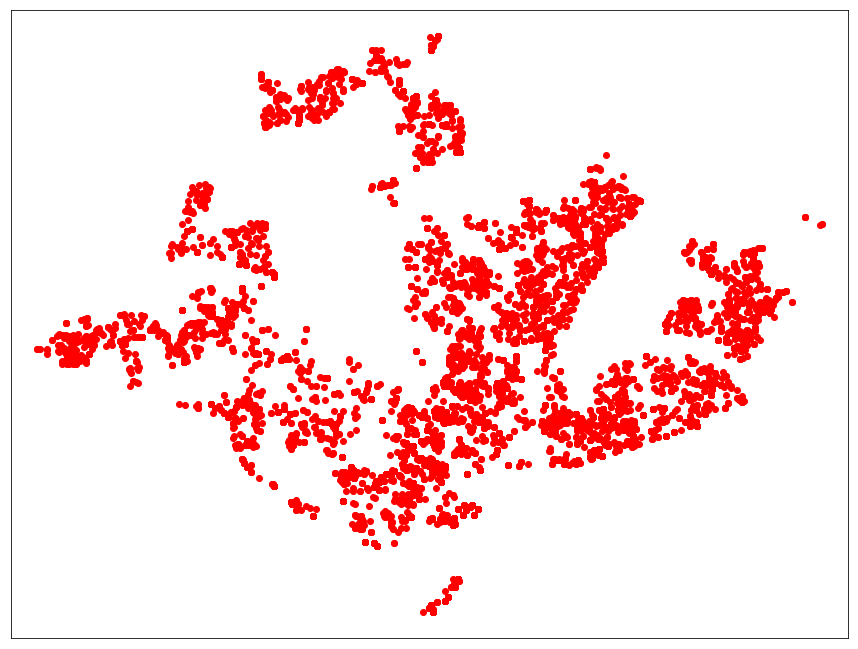

In [245]:
# using basemap because mplleaflet doesn't seem to work

fig = plt.figure(figsize=(15,15))
m.fillcontinents(color = 'white',lake_color='#46bcec')

lat = s_mrt_df4['LATITUDE'].values
lon = s_mrt_df4['LONGITUDE'].values

margin = 0.01 # create a margin for the maps

lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            resolution = 'h',
            area_thresh=10000.
          )
m.scatter(lon, lat, marker = 'o', color='r', zorder=500)

# looks like the shape of singapore. Lets include the distance from MRT column

In [246]:
s_mrt_df4.head()

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-19T14:09:37.246165     2   
1           1  2019-05-19T14:09:50.606395     1   
2           2  2019-05-19T14:09:54.924170     2   
3           3  2019-05-19T14:09:58.751280     3   
4           4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address     ...      \
0     ['HDB 5 Rooms, District 02, Singapore']     ...       
1  ['Canberra Drive, District 27, Singapore']     ...       
2     ['HDB 5 Rooms, District 02, Singapore']     ...       
3     ['HDB 3 Rooms, District 05, Singapore']     ...       
4     ['HDB 3 Rooms, District 19, Singapore']     ...       

                                         rental_dict           agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
1             {'Facing': 'North', 'District': 'D27'}             Nick Tan   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
3                 {'Floor': '09', 'District': 'D05'}  Ivan Low @ 93868686   
4                                {'District': 'D19'}         Jennifer Wee   

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description     property_title2  \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra   
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road   
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...  1 Hougang Avenue 3   

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE  
0  1.277035  103.841261  
1  1.437692  103.830278  
2  1.277035  103.841261  
3  1.302526  103.783273  
4  1.364131  103.893001  

[5 rows x 25 columns]

In [247]:
for i, row in s_mrt_df4.iterrows():
    coords_1 = (row['LATITUDE'], row['LONGITUDE'])
    nearest_mrt = []
    nearest_distance = 0
    for ii, mrt in mrt_locations2.iterrows():
        coords_2 = (mrt['Latitude'], mrt['Longitude'])
        if nearest_mrt == []:
            nearest_mrt = mrt['STN_NAME']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("first entry")
        elif geopy.distance.vincenty(coords_1, coords_2).km < nearest_distance:
            nearest_mrt = mrt['STN_NAME']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("found nearer")
    s_mrt_df4.loc[i,'nearest_mrt'] = nearest_mrt
    s_mrt_df4.loc[i,'nearest_distance'] = nearest_distance
    print(i, s_mrt_df4.loc[i,'ADDRESS'], nearest_mrt, nearest_distance)

/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # This is added back by InteractiveShellApp.init_path()
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]


first entry
found nearer
found nearer
found nearer
found nearer
found nearer
0 1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPORE 080001 OUTRAM PARK MRT STATION 0.3555236533925865
first entry
found nearer
found nearer
found nearer
1 1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101 YISHUN MRT STATION 1.0529380324584932
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2 1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPORE 080001 OUTRAM PARK MRT STATION 0.3555236533925865
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3 1 DOVER ROAD DOVER COURT SINGAPORE 130001 ONE-NORTH MRT STATION 0.5582263069335963
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4 1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001 HOUGANG MRT STATION 0.795036180791483
first entry
found nearer
5 1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614 ALJUNIED MRT STATION 0.41165125450105094
first entry
found nearer
6 1 L

50 102 SPOTTISWOODE PARK ROAD SPOTTISWOODE PARK ESTATE SINGAPORE 080102 OUTRAM PARK MRT STATION 0.6692712270658897
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
51 102C PUNGGOL FIELD HDB-PUNGGOL SINGAPORE 823102 PUNGGOL MRT STATION 0.7158704777293572
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
52 103 AH HOOD ROAD AH HOOD GARDENS SINGAPORE 320103 TOA PAYOH MRT STATION 0.5954731585214456
first entry
found nearer
found nearer
found nearer
53 103 ANG MO KIO AVENUE 3 KEBUN BARU HEIGHTS SINGAPORE 560103 ANG MO KIO MRT STATION 1.1468256522309133
first entry
found nearer
found nearer
found nearer
54 103 ANG MO KIO AVENUE 3 KEBUN BARU HEIGHTS SINGAPORE 560103 ANG MO KIO MRT STATION 1.1468256522309133
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
55 103 BISHAN STREET 12 BISHAN VIEW SINGAPORE 570103 BRADDELL MRT STATION 0.5824889954199926


found nearer
108 110 RIVERVALE WALK RIVERVALE COURT SINGAPORE 540110 BUANGKOK MRT STATION 0.8050492313261123
first entry
found nearer
found nearer
109 110 YISHUN RING ROAD CHONG PANG GARDEN SINGAPORE 760110 YISHUN MRT STATION 0.8218313655677648
first entry
found nearer
found nearer
found nearer
110 111 BEDOK NORTH ROAD HDB-BEDOK SINGAPORE 460111 BEDOK RESERVOIR MRT STATION 0.6748666297167114
first entry
found nearer
found nearer
found nearer
111 111 BEDOK NORTH ROAD HDB-BEDOK SINGAPORE 460111 BEDOK RESERVOIR MRT STATION 0.6748666297167114
first entry
found nearer
found nearer
found nearer
112 111 BEDOK NORTH ROAD HDB-BEDOK SINGAPORE 460111 BEDOK RESERVOIR MRT STATION 0.6748666297167114
first entry
found nearer
found nearer
found nearer
113 111 BEDOK NORTH ROAD HDB-BEDOK SINGAPORE 460111 BEDOK RESERVOIR MRT STATION 0.6748666297167114
first entry
found nearer
found nearer
found nearer
found nearer
114 111 BISHAN STREET 12 BISHAN VIEW SINGAPORE 570111 BISHAN MRT STATION 0.4171149941059723

found nearer
156 115 HOUGANG AVENUE 1 HDB-HOUGANG SINGAPORE 530115 KOVAN MRT STATION 0.8780410225320378
first entry
found nearer
found nearer
found nearer
157 115 HOUGANG AVENUE 1 HDB-HOUGANG SINGAPORE 530115 KOVAN MRT STATION 0.8780410225320378
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
158 115 POTONG PASIR AVENUE 1 HDB-POTONG PASIR SINGAPORE 350115 WOODLEIGH MRT STATION 0.9154456778763332
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
159 115 POTONG PASIR AVENUE 1 HDB-POTONG PASIR SINGAPORE 350115 WOODLEIGH MRT STATION 0.9154456778763332
first entry
found nearer
found nearer
160 115A YISHUN RING ROAD CHONG PANG GARDEN SINGAPORE 761115 YISHUN MRT STATION 0.937093580941183
first entry
found nearer
found nearer
161 115A YISHUN RING ROAD CHONG PANG GARDEN SINGAPORE 761115 YISHUN MRT STATION 0.937093580941183
first entry
found nearer
found nearer
162 115B YISHUN RING ROAD CH

213 120 GRANGE SINGAPORE ORCHARD MRT STATION 0.8694758967510214
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
214 120 GRANGE SINGAPORE ORCHARD MRT STATION 0.8694758967510214
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
215 120 GRANGE SINGAPORE ORCHARD MRT STATION 0.8694758967510214
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
216 120 GRANGE SINGAPORE ORCHARD MRT STATION 0.8694758967510214
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
217 120 GRANGE SINGAPORE ORCHARD MRT STATION 0.8694758967510214
first entry
found nearer
found nearer
found nearer
found nea

263 123 BISHAN STREET 12 HDB-BISHAN SINGAPORE 570123 BISHAN MRT STATION 0.5461564825505895
first entry
found nearer
found nearer
found nearer
found nearer
264 123 BISHAN STREET 12 HDB-BISHAN SINGAPORE 570123 BISHAN MRT STATION 0.5461564825505895
first entry
found nearer
found nearer
found nearer
265 123 MARSILING RISE HDB-WOODLANDS SINGAPORE 730123 WOODLANDS MRT STATION 0.8759446254733741
first entry
found nearer
found nearer
266 123 PAYA LEBAR WAY HDB-GEYLANG SINGAPORE 381123 MATTAR MRT STATION 0.45564154013345814
first entry
found nearer
found nearer
found nearer
found nearer
267 123 SERANGOON NORTH AVENUE 1 HDB-SERANGOON ESTATE SINGAPORE 550123 KOVAN MRT STATION 1.5759868361982252
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
268 123C RIVERVALE DRIVE RIVERVALE GROVE SINGAPORE 543123 SENGKANG MRT STATION 0.9523078857640762
first entry
found nearer
found nearer
found nearer
found nearer
269 124 BEDOK NORTH ROAD HDB-BEDOK SINGAPORE 460124 TANAH MERAH MRT 

324 130 PASIR RIS STREET 11 HDB-PASIR RIS SINGAPORE 510130 TAMPINES EAST MRT STATION 1.0472174424660314
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
325 130 SIMEI STREET 1 HDB-TAMPINES SINGAPORE 520130 SIMEI MRT STATION 0.3711726197396142
first entry
found nearer
found nearer
found nearer
found nearer
326 131 BISHAN STREET 12 HDB-BISHAN SINGAPORE 570131 BISHAN MRT STATION 0.6604345226824803
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
327 131 PASIR RIS STREET 11 HDB-PASIR RIS SINGAPORE 510131 TAMPINES EAST MRT STATION 1.093167678198586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
328 131 SIMEI STREET 1 HDB-SIMEI SINGAPORE 520131 SIMEI MRT STATION 0.26270292268179424
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
329 131B KIM TIAN ROAD

found nearer
378 141 YISHUN RING ROAD HDB-YISHUN SINGAPORE 760141 YISHUN MRT STATION 0.5795787253522174
first entry
found nearer
found nearer
found nearer
found nearer
379 142 BEDOK RESERVOIR ROAD EUNOS SPRING SINGAPORE 470142 BEDOK NORTH MRT STATION 0.5308013575538103
first entry
found nearer
found nearer
found nearer
380 142 BISHAN STREET 12 BISHAN GREEN SINGAPORE 570142 BISHAN MRT STATION 0.8003767295361988
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
381 142A PASIR RIS STREET 11 MULTI STOREY CAR PARK SINGAPORE 511142 TAMPINES EAST MRT STATION 0.9354076441211306
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
382 142 RIVERVALE CRESCENT RIVERVALE PLACE SINGAPORE 540142 SENGKANG MRT STATION 1.081154479262424
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
383 142 RIVERVALE CRESCENT RIVERVALE PLACE SINGAPORE 540142 SENGKANG MRT STATION 1.08115447

429 155 BISHAN STREET 13 HDB-BISHAN SINGAPORE 570155 BISHAN MRT STATION 0.9385941887253075
first entry
found nearer
found nearer
found nearer
430 155 BISHAN STREET 13 HDB-BISHAN SINGAPORE 570155 BISHAN MRT STATION 0.9385941887253075
first entry
found nearer
found nearer
found nearer
found nearer
431 156 ANG MO KIO AVENUE 4 YIO CHU KANG GROVE SINGAPORE 560156 YIO CHU KANG MRT STATION 0.8879471282492821
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
432 156A RIVERVALE CRESCENT RIVERVALE GREEN SINGAPORE 541156 SENGKANG MRT STATION 1.2787851976645306
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
433 157 LORONG 1 TOA PAYOH HDB-TOA PAYOH SINGAPORE 310157 TOA PAYOH MRT STATION 0.23234188021004337
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
434 157A MEI LING ST

found nearer
483 168A QUEENSWAY HDB-QUEENSTOWN SINGAPORE 140168 QUEENSTOWN MRT STATION 0.6759046733791825
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
484 168A QUEENSWAY HDB-QUEENSTOWN SINGAPORE 140168 QUEENSTOWN MRT STATION 0.6759046733791825
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
485 168B SIMEI LANE PARC LUMIERE SINGAPORE 522168 UPPER CHANGI MRT STATION 0.3123362248513911
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
486 168B SIMEI LANE PARC LUMIERE SINGAPORE 522168 UPPER CHANGI MRT STATION 0.3123362248513911
first entry
found nearer
found nearer
487 169 BUKIT BATOK WEST AVENUE 8 HDB-BUKIT BATOK SINGAPORE 650169 BUKIT BATOK MRT STATION 1.002642416840842
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
fo

536 18 MARSILING LANE SINGAPORE 730018 WOODLANDS MRT STATION 1.203101716937401
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
537 18 SHELFORD SINGAPORE BOTANIC GARDENS MRT STATION 0.6343764812241439
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
538 18 SHELFORD SINGAPORE BOTANIC GARDENS MRT STATION 0.6343764812241439
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
539 18 WOODSVILLE SINGAPORE POTONG PASIR MRT STATION 0.2197159290161089
first entry
found nearer
found nearer
found nearer
found nearer
540 180 BUKIT BATOK WEST AVENUE 8 HDB-BUKIT BATOK SINGAPORE 650180 BUKIT BATOK MRT STATION 0.8435999818355535
first entry
found nearer
found nearer
found nearer
found nearer
541 180 YUNG SHENG ROAD CORPORATION SPRING SINGAPORE 610180 LAKESIDE MRT STATION 1.1689701163101103
first entry
found nearer
found nearer
542 180A BOON LAY DRIVE BOON LAY MEADOW SINGAPORE 641180 BOON LAY MRT STATION 1.035

found nearer
599 196A BOON LAY DRIVE BOON LAY FIELDS SINGAPORE 641196 LAKESIDE MRT STATION 0.7977907227324739
first entry
found nearer
found nearer
found nearer
600 196B BOON LAY DRIVE BOON LAY FIELDS SINGAPORE 642196 LAKESIDE MRT STATION 0.7608534033687805
first entry
found nearer
found nearer
found nearer
601 197A BOON LAY DRIVE BOON LAY FIELDS SINGAPORE 641197 LAKESIDE MRT STATION 0.8082462904516845
first entry
found nearer
found nearer
found nearer
602 197B BOON LAY DRIVE BOON LAY FIELDS SINGAPORE 642197 LAKESIDE MRT STATION 0.8306553281826993
first entry
found nearer
found nearer
found nearer
603 197B BOON LAY DRIVE BOON LAY FIELDS SINGAPORE 642197 LAKESIDE MRT STATION 0.8306553281826993
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
604 199A PUNGGOL FIELD HDB-PUNGGOL SINGAPORE 821199 PUNGGOL MRT STATION 0.6868622333859613
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
605 1C CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPORE 

653 205 TOA PAYOH NORTH TOA PAYOH NORTH SINGAPORE 310205 BRADDELL MRT STATION 0.24350595648554185
first entry
found nearer
found nearer
654 205 YISHUN STREET 21 HDB-YISHUN SINGAPORE 760205 YISHUN MRT STATION 0.2311145821163751
first entry
found nearer
found nearer
found nearer
655 206 BISHAN STREET 23 HDB-BISHAN SINGAPORE 570206 BISHAN MRT STATION 0.5060296102594027
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
656 206 JURONG EAST STREET 21 JURONG EAST VIEW SINGAPORE 600206 JURONG EAST MRT STATION 0.5154873150039108
first entry
found nearer
found nearer
found nearer
found nearer
657 206 PETIR ROAD HDB-BUKIT PANJANG SINGAPORE 670206 CASHEW MRT STATION 1.152017115946336
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
658 206 TOA PAYOH NORTH TOA PAYOH NORTH SINGAPORE 310206 BRADDELL MRT STATION 0.2062624698904778
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
659 206 TOA PAYOH NORTH TOA 

707 213 JURONG EAST STREET 21 HDB-JURONG EAST SINGAPORE 600213 JURONG EAST MRT STATION 0.7088511844393977
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
708 213 JURONG EAST STREET 21 HDB-JURONG EAST SINGAPORE 600213 JURONG EAST MRT STATION 0.7088511844393977
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
709 213A COMPASSVALE LANE COMPASSVALE PEARL SINGAPORE 541213 SENGKANG MRT STATION 0.8371519631300516
first entry
found nearer
found nearer
found nearer
found nearer
710 213B PUNGGOL WALK PUNGGOL WAVES SINGAPORE 822213 PUNGGOL MRT STATION 0.5802451017393068
first entry
found nearer
found nearer
found nearer
found nearer
711 213B PUNGGOL WALK PUNGGOL WAVES SINGAPORE 822213 PUNGGOL MRT STATION 0.5802451017393068
first entry
found nearer
found nearer
found nearer
found nearer
712 213C PUNGGOL WALK PUNGGOL WAVES SINGAPORE 823213 PUNGGOL MRT STATION 0.5586324034310757
first entry
found nearer
found nearer
f

found nearer
758 224 SERANGOON AVENUE 4 BOUNDARY VILLE SINGAPORE 550224 SERANGOON MRT STATION 0.7504217211119074
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
759 224 SIMEI STREET 4 HDB-TAMPINES SINGAPORE 520224 UPPER CHANGI MRT STATION 0.44910028089064213
first entry
found nearer
found nearer
found nearer
760 225 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPORE 560225 ANG MO KIO MRT STATION 1.2997080001925243
first entry
found nearer
found nearer
found nearer
761 225 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPORE 560225 ANG MO KIO MRT STATION 1.2997080001925243
first entry
found nearer
found nearer
found nearer
762 225 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPORE 560225 ANG MO KIO MRT STATION 1.2997080001925243
first entry
found nearer
found nearer
found nearer
763 225 BISHAN STREET 23 HDB-BISHAN SINGAPORE 570225 BISHAN MRT STATION 0.8212613240123504
first entry
found nearer
found nearer
found nearer
764 225 BISHAN STREET

found nearer
812 237 PASIR RIS STREET 21 HDB-PASIR RIS SINGAPORE 510237 PASIR RIS MRT STATION 1.522027039615641
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
813 238 COMPASSVALE WALK SENGKANG MRT STATION 0.3819332650965439
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
814 238 LORONG 1 TOA PAYOH HDB-TOA PAYOH SINGAPORE 310238 BRADDELL MRT STATION 0.5327968112980345
first entry
found nearer
found nearer
815 238 YISHUN RING ROAD SINGAPORE 760238 YISHUN MRT STATION 0.6157275979887054
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
816 239 COMPASSVALE WALK COMPASSVALE PLAINS SINGAPORE 540239 SENGKANG MRT STATION 0.3024804921692292
first entry
found nearer
found nearer
found nearer
found nearer
817 239 HOUGANG STREET 22 HOUGANG HEIGHTS SINGAPORE 530239 KOVAN MRT STATION 0.7623555496973734
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer

860 249 TAMPINES STREET 21 HDB-TAMPINES SINGAPORE 520249 TAMPINES MRT STATION 0.4046582967748269
first entry
found nearer
found nearer
861 25 MARSILING DRIVE MARSILING GREEN SINGAPORE 730025 MARSILING MRT STATION 1.0666061400666509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
862 25 SIN MING ROAD SINGAPORE 570025 MARYMOUNT MRT STATION 0.7652353137718187
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
863 25 TELOK BLANGAH CRESCENT HDB-BUKIT MERAH SINGAPORE 090025 TELOK BLANGAH MRT STATION 1.218584059585478
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
864 25 TELOK BLANGAH CRESCENT HDB-BUKIT MERAH SINGAPORE 090025 TELOK BLANGAH MRT STATION 1.218584059585478
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
865 25 TOA PAYOH EAST HDB-TOA PAYOH SINGAPORE 3100

found nearer
found nearer
found nearer
found nearer
found nearer
906 26 NEWTON SINGAPORE NEWTON MRT STATION 0.4847767036322523
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
907 26 NEWTON SINGAPORE NEWTON MRT STATION 0.4847767036322523
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
908 26 NEWTON SINGAPORE NEWTON MRT STATION 0.4847767036322523
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
909 26 NEWTON SINGAPORE NEWTON MRT STATION 0.4847767036322523
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
910 26 NEWTON SINGAPORE NEWTON MRT STATION 0.4847767036322523
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
911 26 NEWTON SINGAPORE NEWTON MRT STATION 0.

959 265D COMPASSVALE BOW THE CORIS SINGAPORE 544265 BUANGKOK MRT STATION 0.38397264734047365
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
960 265D PUNGGOL WAY PUNGGOL EMERALD SINGAPORE 824265 PUNGGOL MRT STATION 0.4184961931782954
first entry
found nearer
found nearer
961 266 BOON LAY DRIVE BOON LAY CREST SINGAPORE 640266 BOON LAY MRT STATION 0.8295466082981492
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
962 266 PASIR RIS STREET 21 HDB-PASIR RIS SINGAPORE 510266 TAMPINES EAST MRT STATION 1.5085370758675345
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
963 266 PASIR RIS STREET 21 HDB-PASIR RIS SINGAPORE 510266 TAMPINES EAST MRT STATION 1.5085370758675345
first entry
found nearer
found nearer
964 266 YISHUN STREET 22 HDB-YISHUN SINGAPORE 760266 YISHUN MRT STATION 0.9378811707924268
first entry
found nearer
found nearer
965 266 YISHUN STREET 2

1007 273A PUNGGOL PLACE PUNGGOL REGALIA SINGAPORE 821273 PUNGGOL MRT STATION 0.25023420173016964
first entry
found nearer
found nearer
found nearer
found nearer
1008 273C PUNGGOL PLACE PUNGGOL REGALIA SINGAPORE 823273 PUNGGOL MRT STATION 0.2632004937950277
first entry
found nearer
found nearer
found nearer
found nearer
1009 273C PUNGGOL PLACE PUNGGOL REGALIA SINGAPORE 823273 PUNGGOL MRT STATION 0.2632004937950277
first entry
found nearer
found nearer
found nearer
found nearer
1010 273D COMPASSVALE LINK ATRINA SINGAPORE 544273 BUANGKOK MRT STATION 0.2042433837851569
first entry
found nearer
found nearer
found nearer
found nearer
1011 273D COMPASSVALE LINK ATRINA SINGAPORE 544273 BUANGKOK MRT STATION 0.2042433837851569
first entry
found nearer
found nearer
found nearer
found nearer
1012 273D PUNGGOL PLACE PUNGGOL REGALIA SINGAPORE 824273 PUNGGOL MRT STATION 0.23905091387503904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1013 274 

1058 281B SENGKANG EAST AVENUE COMPASSVALE ANCILLA SINGAPORE 542281 BUANGKOK MRT STATION 0.3442754293050893
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1059 282A TOH GUAN ROAD MULTI STOREY CAR PARK SINGAPORE 601282 JURONG EAST MRT STATION 0.9355316721343802
first entry
found nearer
found nearer
found nearer
found nearer
1060 282A SENGKANG EAST AVENUE COMPASSVALE ANCILLA SINGAPORE 541282 BUANGKOK MRT STATION 0.29810764146635876
first entry
found nearer
found nearer
found nearer
found nearer
1061 282B SENGKANG EAST AVENUE COMPASSVALE ANCILLA SINGAPORE 542282 BUANGKOK MRT STATION 0.25164962556335846
first entry
found nearer
found nearer
found nearer
found nearer
1062 283 BUKIT BATOK EAST AVENUE 3 GOMBAK PLACE SINGAPORE 650283 BUKIT BATOK MRT STATION 0.9143772228732994
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1063 283 CHOA CHU KANG AVENUE 3 HDB-CHOA CHU KANG SINGAPORE 680283 CHOA CHU KANG MRT STATION 0.6468629991282213
fi

1105 3 CUSCADEN WALK 3 CUSCADEN SINGAPORE 249690 ORCHARD MRT STATION 0.31761650660417934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1106 3 CUSCADEN WALK 3 CUSCADEN SINGAPORE 249690 ORCHARD MRT STATION 0.31761650660417934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1107 3 CUSCADEN WALK 3 CUSCADEN SINGAPORE 249690 ORCHARD MRT STATION 0.31761650660417934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1108 3 CUSCADEN WALK 3 CUSCADEN SINGAPORE 249690 ORCHARD MRT STATION 0.31761650660417934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1109 3 CUSCADEN WALK 3 CUSCADEN SINGAPORE 249690 ORCHARD MRT STATION 0.31761650660417934
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
f

1172 301D ANCHORVALE DRIVE ANCHORVALE COURT SINGAPORE 544301 SENGKANG MRT STATION 0.5891451674548496
first entry
found nearer
found nearer
found nearer
1173 302 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPORE 560302 ANG MO KIO MRT STATION 0.5353300339299267
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1174 302 CLEMENTI AVENUE 4 CLEMENTI MEADOWS SINGAPORE 120302 CLEMENTI MRT STATION 0.751519314283274
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1175 302 CLEMENTI AVENUE 4 CLEMENTI MEADOWS SINGAPORE 120302 CLEMENTI MRT STATION 0.751519314283274
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1176 302 CLEMENTI AVENUE 4 CLEMENTI MEADOWS SINGAPORE 120302 CLEMENTI MRT STATION 0.751519314283274
first entry
found nearer
found nearer
found nearer
found nearer
1177 302 JURONG EAST STREET 32 HONG KAH EAST GARDEN SINGAPORE 600302 CHINESE GARDEN MRT STATION 0.32799002187172394
first entry
found nearer
found near

1227 310A ANG MO KIO AVENUE 1 TECK GHEE VISTA SINGAPORE 561310 ANG MO KIO MRT STATION 0.8425396027485688
first entry
found nearer
found nearer
1228 310B ANG MO KIO AVENUE 1 TECK GHEE VISTA SINGAPORE 562310 ANG MO KIO MRT STATION 0.8179034123915738
first entry
found nearer
found nearer
1229 310B ANG MO KIO AVENUE 1 TECK GHEE VISTA SINGAPORE 562310 ANG MO KIO MRT STATION 0.8179034123915738
first entry
found nearer
found nearer
1230 310C ANG MO KIO AVENUE 1 TECK GHEE VISTA SINGAPORE 563310 ANG MO KIO MRT STATION 0.7703124473057833
first entry
found nearer
found nearer
1231 311 ANG MO KIO AVENUE 3 TECK GHEE EVERGREEN SINGAPORE 560311 ANG MO KIO MRT STATION 0.325973417807759
first entry
found nearer
found nearer
1232 311 ANG MO KIO AVENUE 3 TECK GHEE EVERGREEN SINGAPORE 560311 ANG MO KIO MRT STATION 0.325973417807759
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1233 311 HOUGANG AVENUE 5 HDB-HOUGANG SINGAPORE 530311 HOUGANG MRT STATION 0.6807820899659939
first

1284 323 JURONG EAST STREET 31 HDB-JURONG EAST SINGAPORE 600323 CHINESE GARDEN MRT STATION 0.7807564828847599
first entry
found nearer
found nearer
found nearer
found nearer
1285 323 JURONG EAST STREET 31 HDB-JURONG EAST SINGAPORE 600323 CHINESE GARDEN MRT STATION 0.7807564828847599
first entry
found nearer
found nearer
found nearer
found nearer
1286 323 JURONG EAST STREET 31 HDB-JURONG EAST SINGAPORE 600323 CHINESE GARDEN MRT STATION 0.7807564828847599
first entry
found nearer
found nearer
found nearer
found nearer
1287 323 JURONG EAST STREET 31 HDB-JURONG EAST SINGAPORE 600323 CHINESE GARDEN MRT STATION 0.7807564828847599
first entry
found nearer
found nearer
found nearer
found nearer
1288 323 JURONG EAST STREET 31 HDB-JURONG EAST SINGAPORE 600323 CHINESE GARDEN MRT STATION 0.7807564828847599
first entry
found nearer
found nearer
found nearer
found nearer
1289 324 TAH CHING ROAD HDB-TAMAN JURONG SINGAPORE 610324 LAKESIDE MRT STATION 0.9140480877384516
first entry
found nearer
found n

found nearer
1334 333D ANCHORVALE LINK ANCHORVALE ISLES SINGAPORE 544333 SENGKANG MRT STATION 0.45484942504442094
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1335 334A SERANGOON AVENUE 3 SINGAPORE 551334 SERANGOON MRT STATION 0.15307956175979012
first entry
found nearer
found nearer
1336 334A YISHUN STREET 31 YISHUN RIVERWALK SINGAPORE 761334 YISHUN MRT STATION 1.144419703600199
first entry
found nearer
found nearer
1337 334C YISHUN STREET 31 YISHUN RIVERWALK SINGAPORE 763334 YISHUN MRT STATION 1.3141207996302897
first entry
found nearer
found nearer
1338 334C YISHUN STREET 31 YISHUN RIVERWALK SINGAPORE 763334 YISHUN MRT STATION 1.3141207996302897
first entry
found nearer
found nearer
1339 334C YISHUN STREET 31 YISHUN RIVERWALK SINGAPORE 763334 YISHUN MRT STATION 1.3141207996302897
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1340 335C ANCHORVALE CRESCENT ANCHORVALE COVE SINGAPORE 543335 SENGKANG MRT STATION 

found nearer
1393 348A YISHUN AVENUE 11 ADORA GREEN SINGAPORE 761348 YISHUN MRT STATION 0.7291917483553949
first entry
found nearer
found nearer
1394 348A YISHUN AVENUE 11 ADORA GREEN SINGAPORE 761348 YISHUN MRT STATION 0.7291917483553949
first entry
found nearer
found nearer
1395 348B YISHUN AVENUE 11 ADORA GREEN SINGAPORE 762348 YISHUN MRT STATION 0.8123409240096198
first entry
found nearer
found nearer
1396 348B YISHUN AVENUE 11 ADORA GREEN SINGAPORE 762348 YISHUN MRT STATION 0.8123409240096198
first entry
found nearer
found nearer
1397 348C YISHUN AVENUE 11 ADORA GREEN SINGAPORE 763348 YISHUN MRT STATION 0.8435433227096883
first entry
found nearer
found nearer
1398 348D YISHUN AVENUE 11 ADORA GREEN SINGAPORE 764348 YISHUN MRT STATION 0.9213366197253163
first entry
found nearer
found nearer
1399 348D YISHUN AVENUE 11 ADORA GREEN SINGAPORE 764348 YISHUN MRT STATION 0.9213366197253163
first entry
found nearer
found nearer
1400 348D YISHUN AVENUE 11 ADORA GREEN SINGAPORE 764348 YISHUN 

found nearer
found nearer
1453 361A TAMPINES STREET 34 SINGAPORE 521361 TAMPINES EAST MRT STATION 0.8447391005890066
first entry
found nearer
found nearer
1454 361 WOODLANDS AVENUE 5 HDB-WOODLANDS SINGAPORE 730361 WOODLANDS MRT STATION 0.3777986212088695
first entry
found nearer
found nearer
1455 363 YISHUN RING ROAD YISHUN GLORY SINGAPORE 760363 YISHUN MRT STATION 1.1368409667102513
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1456 364 CLEMENTI AVENUE 2 HDB-CLEMENTI SINGAPORE 120364 CLEMENTI MRT STATION 0.4749369039455243
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1457 364 CLEMENTI AVENUE 2 HDB-CLEMENTI SINGAPORE 120364 CLEMENTI MRT STATION 0.4749369039455243
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1458 364A TAMPINES STREET 34 MULTI STOREY CAR PARK SINGAPORE 521364 TAMPINES EAST MRT STATION 0.5

1503 388A BUKIT BATOK WEST AVENUE 5 SINGAPORE 651388 BUKIT GOMBAK MRT STATION 0.6282303660414911
first entry
found nearer
found nearer
1504 389 YISHUN AVENUE 6 HDB-YISHUN SINGAPORE 760389 YISHUN MRT STATION 1.4485512741566975
first entry
found nearer
found nearer
found nearer
found nearer
1505 38C BENDEMEER ROAD THE RIVER VISTA @ KALLANG SINGAPORE 333038 GEYLANG BAHRU MRT STATION 0.5695699617280836
first entry
found nearer
found nearer
found nearer
found nearer
1506 38C BENDEMEER ROAD THE RIVER VISTA @ KALLANG SINGAPORE 333038 GEYLANG BAHRU MRT STATION 0.5695699617280836
first entry
found nearer
found nearer
found nearer
found nearer
1507 38D BENDEMEER ROAD THE RIVER VISTA @ KALLANG SINGAPORE 334038 GEYLANG BAHRU MRT STATION 0.5703299779861292
first entry
found nearer
found nearer
found nearer
found nearer
1508 38D BENDEMEER ROAD THE RIVER VISTA @ KALLANG SINGAPORE 334038 GEYLANG BAHRU MRT STATION 0.5703299779861292
first entry
found nearer
found nearer
found nearer
found nearer
1509 3

1557 406 SIN MING AVENUE SIN MING GARDEN SINGAPORE 570406 MARYMOUNT MRT STATION 1.6822456221032334
first entry
found nearer
found nearer
found nearer
found nearer
1558 406A FERNVALE ROAD FERN VIEW SINGAPORE 791406 BUANGKOK MRT STATION 2.1690399426192815
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1559 407 CHOA CHU KANG AVENUE 3 HDB-CHOA CHU KANG SINGAPORE 680407 CHOA CHU KANG MRT STATION 0.6737587608375029
first entry
found nearer
found nearer
found nearer
found nearer
1560 407 FAJAR ROAD HDB-BUKIT PANJANG SINGAPORE 670407 BUKIT PANJANG MRT STATION 0.7982616609353739
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1561 407 HOUGANG AVENUE 10 SINGAPORE 530407 HOUGANG MRT STATION 0.4121657466169786
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1562 407 HOUGANG AVENUE 10 SINGAPORE 530407 HOUGANG MRT STATION 0.4121657466169786
first entry
found nearer
found nearer
found nearer
found nearer
found nea

found nearer
1608 416C FERNVALE LINK FERNVALE RIVERBOW SINGAPORE 793416 BUANGKOK MRT STATION 1.5838455245653875
first entry
found nearer
found nearer
1609 418 ANG MO KIO AVENUE 10 TECK GHEE HEARTLANDS SINGAPORE 560418 ANG MO KIO MRT STATION 0.6682636981945141
first entry
found nearer
found nearer
1610 418 ANG MO KIO AVENUE 10 TECK GHEE HEARTLANDS SINGAPORE 560418 ANG MO KIO MRT STATION 0.6682636981945141
first entry
found nearer
found nearer
1611 419 ANG MO KIO AVENUE 10 TECK GHEE HEARTLANDS SINGAPORE 560419 ANG MO KIO MRT STATION 0.6454567520491269
first entry
found nearer
found nearer
1612 419 ANG MO KIO AVENUE 10 TECK GHEE HEARTLANDS SINGAPORE 560419 ANG MO KIO MRT STATION 0.6454567520491269
first entry
found nearer
found nearer
found nearer
found nearer
1613 419 FAJAR ROAD HDB-BUKIT PANJANG SINGAPORE 670419 BUKIT PANJANG MRT STATION 1.0501777785124937
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1614 419 SERANGOON CENTRAL HDB-SERANGOON ESTATE SINGAPO

1666 432 CHOA CHU KANG AVENUE 4 HDB-CHOA CHU KANG SINGAPORE 680432 CHOA CHU KANG MRT STATION 0.2928834441380194
first entry
found nearer
found nearer
found nearer
1667 432A YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 761432 KHATIB MRT STATION 1.5794717619522585
first entry
found nearer
found nearer
found nearer
1668 432A YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 761432 KHATIB MRT STATION 1.5794717619522585
first entry
found nearer
found nearer
found nearer
1669 432A YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 761432 KHATIB MRT STATION 1.5794717619522585
first entry
found nearer
found nearer
found nearer
1670 432B YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 762432 KHATIB MRT STATION 1.5122905884195554
first entry
found nearer
found nearer
found nearer
1671 432B YISHUN AVENUE 1 VISTA SPRING @ YISHUN SINGAPORE 762432 KHATIB MRT STATION 1.5122905884195554
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1672 433 CLEMEN

found nearer
1717 444 CHOA CHU KANG AVENUE 4 HDB-CHOA CHU KANG SINGAPORE 680444 CHOA CHU KANG MRT STATION 0.8738694020376528
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1718 445 SIN MING AVENUE SIN MING COURT SINGAPORE 570445 MARYMOUNT MRT STATION 1.3993769463025396
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1719 445 TAMPINES STREET 42 HDB-TAMPINES SINGAPORE 520445 TAMPINES EAST MRT STATION 0.4969402608082928
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1720 445 TAMPINES STREET 42 HDB-TAMPINES SINGAPORE 520445 TAMPINES EAST MRT STATION 0.4969402608082928
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1721 446 CHOA CHU KANG AVENUE 4 HDB-CHOA CHU KANG SINGAPORE 680446 CHOA CHU KANG MRT STATION 0.9779285778517524
first entry
found nearer
found nearer
found nea

1766 460 ANG MO KIO AVENUE 10 TECK GHEE GRANDEUR SINGAPORE 560460 ANG MO KIO MRT STATION 1.0758816847333197
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1767 460 TAMPINES STREET 42 HDB-TAMPINES SINGAPORE 520460 TAMPINES EAST MRT STATION 0.23738637065175153
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1768 460 TAMPINES STREET 42 HDB-TAMPINES SINGAPORE 520460 TAMPINES EAST MRT STATION 0.23738637065175153
first entry
found nearer
found nearer
found nearer
found nearer
1769 461 SEGAR ROAD SEGAR MEADOWS SINGAPORE 670461 BUKIT PANJANG MRT STATION 1.3957778400627225
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1770 462A CRAWFORD LANE SINGAPORE 191462 LAVENDER MRT STATION 0.3566915617937605
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1771 

1817 473 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SINGAPORE 560473 ANG MO KIO MRT STATION 1.0377674331323792
first entry
found nearer
found nearer
1818 475 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SINGAPORE 560475 ANG MO KIO MRT STATION 1.0410412959475261
first entry
found nearer
found nearer
1819 475 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SINGAPORE 560475 ANG MO KIO MRT STATION 1.0410412959475261
first entry
found nearer
found nearer
1820 475 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SINGAPORE 560475 ANG MO KIO MRT STATION 1.0410412959475261
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1821 475 PASIR RIS DRIVE 6 HDB-PASIR RIS SINGAPORE 510475 PASIR RIS MRT STATION 0.9148261940271041
first entry
found nearer
found nearer
found nearer
found nearer
1822 475 SEGAR ROAD SEGAR GARDENS SINGAPORE 670475 BUKIT PANJANG MRT STATION 1.6522308430530062
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1823 475B UPPER SER

1862 497D TAMPINES STREET 45 HDB-TAMPINES SINGAPORE 523497 TAMPINES EAST MRT STATION 0.5774017033596871
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1863 497H TAMPINES STREET 45 HDB-TAMPINES SINGAPORE 526497 TAMPINES EAST MRT STATION 0.7339305125722085
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1864 498A TAMPINES STREET 45 HDB-TAMPINES SINGAPORE 520498 TAMPINES EAST MRT STATION 0.7055831751005546
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1865 498H TAMPINES STREET 45 HDB-TAMPINES SINGAPORE 526498 TAMPINES EAST MRT STATION 0.815488205581425
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1866 499B TAMPINES AVENUE 9 TAMPINES RIA SINGAPORE 522499 TAMPINES EA

1919 512 BEDOK NORTH AVENUE 2 KAKI BUKIT GREEN SINGAPORE 460512 BEDOK RESERVOIR MRT STATION 0.4920528406758863
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1920 512 BUKIT BATOK STREET 52 GUILIN BREEZE SINGAPORE 650512 BUKIT GOMBAK MRT STATION 0.5372891422022696
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
1921 512 BUKIT BATOK STREET 52 GUILIN BREEZE SINGAPORE 650512 BUKIT GOMBAK MRT STATION 0.5372891422022696
first entry
found nearer
found nearer
found nearer
found nearer
1922 514 BUKIT BATOK STREET 52 GUILIN BREEZE SINGAPORE 650514 BUKIT GOMBAK MRT STATION 0.4806388942636767
first entry
found nearer
found nearer
1923 515A WOODLANDS DRIVE 14 SINGAPORE 731515 WOODLANDS MRT STATION 0.3144467595422575
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1924 515B TAMPINES CENTRAL 7 THE PREMIERE @ TAMPINES SINGAPORE 522515 TAMPINES MRT STATION 0.528541

1963 522A TAMPINES CENTRAL 7 TAMPINES GREENLEAF SINGAPORE 521522 TAMPINES MRT STATION 0.5958059001397971
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1964 522A TAMPINES CENTRAL 7 TAMPINES GREENLEAF SINGAPORE 521522 TAMPINES MRT STATION 0.5958059001397971
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1965 522B TAMPINES CENTRAL 7 TAMPINES GREENLEAF SINGAPORE 522522 TAMPINES MRT STATION 0.533761324895469
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1966 522B TAMPINES CENTRAL 7 TAMPINES GREENLEAF SINGAPORE 522522 TAMPINES MRT STATION 0.533761324895469
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
1967 522C TAMPINES CENTRAL 7 TAMPINES GREENLEAF SINGAPORE 523522 T

2022 538 HOUGANG STREET 52 HDB-HOUGANG SINGAPORE 530538 BUANGKOK MRT STATION 0.6389294074314259
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2023 538 SERANGOON NORTH AVENUE 4 HDB-SERANGOON NORTH ESTATE SINGAPORE 550538 KOVAN MRT STATION 2.094951380942135
first entry
found nearer
found nearer
found nearer
2024 538 WOODLANDS DRIVE 16 HDB-WOODLANDS SINGAPORE 730538 WOODLANDS SOUTH MRT STATION 0.3067219708933378
first entry
found nearer
found nearer
found nearer
2025 54 CASSIA CRESCENT HDB-GUILLEMARD SINGAPORE 390054 OUTRAM PARK MRT STATION 0.4786635406478428
first entry
found nearer
found nearer
found nearer
found nearer
2026 54 GEYLANG BAHRU GEYLANG BAHRU RIVERPOINT SINGAPORE 330054 GEYLANG BAHRU MRT STATION 0.5194680594836036
first entry
found nearer
found nearer
found nearer
2027 54 NEW UPPER CHANGI ROAD HDB-BEDOK SINGAPORE 461054 TANAH MERAH MRT STATION 0.4913831929358069
first entry
found nearer
found nearer
found nearer
2028 540 ANG MO KIO AVENUE 10 C

2080 560 HOUGANG STREET 51 HDB-HOUGANG SINGAPORE 530560 BUANGKOK MRT STATION 0.5007051442351144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2081 560 PASIR RIS STREET 51 HDB-PASIR RIS SINGAPORE 510560 PASIR RIS MRT STATION 0.7003291028036251
first entry
found nearer
found nearer
2082 561 ANG MO KIO AVENUE 10 CHENG SAN PLACE SINGAPORE 560561 ANG MO KIO MRT STATION 0.8925282834395977
first entry
found nearer
found nearer
2083 562 ANG MO KIO AVENUE 3 HDB-ANG MO KIO SINGAPORE 560562 ANG MO KIO MRT STATION 1.0158624080130958
first entry
found nearer
found nearer
2084 563 ANG MO KIO AVENUE 3 HDB-ANG MO KIO SINGAPORE 560563 ANG MO KIO MRT STATION 0.9005477935722369
first entry
found nearer
found nearer
2085 563 ANG MO KIO AVENUE 3 HDB-ANG MO KIO SINGAPORE 560563 ANG MO KIO MRT STATION 0.9005477935722369
first entry
found nearer
found nearer
2086 564 ANG MO KIO AVENUE 3 HDB-ANG MO KIO SINGAPORE 560564 ANG MO KIO MRT STATION

found nearer
found nearer
2135 6 HOLLAND CLOSE HDB-QUEENSTOWN SINGAPORE 271006 BUONA VISTA MRT STATION 0.5165794008951586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2136 6 HOLLAND CLOSE HDB-QUEENSTOWN SINGAPORE 271006 BUONA VISTA MRT STATION 0.5165794008951586
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2137 6 JALAN BUKIT HO SWEE BUKIT HO SWEE VIEW SINGAPORE 161006 TIONG BAHRU MRT STATION 0.5174586707089596
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2138 6 TELOK BLANGAH CRESCENT MOUNT FABER GREEN SINGAPORE 090006 TELOK BLANGAH MRT STATION 1.2693240465017377
first entry
found nearer
found nearer
found nearer
2139 60 DAKOTA CRESCENT HDB-KALLANG AIRPORT SINGAPORE 390060 OUTRAM PARK MRT STATION 0.12236736876939466
first entry
found nearer
found nearer
found nearer
found neare

2186 612 SENJA ROAD HDB-BUKIT PANJANG SINGAPORE 670612 BUKIT PANJANG MRT STATION 0.5579959209363954
first entry
found nearer
2187 612 YISHUN STREET 61 NEE SOON CENTRAL MEADOWS SINGAPORE 760612 KHATIB MRT STATION 0.42658192969581926
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2188 613 CHOA CHU KANG STREET 62 HDB-CHOA CHU KANG SINGAPORE 680613 YEW TEE MRT STATION 0.48076901247009635
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2189 613A ELIAS ROAD HDB-PASIR RIS SINGAPORE 511613 PASIR RIS MRT STATION 0.8829885813110208
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2190 613A ELIAS ROAD HDB-PASIR RIS SINGAPORE 511613 PASIR RIS MRT STATION 0.8829885813110208
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2191 613D PUNGGOL DRIVE DAMAI GROVE SINGAPORE 824613 PUNGGOL MRT STATION 0.767296413665072
first entry
found nearer
found neare

2238 631 CHOA CHU KANG NORTH 6 HDB-CHOA CHU KANG SINGAPORE 680631 YEW TEE MRT STATION 0.12690461377543769
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2239 631 CHOA CHU KANG NORTH 6 HDB-CHOA CHU KANG SINGAPORE 680631 YEW TEE MRT STATION 0.12690461377543769
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2240 631 HOUGANG AVENUE 8 HDB-HOUGANG SINGAPORE 530631 HOUGANG MRT STATION 1.2087464444125275
first entry
found nearer
found nearer
found nearer
found nearer
2241 631 SENJA ROAD HDB-BUKIT PANJANG SINGAPORE 670631 BUKIT PANJANG MRT STATION 0.8553641576718446
first entry
found nearer
found nearer
found nearer
found nearer
2242 631 SENJA ROAD HDB-BUKIT PANJANG SINGAPORE 670631 BUKIT PANJANG MRT STATION 0.8553641576718446
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2243 632A CHOA CHU KANG NORTH 6 SINGAPORE 681632 YEW TEE MRT STATION 0.1822867544374364
first entry
found nea

found nearer
2291 649A JURONG WEST STREET 61 HDB-JURONG WEST SINGAPORE 641649 PIONEER MRT STATION 0.04882764155853901
first entry
found nearer
found nearer
found nearer
2292 649A JURONG WEST STREET 61 HDB-JURONG WEST SINGAPORE 641649 PIONEER MRT STATION 0.04882764155853901
first entry
found nearer
found nearer
found nearer
2293 649B JURONG WEST STREET 61 HDB-JURONG WEST SINGAPORE 642649 PIONEER MRT STATION 0.09481954844523137
first entry
found nearer
found nearer
found nearer
2294 649B JURONG WEST STREET 61 HDB-JURONG WEST SINGAPORE 642649 PIONEER MRT STATION 0.09481954844523137
first entry
found nearer
found nearer
found nearer
found nearer
2295 65A KALLANG BAHRU MULTI STOREY CAR PARK SINGAPORE 331065 GEYLANG BAHRU MRT STATION 0.33863630673006434
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2296 65 TELOK BLANGAH DRIVE BLANGAH VIEW SINGAPORE 100065 TELOK BLANGAH MR

found nearer
2346 672D EDGEFIELD PLAINS WATERWAY BANKS SINGAPORE 824672 PUNGGOL MRT STATION 1.0430679517834982
first entry
found nearer
found nearer
2347 673A JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 641673 BOON LAY MRT STATION 0.8265435904049669
first entry
found nearer
found nearer
2348 673A JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 641673 BOON LAY MRT STATION 0.8265435904049669
first entry
found nearer
found nearer
2349 673B JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 642673 BOON LAY MRT STATION 0.8088217073854589
first entry
found nearer
found nearer
2350 673C JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 643673 BOON LAY MRT STATION 0.8601732406362005
first entry
found nearer
found nearer
2351 673C JURONG WEST STREET 65 HDB-JURONG WEST SINGAPORE 643673 BOON LAY MRT STATION 0.8601732406362005
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2352 674 HOUGANG AVENUE 8 HDB-HOUGANG SINGAPORE 530674 HOUGANG MRT STATION 0.8643951908598249
fir

2398 693 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640693 BOON LAY MRT STATION 0.47515682453753777
first entry
found nearer
found nearer
2399 694 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640694 BOON LAY MRT STATION 0.5105895759685497
first entry
found nearer
found nearer
2400 694 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640694 BOON LAY MRT STATION 0.5105895759685497
first entry
found nearer
found nearer
2401 694 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640694 BOON LAY MRT STATION 0.5105895759685497
first entry
found nearer
found nearer
2402 694 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640694 BOON LAY MRT STATION 0.5105895759685497
first entry
found nearer
found nearer
2403 695 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640695 BOON LAY MRT STATION 0.4618675461125715
first entry
found nearer
found nearer
2404 695 JURONG WEST CENTRAL 1 HDB-JURONG WEST SINGAPORE 640695 BOON LAY MRT STATION 0.4618675461125715
first entry
found nearer
found nearer
found

found nearer
2459 714 PASIR RIS STREET 72 HDB-PASIR RIS SINGAPORE 510714 PASIR RIS MRT STATION 1.6824972793619268
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2460 714 TAMPINES STREET 71 TAMPINES STARLIGHT SINGAPORE 520714 TAMPINES MRT STATION 0.8554358199854334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2461 714 TAMPINES STREET 71 TAMPINES STARLIGHT SINGAPORE 520714 TAMPINES MRT STATION 0.8554358199854334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2462 714 TAMPINES STREET 71 TAMPINES STARLIGHT SINGAPORE 520714 TAMPINES MRT STATION 0.8554358199854334
first entry
2463 714A WOODLANDS DRIVE 70 MULTI STOREY CAR PARK SINGAPORE 731714 ADMIRALTY MRT STATION 0.23455221152205313
first entry
found nearer
found nearer
found nearer
found nearer
2464 715 BEDOK RESERVOIR ROAD BEDOK RESE

found nearer
2507 738 PASIR RIS DRIVE 10 HDB-PASIR RIS SINGAPORE 510738 PASIR RIS MRT STATION 1.5688046331367715
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2508 740 TAMPINES STREET 72 TAMPINES GREEN VALE SINGAPORE 520740 TAMPINES MRT STATION 1.2322445793244754
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2509 742A TAMPINES STREET 72 MULTI STOREY CAR PARK SINGAPORE 521742 TAMPINES MRT STATION 1.127203528003144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2510 742A TAMPINES STREET 72 MULTI STOREY CAR PARK SINGAPORE 521742 TAMPINES MRT STATION 1.127203528003144
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2511 742A TAMPINES STREET 72 MULTI STOREY CAR PARK SINGAPORE 521742 TAMPINES MRT STATION 1.1272035280031

2557 770 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470770 BEDOK RESERVOIR MRT STATION 0.7000021023733098
first entry
found nearer
found nearer
found nearer
2558 771 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470771 BEDOK RESERVOIR MRT STATION 0.7447632384189166
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2559 771 PASIR RIS STREET 71 HDB-PASIR RIS SINGAPORE 510771 PASIR RIS MRT STATION 1.4454670301379504
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2560 772 PASIR RIS STREET 71 HDB-PASIR RIS SINGAPORE 510772 PASIR RIS MRT STATION 1.3899137766508827
first entry
found nearer
found nearer
found nearer
2561 773 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470773 BEDOK RESERVOIR MRT STATION 0.5851801986786236
first entry
found nearer
found nearer
found nearer
2562 773 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470773 BEDOK RESERVOIR MRT STATION 0.5851801986786236
first entry
2563 773A WOODLANDS DRIVE 60 MULTI STOREY

2616 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2617 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2618 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2619 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2620 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2621 8 SING JOO WALK 8 FARRER SUITES SINGAPORE 217820 FARRER PARK MRT STATION 0.29687242381537043
first entry
found nearer
fo

found nearer
2659 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2660 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2661 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2662 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2663 8 SAINT THOMAS WALK 8 SAIN

found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2700 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2701 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2702 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2703 8 SAINT THOMAS WALK 8 SAINT THOMAS SINGAPORE 238146 SOMERSET MRT STATION 0.5504590619213331
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found

found nearer
found nearer
2751 820 WOODLANDS STREET 82 HDB-WOODLANDS SINGAPORE 730820 WOODLANDS MRT STATION 0.6170257548620504
first entry
found nearer
found nearer
2752 820 WOODLANDS STREET 82 HDB-WOODLANDS SINGAPORE 730820 WOODLANDS MRT STATION 0.6170257548620504
first entry
found nearer
2753 820 YISHUN STREET 81 HDB-YISHUN SINGAPORE 760820 KHATIB MRT STATION 0.48393329483113817
first entry
found nearer
found nearer
2754 821 WOODLANDS STREET 82 HDB-WOODLANDS SINGAPORE 730821 WOODLANDS MRT STATION 0.5809661341723437
first entry
found nearer
found nearer
found nearer
2755 822 JURONG WEST STREET 81 HDB-JURONG WEST SINGAPORE 640822 PIONEER MRT STATION 1.120942692331205
first entry
found nearer
found nearer
found nearer
2756 823 JURONG WEST STREET 81 HDB-JURONG WEST SINGAPORE 640823 PIONEER MRT STATION 1.0651997334667083
first entry
found nearer
found nearer
found nearer
2757 823 JURONG WEST STREET 81 HDB-JURONG WEST SINGAPORE 640823 PIONEER MRT STATION 1.0651997334667083
first entry
foun

found nearer
2805 85B LORONG 4 TOA PAYOH HDB-TOA PAYOH SINGAPORE 312085 TOA PAYOH MRT STATION 0.4177608534733367
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2806 85B LORONG 4 TOA PAYOH HDB-TOA PAYOH SINGAPORE 312085 TOA PAYOH MRT STATION 0.4177608534733367
first entry
found nearer
found nearer
found nearer
found nearer
2807 86 WHAMPOA DRIVE WHAMPOA SPRING SINGAPORE 320086 BOON KENG MRT STATION 0.7673145154736942
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2808 860B TAMPINES AVENUE 5 TAMPINES PARKVIEW SINGAPORE 522860 TAMPINES MRT STATION 0.65917628062875
first entry
found nearer
2809 864 YISHUN AVENUE 4 KHATIB EVERGREEN II SINGAPORE 760864 KHATIB MRT STATION 0.701322254318166
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2810 866 TAMPINES STREET 83 TAMPINES VISTA SINGAPORE 520866 TAMPINES

found nearer
found nearer
2849 897A TAMPINES STREET 81 TAMPINES POLYVIEW SINGAPORE 521897 TAMPINES WEST MRT STATION 0.4221267828278229
first entry
found nearer
2850 898B WOODLANDS DRIVE 50 HDB-WOODLANDS SINGAPORE 731898 WOODLANDS MRT STATION 0.8149610267935816
first entry
2851 899B WOODLANDS DRIVE 50 HDB-WOODLANDS SINGAPORE 731899 ADMIRALTY MRT STATION 0.8058965392018673
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2852 8A BOON TIONG ROAD BOON TIONG ARCADIA SINGAPORE 164008 TIONG BAHRU MRT STATION 0.3473732260295216
first entry
found nearer
found nearer
found nearer
2853 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
found nearer
2854 8M RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.0042129943952713
first entry
found nearer
found nearer
2855 9 JALAN BATU DI TANJONG RHU SINGAPORE 431009 MOUNTBATTEN MRT STATION 0.37616331021859645
first entry
found nearer
found nearer
foun

2895 951 HOUGANG AVENUE 9 HDB-HOUGANG SINGAPORE 530951 HOUGANG MRT STATION 1.6521712007719507
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2896 96 LORONG 3 TOA PAYOH TOA PAYOH PALM SPRING SINGAPORE 310096 BRADDELL MRT STATION 0.269956040157401
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
2897 96 LORONG 3 TOA PAYOH TOA PAYOH PALM SPRING SINGAPORE 310096 BRADDELL MRT STATION 0.269956040157401
first entry
found nearer
found nearer
found nearer
found nearer
2898 96 WHAMPOA DRIVE WHAMPOA VIEW SINGAPORE 320096 BOON KENG MRT STATION 0.7105554204924757
first entry
found nearer
found nearer
found nearer
found nearer
2899 964 HOUGANG AVENUE 9 HDB-HOUGANG SINGAPORE 530964 HOUGANG MRT STATION 1.7743213862876055
first entry
found nearer
found nearer
found nearer
found nearer
2900 966A HOUGANG AVENUE 9 MULTI STOREY CAR PARK SINGAPORE 531966 HOUGANG MRT STATION 1.7735234844042407
first entry
found nearer
found n

found nearer
found nearer
2950 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2951 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2952 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2953 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2954 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2955 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
2956 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first en

3008 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3009 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3010 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3011 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3012 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3013 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3014 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nea

3066 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3067 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3068 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3069 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3070 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3071 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3072 AFFINITY AT SERANGOON SINGAPORE KOVAN MRT STATION 1.41392378888628
first entry
found nearer
found nea

found nearer
3123 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3124 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3125 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3126 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3127 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3128 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3129 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3130 AMBER 45 SINGAPORE OUTRAM PARK MRT STATION 1.5756975697658449
first entry
found nearer
found nearer
found nearer
3131 AMBER 45 SINGAPORE OUTRAM PARK MRT STA

found nearer
found nearer
3190 AMBER RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5697728649273437
first entry
found nearer
found nearer
found nearer
3191 AMBER RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5697728649273437
first entry
found nearer
found nearer
found nearer
3192 AMBER RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5697728649273437
first entry
found nearer
found nearer
found nearer
found nearer
3193 AMBER SKYE SINGAPORE OUTRAM PARK MRT STATION 1.4297496076775078
first entry
found nearer
found nearer
found nearer
found nearer
3194 AMBER SKYE SINGAPORE OUTRAM PARK MRT STATION 1.4297496076775078
first entry
found nearer
found nearer
found nearer
found nearer
3195 AMBER SKYE SINGAPORE OUTRAM PARK MRT STATION 1.4297496076775078
first entry
found nearer
found nearer
found nearer
found nearer
3196 AMBER SKYE SINGAPORE OUTRAM PARK MRT STATION 1.4297496076775078
first entry
found nearer
found nearer
found nearer
found nearer
3197 AMBER SKYE SINGAPORE OUTRAM PARK MRT STATION 1

found nearer
3255 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3256 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3257 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3258 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3259 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3260 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3261 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3262 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first entry
found nearer
found nearer
3263 ARENA RESIDENCES SINGAPORE MOUNTBATTEN MRT STATION 0.4404332023504095
first en

3295 ARTRA SINGAPORE REDHILL MRT STATION 0.051035864090552975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3296 ARTRA SINGAPORE REDHILL MRT STATION 0.051035864090552975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3297 ARTRA SINGAPORE REDHILL MRT STATION 0.051035864090552975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3298 ARTRA SINGAPORE REDHILL MRT STATION 0.051035864090552975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3299 ARTRA SINGAPORE REDHILL

3351 AVANT RESIDENCES SINGAPORE ALJUNIED MRT STATION 0.320930242133573
first entry
found nearer
3352 AVANT RESIDENCES SINGAPORE ALJUNIED MRT STATION 0.320930242133573
first entry
found nearer
3353 AVANT RESIDENCES SINGAPORE ALJUNIED MRT STATION 0.320930242133573
first entry
found nearer
3354 AVANT RESIDENCES SINGAPORE ALJUNIED MRT STATION 0.320930242133573
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3355 AVENUE SOUTH RESIDENCE SINGAPORE TIONG BAHRU MRT STATION 1.1034018819696103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3356 AVENUE SOUTH RESIDENCE SINGAPORE TIONG BAHRU MRT STATION 1.1034018819696103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3357 AVENUE SOUTH RESIDENCE SINGAPORE TIONG BAHRU MRT STATION 1.1034018819696103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer

3422 BEACON HEIGHTS SINGAPORE BOON KENG MRT STATION 0.8118124014773623
first entry
found nearer
found nearer
found nearer
3423 BEACON HEIGHTS SINGAPORE BOON KENG MRT STATION 0.8118124014773623
first entry
found nearer
found nearer
found nearer
3424 BEACON HEIGHTS SINGAPORE BOON KENG MRT STATION 0.8118124014773623
first entry
found nearer
found nearer
3425 BEDOK RESIDENCES SINGAPORE BEDOK MRT STATION 0.11606374489400281
first entry
found nearer
found nearer
3426 BEDOK RESIDENCES SINGAPORE BEDOK MRT STATION 0.11606374489400281
first entry
found nearer
found nearer
3427 BEDOK RESIDENCES SINGAPORE BEDOK MRT STATION 0.11606374489400281
first entry
found nearer
found nearer
3428 BEDOK RESIDENCES SINGAPORE BEDOK MRT STATION 0.11606374489400281
first entry
found nearer
found nearer
3429 BEDOK RESIDENCES SINGAPORE BEDOK MRT STATION 0.11606374489400281
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3430 BEDOK RIA SINGAPORE TANAH MERAH MRT STATION 0.7076685337779836


3488 BELGRAVIA VILLAS SINGAPORE ANG MO KIO MRT STATION 2.1131809393920333
first entry
found nearer
found nearer
found nearer
3489 BELGRAVIA GREEN SINGAPORE ANG MO KIO MRT STATION 2.0154362570126523
first entry
found nearer
found nearer
found nearer
3490 BELGRAVIA GREEN SINGAPORE ANG MO KIO MRT STATION 2.0154362570126523
first entry
found nearer
found nearer
found nearer
3491 BELGRAVIA GREEN SINGAPORE ANG MO KIO MRT STATION 2.0154362570126523
first entry
found nearer
found nearer
found nearer
3492 BELGRAVIA VILLAS SINGAPORE ANG MO KIO MRT STATION 2.1131809393920333
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3493 BELLA CASITA SINGAPORE PAYA LEBAR MRT STATION 0.6845226393788125
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3494 BELLE VUE RESIDENCES SINGAPORE FORT CANNING MRT STATION 0.4672011768395634
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3495 BELLE VUE RESIDEN

3542 BLUE HORIZON SINGAPORE CLEMENTI MRT STATION 1.955517643499493
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3543 BLUE HORIZON SINGAPORE CLEMENTI MRT STATION 1.955517643499493
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3544 BLUWATERS 2 SINGAPORE PASIR RIS MRT STATION 1.809097752385602
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3545 BLUWATERS 2 SINGAPORE PASIR RIS MRT STATION 1.809097752385602
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3546 BLUWATERS SINGAPORE PASIR RIS MRT STATION 1.7172867812994095
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3547 BO SENG AVENUE NOVENA MRT STATION 0.8864196407264928
first entry
found nearer
found nearer
found nearer
fou

3599 BOULEVARD 88 SINGAPORE ORCHARD MRT STATION 0.534151944858366
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3600 BOULEVARD 88 SINGAPORE ORCHARD MRT STATION 0.534151944858366
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3601 BOULEVARD 88 SINGAPORE ORCHARD MRT STATION 0.534151944858366
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3602 BOULEVARD VUE SINGAPORE ORCHARD MRT STATION 0.3695994320906298
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3603 BOULEVARD VUE SINGAPORE ORCHARD MRT STATION 0.3695994320906298
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3604 BOULEVARD VUE SINGAPORE ORCHARD MRT STATION 0.369599432

found nearer
found nearer
3659 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3660 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3661 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3662 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3663 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3664 CARIBBEAN AT KEPPEL BAY SINGAPORE HARBOURFRONT MRT STATION 0.7119124185182509
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3665 CARIBBEAN

3718 CASABELLA SINGAPORE SIXTH AVENUE MRT STATION 0.7989250605405542
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3719 CASABELLA SINGAPORE SIXTH AVENUE MRT STATION 0.7989250605405542
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3720 CASABELLA SINGAPORE SIXTH AVENUE MRT STATION 0.7989250605405542
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3721 CASABELLA SINGAPORE SIXTH AVENUE MRT STATION 0.7989250605405542
first entry
found nearer
found nearer
found nearer
3722 CASABLANCA SINGAPORE WOODLANDS MRT STATION 0.6636390463944541
first entry
found nearer
found nearer
found nearer
3723 CASABLANCA SINGAPORE WOODLANDS MRT STATION 0.6636390463944541
first entry
found nearer
found nearer
found nearer
3724 CASABLANCA SINGAPORE WOODLANDS MRT STATION 0.6636390463944541
first entry
found nearer
found nearer
found nearer
3725 CASAB

3780 FRANKEL ESTATE SINGAPORE KEMBANGAN MRT STATION 0.8498946574670683
first entry
found nearer
found nearer
3781 CHAPEL COURT SINGAPORE EUNOS MRT STATION 1.657764481045068
first entry
found nearer
found nearer
found nearer
3782 SERANGOON GARDEN ESTATE SINGAPORE LORONG CHUAN MRT STATION 1.4262132933667087
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3783 CHATSWORTH ROAD REDHILL MRT STATION 1.281662621076116
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3784 CHELSEA GARDENS SINGAPORE STEVENS MRT STATION 0.7767195278529762
first entry
found nearer
found nearer
found nearer
3785 OASIS @ MULBERRY SINGAPORE MATTAR MRT STATION 0.8672246343144827
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
3786 THE SPRINGFIELD SINGAPORE TANAH MERAH MRT STATION 0.6720816769210429
first entry
found nearer
found nea

found nearer
3839 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3840 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3841 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3842 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3843 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3844 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3845 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
first entry
found nearer
found nearer
found nearer
found nearer
3846 CITYLIGHTS SINGAPORE LAVENDER MRT STATION 0.16699544831037608
fir

3903 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3904 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3905 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3906 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3907 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3908 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer
3909 COASTLINE RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 1.5441813809475222
first entry
found nearer
found nearer
found nearer
found nearer

found nearer
found nearer
3957 COMPASS HEIGHTS SINGAPORE SENGKANG MRT STATION 0.0721036191159477
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3958 COMPASS HEIGHTS SINGAPORE SENGKANG MRT STATION 0.0721036191159477
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3959 CONCOURSE SKYLINE SINGAPORE NICOLL HIGHWAY MRT STATION 0.19900184040216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3960 CONCOURSE SKYLINE SINGAPORE NICOLL HIGHWAY MRT STATION 0.19900184040216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3961 CONCOURSE SKYLINE SINGAPORE NICOLL HIGHWAY MRT STATION 0.19900184040216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3962 CONCOURSE SKYLINE SINGAPORE NICOLL HIGHWAY MRT STATION 0.19900184040216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
3963 CONCOURSE SKYLINE SINGAPORE NICOLL HIGHWAY MRT STATION 0.

4015 COSTA DEL SOL SINGAPORE BEDOK MRT STATION 1.7452392298584134
first entry
found nearer
found nearer
4016 COSTA DEL SOL SINGAPORE BEDOK MRT STATION 1.7452392298584134
first entry
found nearer
found nearer
4017 COSTA DEL SOL SINGAPORE BEDOK MRT STATION 1.7452392298584134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4018 COSTA RHU SINGAPORE NICOLL HIGHWAY MRT STATION 0.5200546286827574
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4019 COSTA RHU SINGAPORE NICOLL HIGHWAY MRT STATION 0.5200546286827574
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4020 COSTA RHU SINGAPORE NICOLL HIGHWAY MRT STATION 0.5200546286827574
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4021 COSTA RHU SINGAPORE NICOLL HIGHWAY MRT STATION 0.5200546286827574
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4022 COSTA RHU SINGAPORE NICOLL HIGHWAY MRT STATION 0.520

4073 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
4074 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
4075 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
4076 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
4077 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
4078 DAINTREE RESIDENCE SINGAPORE BEAUTY WORLD MRT STATION 0.6292443101087399
first entry
found nearer
found nearer
found nearer
found nearer
4079 DAISY PARK SINGAPORE LORONG CHUAN MRT STATION 0.7829683916455413
first entry
found nearer
found nearer
found nearer
4080 DAKOTA RESIDENCES SINGAPORE OUTRAM PARK MRT STATION 0.28507547245531195
first entry
fou

4123 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4124 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4125 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4126 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4127 1L LEEDON HEIGHTS D'LEEDON SINGAPORE 267950 FARRER ROAD MRT STATION 0.6741022418696719
first entry
found nearer

found nearer
4218 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found nearer
4219 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found nearer
4220 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found nearer
4221 EIGHT @ EAST COAST SINGAPORE KEMBANGAN MRT STATION 1.724519459489102
first entry
found nearer
found nearer
found nearer
4222 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found nearer
4223 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found nearer
4224 EAST COAST AVENUE KEMBANGAN MRT STATION 1.6944697740762875
first entry
found nearer
found nearer
found nearer
4225 CAYMAN RESIDENCES SINGAPORE KEMBANGAN MRT STATION 1.6055918849679869
first entry
found nearer
found nearer
found near

4276 ECO SANCTUARY SINGAPORE CASHEW MRT STATION 1.230801334260429
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4277 ECO SANCTUARY SINGAPORE CASHEW MRT STATION 1.230801334260429
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4278 ECO SANCTUARY SINGAPORE CASHEW MRT STATION 1.230801334260429
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4279 EDELWEISS PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.4906490811834145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4280 EDELWEISS PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.4906490811834145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4281 EDELWEISS PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.4906490811834145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
f

4337 EMERALD PARK SINGAPORE TIONG BAHRU MRT STATION 0.5225283678951231
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4338 EMERALD PARK SINGAPORE TIONG BAHRU MRT STATION 0.5225283678951231
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4339 EMERALD PARK SINGAPORE TIONG BAHRU MRT STATION 0.5225283678951231
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4340 ENG HOON MANSIONS SINGAPORE DAKOTA MRT STATION 0.5593702381693384
first entry
found nearer
found nearer
found nearer
4341 SAVOY PARK SINGAPORE BEAUTY WORLD MRT STATION 1.286480221139298
first entry
found nearer
found nearer
found nearer
4342 ENG KONG PARK SINGAPORE BEAUTY WORLD MRT STATION 1.0208329825326468
first entry
found nearer
found nearer
found nearer
4343 ENG KONG PARK SINGAPORE BEAUTY WORLD MRT STATION 1.0208329825326468
first entry
found nearer
found nearer
found nearer
f

found nearer
found nearer
found nearer
4395 FERRARIA PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.0450156119872884
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4396 FERRARIA PARK CONDOMINIUM SINGAPORE TAMPINES EAST MRT STATION 1.0450156119872884
first entry
found nearer
found nearer
4397 FIDELIO STREET BEDOK MRT STATION 0.805590652214623
first entry
found nearer
found nearer
4398 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4399 FIFTH AVENUE CONDOMINIUM SINGAPORE SIXTH AVENUE MRT STATION 0.19746514017442954
first entry
found nearer
found nearer
4401 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
4402 FINLAND GARDENS SINGAPORE BEDOK MRT STATION 1.579521817608668
first entry
found nearer
found nearer
440

found nearer
found nearer
found nearer
4458 FOUR SEASONS PARK SINGAPORE ORCHARD MRT STATION 0.4685438421044883
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4459 FOUR SEASONS PARK SINGAPORE ORCHARD MRT STATION 0.4685438421044883
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4460 FOUR SEASONS PARK SINGAPORE ORCHARD MRT STATION 0.4685438421044883
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4461 FOUR SEASONS PARK SINGAPORE ORCHARD MRT STATION 0.4685438421044883
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4462 FOURTH AVENUE RESIDENCES SINGAPORE SIXTH AVENUE MRT STATION 0.08915424007623497
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found ne

found nearer
found nearer
found nearer
4505 FYVE DERBYSHIRE SINGAPORE NOVENA MRT STATION 0.5070008160179975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4506 FYVE DERBYSHIRE SINGAPORE NOVENA MRT STATION 0.5070008160179975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4507 FYVE DERBYSHIRE SINGAPORE NOVENA MRT STATION 0.5070008160179975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4508 FYVE DERBYSHIRE SINGAPORE NOVENA MRT STATION 0.5070008160179975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4509 FYVE DERBYSHIRE SINGAPORE NOVENA MRT STATION 0.5070008160179975
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4510 FYVE DERBYSHIRE SINGAPORE NOVEN

first entry
found nearer
found nearer
found nearer
4556 GOODMAN CREST SINGAPORE OUTRAM PARK MRT STATION 0.6859528646161293
first entry
found nearer
found nearer
found nearer
4557 GOODMAN CREST SINGAPORE OUTRAM PARK MRT STATION 0.6859528646161293
first entry
found nearer
found nearer
found nearer
4558 GOODMAN ROAD OUTRAM PARK MRT STATION 0.4701183371954552
first entry
found nearer
found nearer
4559 GOODWILL COURT SINGAPORE BEDOK MRT STATION 1.19586126967904
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4560 GOODWOOD GRAND SINGAPORE NEWTON MRT STATION 0.5090369174299174
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4561 GOODWOOD GRAND SINGAPORE NEWTON MRT STATION 0.5090369174299174
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4562 GOODWOOD GRAND SINGAPORE NEWTON MRT STATION 0.5090369174299174
first entry
found nearer
f

found nearer
4617 49 GREENBANK PARK GREENBANK PARK SINGAPORE 589410 KING ALBERT PARK MRT STATION 1.5774887812544391
first entry
found nearer
found nearer
found nearer
found nearer
4618 49 GREENBANK PARK GREENBANK PARK SINGAPORE 589410 KING ALBERT PARK MRT STATION 1.5774887812544391
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4619 BAN GUAN PARK SINGAPORE DOVER MRT STATION 1.4531805107596547
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4620 GREENWOOD MEWS SINGAPORE SIXTH AVENUE MRT STATION 1.1640085894728156
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4621 THE GREENWOOD SINGAPORE SIXTH AVENUE MRT STATION 1.0930467235429
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4622 GROSVENOR VIEW SINGAPORE KEMBANGAN MRT STATION 0.7320378875110422
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4623 GROVE D

found nearer
4693 HERITAGE VIEW SINGAPORE ONE-NORTH MRT STATION 0.6478800317314389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4694 HERITAGE VIEW SINGAPORE ONE-NORTH MRT STATION 0.6478800317314389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4695 HERITAGE VIEW SINGAPORE ONE-NORTH MRT STATION 0.6478800317314389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4696 HERITAGE VIEW SINGAPORE ONE-NORTH MRT STATION 0.6478800317314389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4697 HERITAGE VIEW SINGAPORE ONE-NORTH MRT STATION 0.6478800317314389
first entry
found nearer
found nearer
found nearer
found nearer
4698 HERON BAY SINGAPORE BUANGKOK MRT STATION 1.3441887803691945
first entry
found nearer
found nearer
found 

found nearer
found nearer
4757 HILLCREST PARK SINGAPORE TAN KAH KEE MRT STATION 0.8189712730970397
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4758 HILLINGTON GREEN SINGAPORE HILLVIEW MRT STATION 0.432088400395359
first entry
found nearer
found nearer
found nearer
found nearer
4759 HILLION RESIDENCES SINGAPORE BUKIT PANJANG MRT STATION 0.21266298680662174
first entry
found nearer
found nearer
found nearer
found nearer
4760 HILLION RESIDENCES SINGAPORE BUKIT PANJANG MRT STATION 0.21266298680662174
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4761 HILLS TWOONE SINGAPORE BUKIT GOMBAK MRT STATION 1.0038145479943112
first entry
found nearer
found nearer
found nearer
found nearer
4762 HILLSGROVE SINGAPORE KOVAN MRT STATION 0.8365582610039726
first entry
found nearer
found nearer
found nearer
found nearer
4763 HILLSGROVE SINGAPORE KOVAN MRT STATION 0.8365582610039726
first entry
found nearer
found neare

4809 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4810 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4811 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4812 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4813 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4814 HUNDRED TREES SINGAPORE CLEMENTI MRT STATION 0.7323867196666594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4815 HUNDRED TREES SINGAPORE CLEMENTI MRT STAT

first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4864 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4865 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4866 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4867 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4868 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
4869 J GATEWAY SINGAPORE JURONG EAST MRT STATION 0.31357649319024905
first entry
found nearer
found nearer
found ne

4922 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4923 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4924 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4925 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4926 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4927 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4928 JADESCAPE SINGAPORE MARYMOUNT MRT STATION 0.4057310123396627
first entry
found nearer
found nearer
found nearer
found nearer
found nearer

4990 SEMBAWANG SPRINGS ESTATE SINGAPORE SEMBAWANG MRT STATION 1.1637851449297514
first entry
found nearer
found nearer
4991 SEMBAWANG SPRINGS ESTATE SINGAPORE SEMBAWANG MRT STATION 1.1637851449297514
first entry
found nearer
found nearer
found nearer
found nearer
4992 SELETAR HILLS ESTATE SINGAPORE YIO CHU KANG MRT STATION 2.5788007728347715
first entry
found nearer
found nearer
found nearer
found nearer
4993 D' KENARIS SINGAPORE BUANGKOK MRT STATION 2.3635401345653477
first entry
found nearer
4994 SEMBAWANG STRAITS ESTATE SINGAPORE SEMBAWANG MRT STATION 2.1390022042396
first entry
found nearer
found nearer
4995 JALAN KESOMA BARTLEY MRT STATION 0.42759999463780757
first entry
found nearer
found nearer
4996 OPERA ESTATE SINGAPORE BEDOK MRT STATION 0.7100968350525145
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
4997 THOMSON GARDEN ESTATE SINGAPORE MARYMOUNT MRT STATION 0.582649243709568
first entry
found nearer
found nearer
found nearer
4998 SEMBAWANG HILL

found nearer
5053 JARDIN SINGAPORE KING ALBERT PARK MRT STATION 0.4802159587842847
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5054 JERVOIS JADE APARTMENTS SINGAPORE TIONG BAHRU MRT STATION 0.716761736414952
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5055 JERVOIS JADE APARTMENTS SINGAPORE TIONG BAHRU MRT STATION 0.716761736414952
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5056 JERVOIS JADE APARTMENTS SINGAPORE TIONG BAHRU MRT STATION 0.716761736414952
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5057 JERVOIS JADE APARTMENTS SINGAPORE TIONG BAHRU MRT STATION 0.716761736414952
first entry
found nearer
found nearer
found nearer
found nearer
found nearer


5116 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5117 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5118 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5119 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5120 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5121 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5122 JUI RESIDENCES SINGAPORE POTONG PASIR MRT STATION 0.6542609303524034
first entry
found ne

found nearer
5181 SENNETT ESTATE SINGAPORE POTONG PASIR MRT STATION 0.3390204896032925
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5182 KENG LEE COURT SINGAPORE LITTLE INDIA MRT STATION 0.6388804446914594
first entry
found nearer
found nearer
5183 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5184 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5185 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5186 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5187 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5188 KENSINGTON SQUARE SINGAPORE BARTLEY MRT STATION 0.4522367194331674
first entry
found nearer
found nearer
5189 KENSINGTON SQUARE SINGAPORE BARTL

5284 SUMMERLEA GREEN SINGAPORE BEAUTY WORLD MRT STATION 0.837477198176885
first entry
found nearer
found nearer
found nearer
found nearer
5285 KOVAN CLOSE KOVAN MRT STATION 0.4606528249467684
first entry
found nearer
found nearer
found nearer
found nearer
5286 KOVAN ESQUIRE SINGAPORE KOVAN MRT STATION 0.4814582728490217
first entry
found nearer
found nearer
found nearer
found nearer
5287 KOVAN ESQUIRE SINGAPORE KOVAN MRT STATION 0.4814582728490217
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5288 KOVAN GRANDEUR SINGAPORE KOVAN MRT STATION 0.7850549378664139
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5289 KOVAN GRANDEUR SINGAPORE KOVAN MRT STATION 0.7850549378664139
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5290 KOVAN GRANDEUR SINGAPORE KOVAN MRT STATION 0.7850549378664139
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5291 KOVAN MELODY SINGAPORE KOVAN MRT S

5350 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
5351 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
5352 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
5353 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
5354 LAGUNA PARK SINGAPORE BEDOK MRT STATION 1.6439736574115007
first entry
found nearer
found nearer
found nearer
found nearer
5355 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
5356 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
5357 LAKE GRANDE SINGAPORE LAKESIDE MRT STATION 0.40733019421539446
first entry
found nearer
found nearer
found nearer
found nearer
5358 LAKEVILLE SINGAPORE LAKESIDE MRT STATION 0.5491841792653916
fir

found nearer
5414 LEONIE SUITES SINGAPORE ORCHARD MRT STATION 0.5778814691518539
first entry
found nearer
found nearer
5415 LEVILLE ISUITES SINGAPORE EUNOS MRT STATION 1.5232135008790177
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5416 LEWIS ROAD STEVENS MRT STATION 0.3763209902976627
first entry
found nearer
found nearer
found nearer
found nearer
5417 GOLDEN HILL ESTATE SINGAPORE LORONG CHUAN MRT STATION 0.42902924402785964
first entry
found nearer
found nearer
found nearer
found nearer
5418 GOLDEN HILL ESTATE SINGAPORE LORONG CHUAN MRT STATION 0.42902924402785964
first entry
found nearer
found nearer
found nearer
5419 TEACHERS' HOUSING ESTATE SINGAPORE YIO CHU KANG MRT STATION 1.6901812086841603
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5433 LIGHTHOUSE SINGAPORE PASIR RIS MRT STATION 1.2571740181114741
first entry
found nearer
found nearer
found nearer
found nearer


found nearer
found nearer
found nearer
found nearer
5476 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5477 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5478 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5479 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5480 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5481 LLOYD SIXTYFIVE SINGAPORE SOMERSET MRT STATION 0.3438922867090107
first entry
found nearer
found nearer
found nearer
found nearer
found ne

found nearer
5536 LUCKY HEIGHTS TANAH MERAH MRT STATION 1.1123981964783847
first entry
found nearer
found nearer
found nearer
5537 LUCKY HEIGHTS TANAH MERAH MRT STATION 1.1123981964783847
first entry
found nearer
found nearer
found nearer
5538 LUCKY HEIGHTS TANAH MERAH MRT STATION 1.1123981964783847
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5539 304 ORCHARD ROAD LUCKY PLAZA SINGAPORE 238863 ORCHARD MRT STATION 0.2000548139545986
first entry
found nearer
found nearer
5540 LUCKY VIEW BEDOK MRT STATION 1.238994858533058
first entry
found nearer
found nearer
5541 LUCKY VIEW BEDOK MRT STATION 1.238994858533058
first entry
found nearer
found nearer
5542 LUCKY VIEW BEDOK MRT STATION 1.238994858533058
first entry
found nearer
found nearer
5543 LUCKY VIEW BEDOK MRT STATION 1.238994858533058
first entry
found nearer
found nearer
5544 LUCKY VIEW BEDOK MRT STATION 1.238994858533058
first entry
found nearer
found nearer
5545 

5597 MARGARET VILLE SINGAPORE COMMONWEALTH MRT STATION 0.5959157319358184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5598 MARGARET VILLE SINGAPORE COMMONWEALTH MRT STATION 0.5959157319358184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5599 MARGARET VILLE SINGAPORE COMMONWEALTH MRT STATION 0.5959157319358184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5600 MARGARET VILLE SINGAPORE COMMONWEALTH MRT STATION 0.5959157319358184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5601 MARGARET VILLE SINGAPORE COMMONWEALTH MRT STATION 0.5959157319358184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found neare

5648 MARINA BAY SUITES SINGAPORE DOWNTOWN MRT STATION 0.11990580226760737
first entry
found nearer
found nearer
found nearer
5649 MARINA BAY SUITES SINGAPORE DOWNTOWN MRT STATION 0.11990580226760737
first entry
found nearer
found nearer
found nearer
5650 MARINA BAY SUITES SINGAPORE DOWNTOWN MRT STATION 0.11990580226760737
first entry
found nearer
found nearer
found nearer
5651 MARINA BAY SUITES SINGAPORE DOWNTOWN MRT STATION 0.11990580226760737
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5652 MARINA COLLECTION SINGAPORE HARBOURFRONT MRT STATION 3.13443850028787
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5653 MARINA COLLECTION SINGAPORE HARBOURFRONT MRT STATION 3.13443850028787
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5654 MARINA COLLECTION SINGAPORE HARBOURFRONT MRT STATION 3.13443850028787
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5655 MARINA COLLEC

5707 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5708 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5709 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5710 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5711 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5712 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5713 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found

found nearer
found nearer
found nearer
5766 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5767 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5768 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5769 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
found nearer
found nearer
5770 MARINA ONE RESIDENCES SINGAPORE MARINA BAY MRT STATION 0.14890492303430444
first entry
found nearer
found nearer
5771 MARINE BLUE SINGAPORE EUNOS MRT STATION 1.7837434239533676
first entry
found nearer
found nearer
5772 MARINE BLUE SINGAPORE EUNOS MRT STATION 1.7837434239533676
first entry
found nearer
found nearer
5773 MARINE BLUE SINGAPORE EUNOS MRT STATION 1.7837434239533676

5826 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0.7379562140925449
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5827 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0.7379562140925449
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5828 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0.7379562140925449
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5829 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0.7379562140925449
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5830 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0.7379562140925449
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
5831 MARTIN MODERN SINGAPORE FORT CANNING MRT STATION 0

first entry
found nearer
found nearer
found nearer
found nearer
5876 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5877 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5878 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5879 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5880 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5881 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.39095643937004626
first entry
found nearer
found nearer
found nearer
found nearer
5882 MAYFAIR GARDENS SINGAPORE KING ALBERT PARK MRT STATION 0.3909564393

5943 MERAWOODS SINGAPORE BUKIT GOMBAK MRT STATION 0.9093321372482184
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
5944 MERAWOODS SINGAPORE BUKIT GOMBAK MRT STATION 0.9093321372482184
first entry
found nearer
5945 METRO LOFT SINGAPORE ALJUNIED MRT STATION 0.2613422705565841
first entry
found nearer
found nearer
5946 MEYER RESIDENCE SINGAPORE MOUNTBATTEN MRT STATION 0.9240945720756365
first entry
found nearer
found nearer
found nearer
5947 MEYER ROAD OUTRAM PARK MRT STATION 1.2807800620309115
first entry
found nearer
found nearer
found nearer
5948 MEYER ROAD OUTRAM PARK MRT STATION 1.2807800620309115
first entry
found nearer
found nearer
found nearer
5949 MEYERHOUSE SINGAPORE OUTRAM PARK MRT STATION 1.233553158503023
first entry
found nearer
found nearer
found nearer
5950 MEYERHOUSE SINGAPORE OUTRAM PARK MRT STATION 1.233553158503023
first entry
found nearer
found nearer
found nearer
5951 MEYERHOUSE SINGAPORE OUTRAM PARK MRT STATION 1.233553158503023
first

found nearer
found nearer
found nearer
found nearer
6007 MON JERVOIS SINGAPORE REDHILL MRT STATION 0.7443261883540578
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6008 MON JERVOIS SINGAPORE REDHILL MRT STATION 0.7443261883540578
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6009 MONT BOTANIK RESIDENCE SINGAPORE HILLVIEW MRT STATION 0.8276670087148427
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6010 MONT BOTANIK RESIDENCE SINGAPORE HILLVIEW MRT STATION 0.8276670087148427
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6011 MONT BOTANIK RESIDENCE SINGAPORE HILLVIEW MRT STATION 0.8276670087148427
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6012 MONT BOTANIK RESIDENCE SINGAPORE HILLVIEW MRT STATION 0.8276670087148427
first entry
found nearer
found nearer
fou

6063 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6064 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6065 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6066 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6067 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6068 22 HILLVIEW TERRACE NATURA@HILLVIEW SINGAPORE 669233 BUKIT GOMBAK MRT STATION 0.977256498385368
first ent

found nearer
found nearer
6116 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.5806383911517854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6117 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.5806383911517854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6118 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.5806383911517854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6119 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.5806383911517854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6120 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.5806383911517854
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6121 NEW FUTURA SINGAPORE SOMERSET MRT STATION 0.580638391151785

found nearer
found nearer
6167 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6168 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6169 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6170 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6171 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6172 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6173 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
found nearer
6174 NIM COLLECTION SINGAPORE ANG MO KIO MRT STATION 1.8695665793909806
first entry
found nearer
found nearer
fou

6248 NOTTINGHILL SUITES SINGAPORE BEAUTY WORLD MRT STATION 0.7735760522502921
first entry
found nearer
found nearer
found nearer
6249 NOTTINGHILL SUITES SINGAPORE BEAUTY WORLD MRT STATION 0.7735760522502921
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6250 NOUVELLE PARK SINGAPORE KOVAN MRT STATION 1.138148015266316
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6251 NOUVELLE PARK SINGAPORE KOVAN MRT STATION 1.138148015266316
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6252 NOUVELLE PARK SINGAPORE KOVAN MRT STATION 1.138148015266316
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6253 NOUVELLE PARK SINGAPORE KOVAN MRT STATION 1.138148015266316
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6254 NOVA 88 SINGAPORE NOVENA MRT STATION 0.7901944579374203
first entry
found near

6309 262 BALESTIER ROAD OKIO SINGAPORE 329714 BOON KENG MRT STATION 0.9910336916988444
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6310 OLD HOLLAND ROAD KING ALBERT PARK MRT STATION 0.7453358130601557
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6311 OLD HOLLAND ROAD KING ALBERT PARK MRT STATION 0.7453358130601557
first entry
found nearer
found nearer
6312 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6313 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6314 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6315 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6316 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6317 OLLOI SINGAPORE EUNOS MRT STATION 0.6682444479432841
first entry
found nearer
found nearer
6318 

6390 ONZE @ TANJONG PAGAR SINGAPORE TANJONG PAGAR MRT STATION 0.4451889261062479
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6391 ONZE @ TANJONG PAGAR SINGAPORE TANJONG PAGAR MRT STATION 0.4451889261062479
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6392 ONZE @ TANJONG PAGAR SINGAPORE TANJONG PAGAR MRT STATION 0.4451889261062479
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6393 OPTIMA @ TANAH MERAH SINGAPORE TANAH MERAH MRT STATION 0.11578849255546957
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6394 OPTIMA @ TANAH MERAH SINGAPORE TANAH MERAH MRT STATION 0.11578849255546957
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6395 OPTIMA @ TANAH MERAH SINGAPORE TANAH MERAH MRT STATION 0.11578849255546957
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6396 OPTIMA @ TANAH MERAH SIN

6445 36 PARADISE ISLAND PARADISE ISLAND SINGAPORE 098430 TANJONG PAGAR MRT STATION 3.0034771826797675
first entry
found nearer
found nearer
found nearer
6446 PARBURY HILL CONDOMINIUM SINGAPORE TANAH MERAH MRT STATION 1.0989150072698415
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6447 PARC BOTANNIA SINGAPORE SENGKANG MRT STATION 2.4200080285255225
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6448 PARC BOTANNIA SINGAPORE SENGKANG MRT STATION 2.4200080285255225
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6449 PARC BOTANNIA SINGAPORE SENGKANG MRT STATION 2.4200080285255225
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6450 PARC BOTANNIA SINGAPORE SENGKANG MRT STATION 2.4200080285255225
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6451 PARC BOTANNIA SINGAPORE SENGKANG MRT STATION 2.4200080285255225
first entry
found nearer
found nea

found nearer
found nearer
found nearer
found nearer
6506 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6507 PARC EMILY SINGAPORE ROCHOR MRT STATION 0.3209055452842389
first entry
found nearer
found nearer
6508 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6509 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6510 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6511 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6512 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6513 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entry
found nearer
found nearer
6514 PARC ESTA SINGAPORE EUNOS MRT STATION 0.19135087879628132
first entr

6591 PARC IMPERIAL SINGAPORE HAW PAR VILLA MRT STATION 0.21412631350880537
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6592 PARC KOMO SINGAPORE TAMPINES EAST MRT STATION 1.7732811261389323
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6593 PARC KOMO SINGAPORE TAMPINES EAST MRT STATION 1.7732811261389323
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6594 PARC KOMO SINGAPORE TAMPINES EAST MRT STATION 1.7732811261389323
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6595 PARC KOMO SINGAPORE TAMPINES EAST MRT STATION 1.7732811261389323
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6596 PARC KOMO SINGAPORE TAMPINES EAST MRT STATION 1.7732811261389323
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6597 PARC KOMO SINGAPORE TAMPINES E

6646 PARC VERA SINGAPORE HOUGANG MRT STATION 0.86265550201575
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6647 PARC VERA SINGAPORE HOUGANG MRT STATION 0.86265550201575
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6648 PARC VERA SINGAPORE HOUGANG MRT STATION 0.86265550201575
first entry
found nearer
found nearer
found nearer
6649 PARC VISTA SINGAPORE LAKESIDE MRT STATION 0.3884712294868848
first entry
found nearer
found nearer
found nearer
6650 PARC VISTA SINGAPORE LAKESIDE MRT STATION 0.3884712294868848
first entry
found nearer
found nearer
found nearer
6651 PARC VISTA SINGAPORE LAKESIDE MRT STATION 0.3884712294868848
first entry
found nearer
found nearer
found nearer
6652 PARC VISTA SINGAPORE LAKESIDE MRT STATION 0.3884712294868848
first entry
found nearer
found nearer
found nearer
6653 PARC VISTA SINGAPORE LAKESIDE MRT STATION 0.3884712294868848
first entry
found nearer
found nearer
found nearer
6654 PARC VISTA SINGAPOR

found nearer
found nearer
6712 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6713 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6714 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6715 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6716 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6717 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6718 PARK COLONIAL SINGAPORE WOODLEIGH MRT STATION 0.1567187182312214
first entry
found nearer
found nearer
found nearer
found nearer
6719 PARK COLONIAL SINGAPORE WOODLEI

found nearer
6773 PASIR RIS BEACH PARK SINGAPORE PASIR RIS MRT STATION 1.0334742843914584
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6774 PATERSON SUITES SINGAPORE ORCHARD MRT STATION 0.36073243283841716
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6775 PATERSON SUITES SINGAPORE ORCHARD MRT STATION 0.36073243283841716
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6776 PATERSON SUITES SINGAPORE ORCHARD MRT STATION 0.36073243283841716
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6777 PATERSON SUITES SINGAPORE ORCHARD MRT STATION 0.36073243283841716
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6778 PATERSON SUITES SINGAPORE ORCHARD MRT STA

6839 SUMMER GARDENS SINGAPORE TANAH MERAH MRT STATION 0.6261296911421186
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
6840 PEOPLE'S GARDEN SINGAPORE HOUGANG MRT STATION 0.5108868229566963
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6841 FLORENCE GARDENS SINGAPORE KOVAN MRT STATION 0.6294660483290453
first entry
found nearer
6842 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
found nearer
found nearer
6843 ATELIER VILLAS SINGAPORE YIO CHU KANG MRT STATION 1.3293856240481892
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6844 PASIR PANJANG GARDENS SINGAPORE CLEMENTI MRT STATION 0.7740930483541717
first entry
found nearer
6845 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6846 28

6902 BANYAN VILLAS SINGAPORE YIO CHU KANG MRT STATION 0.9120968534606668
first entry
found nearer
6903 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
found nearer
6904 SEMBAWANG SPRINGS ESTATE SINGAPORE SEMBAWANG MRT STATION 1.1637851449297514
first entry
found nearer
6905 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
found nearer
6906 SEMBAWANG SPRINGS ESTATE SINGAPORE SEMBAWANG MRT STATION 1.1637851449297514
first entry
found nearer
6907 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
6908 WATERCOVE SINGAPORE SEMBAWANG MRT STATION 2.592907075805352
first entry
found nearer
found nearer
found nearer
found nearer
6909 WILKINSON 8 SINGAPORE OUTRAM PARK MRT STATION 0.9754361292602826
first entry
found nearer
found nearer
6910 SPRING PARK ESTATE SINGAPORE BEDOK MRT STATION 1.2223465976943957
first entry
found nearer
found nearer
found nearer
found nearer
6911 YONG SENG ESTATE 

6957 QUEENS PEAK SINGAPORE QUEENSTOWN MRT STATION 0.11398169593612328
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6958 QUEENS PEAK SINGAPORE QUEENSTOWN MRT STATION 0.11398169593612328
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6959 QUEENS PEAK SINGAPORE QUEENSTOWN MRT STATION 0.11398169593612328
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6960 QUEENS PEAK SINGAPORE QUEENSTOWN MRT STATION 0.11398169593612328
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6961 QUEENS PEAK SINGAPORE QUEENSTOWN MRT STATION 0.11398169593612328
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
6962 

found nearer
found nearer
found nearer
found nearer
7007 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7008 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7009 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7010 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7011 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.480258721698091

found nearer
7051 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7052 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7053 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7054 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7055 REFLECTIONS AT KEPPEL BAY SINGAPORE TELOK BLANGAH MRT STATION 0.48025872169809175
first entry
found nearer
found neare

found nearer
7105 RESIDENCES @ KILLINEY SINGAPORE SOMERSET MRT STATION 0.40212291913359016
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7106 RESIDENCES @ KILLINEY SINGAPORE SOMERSET MRT STATION 0.40212291913359016
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7107 SOMMERVILLE RESIDENCES SINGAPORE SERANGOON MRT STATION 0.5174948798710938
first entry
found nearer
7108 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer
7109 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer
7110 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer
7111 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer
7112 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer
7113 REZI 24 SINGAPORE ALJUNIED MRT STATION 0.542845591191865
first entry
found nearer

found nearer
7173 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7174 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7175 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7176 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7177 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7178 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250716946
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7179 RIVERBANK @ FERNVALE SINGAPORE SENGKANG MRT STATION 1.6142081250

found nearer
7231 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7232 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7233 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7234 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7235 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7236 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7237 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454

7287 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7288 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7289 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7290 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7291 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7292 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7293 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first 

7345 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7346 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7347 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7348 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7349 RIVERFRONT RESIDENCES SINGAPORE HOUGANG MRT STATION 0.8478723454036423
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7350 RIVERGATE SINGAPORE FORT CANNING MRT STATION 0.8719004869937655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7351 RIVERI

7399 RIVERSOUND RESIDENCE SINGAPORE BUANGKOK MRT STATION 1.070238937520468
first entry
found nearer
found nearer
found nearer
found nearer
7400 RIVERSOUND RESIDENCE SINGAPORE BUANGKOK MRT STATION 1.070238937520468
first entry
found nearer
found nearer
found nearer
found nearer
7401 RIVERSOUND RESIDENCE SINGAPORE BUANGKOK MRT STATION 1.070238937520468
first entry
found nearer
found nearer
found nearer
found nearer
7402 RIVERSOUND RESIDENCE SINGAPORE BUANGKOK MRT STATION 1.070238937520468
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7403 RIVERTREES RESIDENCES SINGAPORE SENGKANG MRT STATION 1.6461782902396334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7404 RIVERTREES RESIDENCES SINGAPORE SENGKANG MRT STATION 1.6461782902396334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7405 RIVERVALE CREST SINGAPORE SENGKANG MRT STATION 0.986116555358731
first entry
found nearer
found nearer
fo

found nearer
found nearer
found nearer
7471 RV ALTITUDE SINGAPORE SOMERSET MRT STATION 0.6001675098161116
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7472 RV ALTITUDE SINGAPORE SOMERSET MRT STATION 0.6001675098161116
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7473 RV ALTITUDE SINGAPORE SOMERSET MRT STATION 0.6001675098161116
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7474 RV ALTITUDE SINGAPORE SOMERSET MRT STATION 0.6001675098161116
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7475 RV ALTITUDE SINGAPORE SOMERSET MRT STATION 0.6001675098161116
first entry
found nearer
found nearer
found nearer
found n

found nearer
found nearer
found nearer
7524 SCOTTS HIGHPARK SINGAPORE NEWTON MRT STATION 0.1415873288290168
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7525 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7526 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7527 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7528 SCOTTS SQUARE SINGAPORE ORCHARD MRT STATION 0.218167396488667
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7529 SCOTTS SQUARE SINGAPORE ORCHARD MRT STA

7586 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7587 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7588 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7589 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7590 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7591 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7592 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7593 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7594 SEASIDE RESIDENCES SINGAPORE BEDOK MRT STATION 1.8396402487221075
first entry
found nearer
found nearer
7595 SEASIDE RESIDE

7650 EAST COAST HILL SINGAPORE BEDOK MRT STATION 1.063987512855594
first entry
found nearer
found nearer
7651 SENNETT AVENUE BEDOK MRT STATION 1.0526039193082368
first entry
found nearer
found nearer
7652 EAST COAST HILL SINGAPORE BEDOK MRT STATION 1.063987512855594
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7653 SENNETT RESIDENCE SINGAPORE POTONG PASIR MRT STATION 0.058042818360361736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7654 SENNETT RESIDENCE SINGAPORE POTONG PASIR MRT STATION 0.058042818360361736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7655 SENNETT RESIDENCE SINGAPORE POTONG PASIR MRT STATION 0.058042818360361736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7656 SENNETT RESIDENCE SINGAPORE POTONG PASIR MRT STATION 0.058042818360361736
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
7657 SENNETT RESIDENCE SINGAPORE

found nearer
found nearer
7715 SIMEI GREEN CONDOMINIUM SINGAPORE UPPER CHANGI MRT STATION 0.39973969944452115
first entry
found nearer
found nearer
found nearer
found nearer
7716 SIMS DORADO SINGAPORE PAYA LEBAR MRT STATION 0.2667805215792662
first entry
found nearer
found nearer
7717 SIMS EDGE SINGAPORE PAYA LEBAR MRT STATION 0.48955070008064505
first entry
found nearer
7718 SIMS GREEN SINGAPORE ALJUNIED MRT STATION 0.2734856088388804
first entry
found nearer
found nearer
7719 SIMS MEADOWS SINGAPORE PAYA LEBAR MRT STATION 0.555866726405584
first entry
found nearer
found nearer
7720 SIMS MEADOWS SINGAPORE PAYA LEBAR MRT STATION 0.555866726405584
first entry
found nearer
found nearer
found nearer
found nearer
7721 SIMS RESIDENCES SINGAPORE PAYA LEBAR MRT STATION 0.21073139185326548
first entry
found nearer
7722 SIMS URBAN OASIS SINGAPORE ALJUNIED MRT STATION 0.4075462818615028
first entry
found nearer
7723 SIMS URBAN OASIS SINGAPORE ALJUNIED MRT STATION 0.4075462818615028
first entry
fo

found nearer
found nearer
found nearer
7786 SKYLINE @ ORCHARD BOULEVARD SINGAPORE ORCHARD MRT STATION 0.3019667608286655
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7787 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7788 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7789 SKYLINE RESIDENCES SINGAPORE TELOK BLANGAH MRT STATION 0.2737498283031103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7790 SKYSUITES 17 SING

7851 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7852 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7853 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7854 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7855 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7856 SOUTH BEACH RESIDENCES SINGAPORE ESPLANADE MRT STATION 0.13160990308067688
first

7909 81 SPRINGLEAF GARDEN SPRINGLEAF GARDEN SINGAPORE 788228 KHATIB MRT STATION 2.4988457820800662
first entry
found nearer
found nearer
found nearer
7910 SPRINGLEAF ROAD KHATIB MRT STATION 2.4933222323193216
first entry
found nearer
found nearer
found nearer
7911 81 SPRINGLEAF GARDEN SPRINGLEAF GARDEN SINGAPORE 788228 KHATIB MRT STATION 2.4988457820800662
first entry
found nearer
7912 THE SPRINGSIDE SINGAPORE KHATIB MRT STATION 1.9924893740984226
first entry
found nearer
7913 SPRINGSIDE AVENUE KHATIB MRT STATION 1.92439553474052
first entry
found nearer
7914 THE SPRINGSIDE SINGAPORE KHATIB MRT STATION 1.9924893740984226
first entry
found nearer
7915 SPRINGSIDE CRESCENT KHATIB MRT STATION 1.7253495639051404
first entry
found nearer
7918 SPRINGSIDE VIEW KHATIB MRT STATION 1.686652189346768
first entry
found nearer
7920 SPRINGSIDE VIEW KHATIB MRT STATION 1.686652189346768
first entry
found nearer
7921 SPRINGSIDE VIEW KHATIB MRT STATION 1.686652189346768
first entry
found nearer
7922 SPRI

found nearer
7972 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7973 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7974 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7975 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
7976 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nea

found nearer
found nearer
8015 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8016 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8017 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8018 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8019 STIRLING RESIDENCES SINGAPORE QUEENSTOWN MRT STATION 0.3648376514358072
first entry
found nearer
found nearer
found nearer
found nearer
found nea

found nearer
8055 HONG KONG PARK SINGAPORE KING ALBERT PARK MRT STATION 0.49162619865354334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8056 HONG KONG PARK SINGAPORE KING ALBERT PARK MRT STATION 0.49162619865354334
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8057 STRATFORD COURT SINGAPORE TANAH MERAH MRT STATION 0.5807455466710316
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8058 STRATFORD COURT SINGAPORE TANAH MERAH MRT STATION 0.5807455466710316
first entry
found nearer
found nearer
8059 8 STRATTON DRIVE STRATTON PARK SINGAPORE 806868 ANG MO KIO MRT STATION 2.3471317014951887
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8060 STRATUM SINGAPORE PASIR RIS MRT STATION 0.9861307992019628
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8061 STRATUM SINGAPORE PASIR RIS MRT STATION 0.9861307992019628
first ent

found nearer
8115 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
8116 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
8117 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
8118 ALANA SINGAPORE YIO CHU KANG MRT STATION 1.4061354752027582
first entry
found nearer
found nearer
found nearer
8119 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
8120 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
8121 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
8122 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.3281729282822072
first entry
found nearer
found nearer
found nearer
8123 CABANA SINGAPORE YIO CHU KANG MRT STATION 1.32817

found nearer
8175 SERANGOON GARDEN ESTATE SINGAPORE LORONG CHUAN MRT STATION 1.4262132933667087
first entry
found nearer
found nearer
8176 TAVISTOCK AVENUE ANG MO KIO MRT STATION 1.434257442575705
first entry
found nearer
found nearer
found nearer
found nearer
8177 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
found nearer
found nearer
8178 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
found nearer
found nearer
8179 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
found nearer
found nearer
8180 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
found nearer
found nearer
8181 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
found nearer
found nearer
8182 TELOK KURAU ROAD KEMBANGAN MRT STATION 0.9955089371696859
first entry
found nearer
found nearer
fou

8230 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
8231 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
8232 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
8233 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
8234 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
8235 THE BAYSHORE SINGAPORE BEDOK MRT STATION 1.5892680652243838
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8236 THE BEACON SINGAPORE OUTRAM PARK MRT STATION 0.44704953345055237
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8237 THE BEACON SINGAPORE OUTRAM PARK MRT STATION 0.44704953345055237
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8238 THE BEACON SINGAPORE OUTRAM PARK MRT STATION

8295 THE CLAYMORE SINGAPORE ORCHARD MRT STATION 0.5117376386703882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8296 THE CLAYMORE SINGAPORE ORCHARD MRT STATION 0.5117376386703882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8297 THE CLAYMORE SINGAPORE ORCHARD MRT STATION 0.5117376386703882
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8298 THE CLEMENT CANOPY SINGAPORE CLEMENTI MRT STATION 0.959787678615633
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8299 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8300 THE CLIFT SINGAPORE TELOK AYER MRT STATION 0.3356416309834383
first entry
found nearer
found nearer


8338 THE CREST SINGAPORE REDHILL MRT STATION 0.5099828154270659
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8339 THE CREST SINGAPORE REDHILL MRT STATION 0.5099828154270659
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8340 THE CREST SINGAPORE REDHILL MRT STATION 0.5099828154270659
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8341 THE CREST SINGAPORE REDHILL MRT STATION 0.5099828154270659
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8342 THE CREST SINGAPORE REDHILL MRT STATION 0.5099828154270659
first entry
found nearer
found nearer
found nearer
found nea

8388 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8389 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8390 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8391 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8392 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8393 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8394 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
8395 THE ESTUARY SINGAPORE KHATIB MRT STATION 0.744657998459621
first entry
found nearer
found nearer
found nearer
8396 THE FLORAVALE SINGAPORE PIONEER MRT STATION 1.4812084189521342
first entry
found nearer
found nearer
found nearer
8397 THE FLORAVALE SINGAPORE PIONEER MRT STATION 1.4812084189521342
first entry
found nearer
found nearer
found nearer
8398 THE FLORAVALE SINGA

found nearer
8446 THE FLORENCE RESIDENCES SINGAPORE KOVAN MRT STATION 0.7599103136427982
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8447 THE FLORENCE RESIDENCES SINGAPORE KOVAN MRT STATION 0.7599103136427982
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8448 THE FLORENCE RESIDENCES SINGAPORE KOVAN MRT STATION 0.7599103136427982
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8449 THE FLORENTINE SINGAPORE KOVAN MRT STATION 0.6819558118611553
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8450 THE FLORIDA SINGAPORE HOUGANG MRT STATION 0.9576441852426255
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8451 THE FLORIDA SINGAPORE HOUGANG MRT STATION 0.9576441852426255
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8452 THE FLORIDA SINGAPORE HOUGANG MRT STATION 0.9576441852

found nearer
8502 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8503 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8504 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8505 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8506 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8507 THE GLYNDEBOURNE SINGAPORE STEVENS MRT STATION 0.3716496280347134
first entry
found nearer
found nearer
found ne

found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8561 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8562 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8563 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8564 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8565 THE INTERLACE SINGAPORE LABRADOR PARK MRT STATION 1.141057745943287
first entry
found nearer
fou

8609 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8610 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8611 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8612 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8613 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8614 THE JOVELL SINGAPORE TAMPINES EAST MRT STATION 1.3579761461253472
first entry
found nearer
found nearer
found nearer
found ne

8667 THE LINCOLN MODERN SINGAPORE NOVENA MRT STATION 0.5721133639037791
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8668 THE LINCOLN MODERN SINGAPORE NOVENA MRT STATION 0.5721133639037791
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8669 THE LINCOLN MODERN SINGAPORE NOVENA MRT STATION 0.5721133639037791
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8670 THE LINCOLN MODERN SINGAPORE NOVENA MRT STATION 0.5721133639037791
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8671 THE LINCOLN RESIDENCES SINGAPORE NEWTON MRT STATION 0.5479158924444772
first entry
found nearer
found nearer
8672 THE LINE @ TANJONG RHU SINGAPORE MOUNTBATTEN MRT STATION 0.908122478223316
first entry
fou

found nearer
found nearer
8728 THE MEYERISE SINGAPORE OUTRAM PARK MRT STATION 1.3666380014537107
first entry
found nearer
found nearer
found nearer
8729 THE MEYERISE SINGAPORE OUTRAM PARK MRT STATION 1.3666380014537107
first entry
found nearer
8730 THE MIDAS SINGAPORE ALJUNIED MRT STATION 0.5313480491834932
first entry
found nearer
found nearer
found nearer
8731 THE MILTONIA RESIDENCES SINGAPORE KHATIB MRT STATION 1.6904986205422614
first entry
found nearer
found nearer
found nearer
8732 THE MILTONIA RESIDENCES SINGAPORE KHATIB MRT STATION 1.6904986205422614
first entry
found nearer
found nearer
found nearer
8733 THE MILTONIA RESIDENCES SINGAPORE KHATIB MRT STATION 1.6904986205422614
first entry
found nearer
found nearer
found nearer
8734 THE MILTONIA RESIDENCES SINGAPORE KHATIB MRT STATION 1.6904986205422614
first entry
found nearer
found nearer
found nearer
8735 THE MILTONIA RESIDENCES SINGAPORE KHATIB MRT STATION 1.6904986205422614
first entry
found nearer
found nearer
found nearer


8785 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8786 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8787 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8788 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8789 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8790 THE OCEANFRONT @ SENTOSA COVE SINGAPORE HARBOURFRONT MRT STATION 3.3228571373275413
first entry
foun

8837 THE PEAK @ CAIRNHILL II SINGAPORE NEWTON MRT STATION 0.4638909464550944
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8838 THE PEARL @ MOUNT FABER SINGAPORE HARBOURFRONT MRT STATION 0.6754333835186972
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
8839 THE PETALS SINGAPORE BUKIT GOMBAK MRT STATION 1.1548599046903167
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8840 THE PIER AT ROBERTSON SINGAPORE FORT CANNING MRT STATION 0.42481978347754645
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8841 THE PIER AT ROBERTSON SINGAPORE FORT CANNING MRT STATION 0.42481978347754645
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8842 THE PIER AT ROBERTSON SINGAPORE FORT CANNING MRT STATION 0.42481978347754645
first entry
found nearer
found nearer
found nearer
found near

8901 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8902 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8903 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8904 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8905 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8906 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8907 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found nearer
found nearer
found nearer
8908 THE SAIL @ MARINA BAY SINGAPORE DOWNTOWN MRT STATION 0.16991681484355825
first entry
found n

8964 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8965 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8966 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8967 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8968 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
8969 THE SCOTTS TOWER SINGAPORE NEWTON MRT STATION 0.3784372916918264


found nearer
found nearer
found nearer
9023 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9024 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9025 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9026 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9027 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9028 THE TAPESTR

found nearer
found nearer
found nearer
9076 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9077 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9078 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9079 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9080 THE TAPESTRY SINGAPORE TAMPINES WEST MRT STATION 1.4030790535923308
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9081 THE TAPESTR

9129 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9130 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9131 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9132 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9133 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9134 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9135 THE TRE VER SINGAPORE WOODLEIGH MRT STATION 0.7036417819118463
first entry
found nearer
found nearer
found nearer
found neare

9186 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9187 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9188 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9189 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9190 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9191 THE TRIZON SINGAPORE DOVER MRT STATION 0.6060429439797962
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9192 THE TROPICA 

found nearer
9282 THOMSON HILLS ESTATE SINGAPORE YIO CHU KANG MRT STATION 1.5591097413124222
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9283 THOMSON THREE SINGAPORE MARYMOUNT MRT STATION 1.3614393731942662
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9284 THOMSON THREE SINGAPORE MARYMOUNT MRT STATION 1.3614393731942662
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9285 THOMSON THREE SINGAPORE MARYMOUNT MRT STATION 1.3614393731942662
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9286 THOMSON V ONE SINGAPORE MARYMOUNT MRT STATION 0.6570436652805103
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9287 THOMSON V TWO SINGAPORE MARYMOUNT MRT STATION 0.6711618261237371
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9288 THOMSON V TWO SINGAPORE MARYMOUNT MRT STATION 0.671

found nearer
9335 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9336 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9337 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9338 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9339 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9340 TREASURE AT TAMPINES SINGAPORE SIMEI MRT STATION 0.6663784978276273
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9341 TREA

9390 TRIBECA SINGAPORE TIONG BAHRU MRT STATION 0.9957311104083268
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9391 TRIBECA SINGAPORE TIONG BAHRU MRT STATION 0.9957311104083268
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9392 TRILIGHT SINGAPORE NEWTON MRT STATION 0.25531869941487684
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9393 TRILIGHT SINGAPORE NEWTON MRT STATION 0.25531869941487684
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9394 TRILIGHT SINGAPORE NEWTON MRT STATION 0.25531869941487684
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9395 TRILIGHT SINGAPORE NEWTON MRT STATION 0.25531869941487684
first entry
found nearer
found neare

9443 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9444 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9445 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9446 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9447 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9448 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9449 TWIN VEW SINGAPORE CLEMENTI MRT STATION 1.5286889133684216
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
9450 TWIN VEW

found nearer
9514 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9515 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9516 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9517 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9518 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9519 V ON SHENTON SINGAPORE TANJONG PAGAR MRT STATION 0.3743041598151247
first entry
found nearer
found nearer
found nearer
found nearer
found nearer
found nearer
9520 V ON

In [248]:
s_mrt_df4.head()

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-19T14:09:37.246165     2   
1           1  2019-05-19T14:09:50.606395     1   
2           2  2019-05-19T14:09:54.924170     2   
3           3  2019-05-19T14:09:58.751280     3   
4           4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address       ...         \
0     ['HDB 5 Rooms, District 02, Singapore']       ...          
1  ['Canberra Drive, District 27, Singapore']       ...          
2     ['HDB 5 Rooms, District 02, Singapore']       ...          
3     ['HDB 3 Rooms, District 05, Singapore']       ...          
4     ['HDB 3 Rooms, District 19, Singapore']       ...          

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description     property_title2  \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra   
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road   
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...  1 Hougang Avenue 3   

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524  
1  1.437692  103.830278       YISHUN MRT STATION         1.052938  
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524  
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226  
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036  

[5 rows x 27 columns]

In [184]:
# # don't need this for now and will use direct information to MRT 

# s_mrt_df5 = s_mrt_df4.copy()
# for i, row in s_mrt_df5.iterrows():
#     if row['nearest_distance'] < 0.5:
#         s_mrt_df5.loc[i,'walkable_to_MRT'] = 1
#     else:
#         s_mrt_df5.loc[i,'walkable_to_MRT'] = 0
#     if row['nearest_distance'] < 2:
#         s_mrt_df5.loc[i,'within2km_to_MRT'] = 1
#     else:
#         s_mrt_df5.loc[i,'within2km_to_MRT'] = 0
# s_mrt_df5.head()

time_scrapped  page  \
0  2019-05-19T14:09:37.246165     2   
1  2019-05-19T14:09:50.606395     1   
2  2019-05-19T14:09:54.924170     2   
3  2019-05-19T14:09:58.751280     3   
4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address  listing_time       ...         \
0     ['HDB 5 Rooms, District 02, Singapore']    2 days ago       ...          
1  ['Canberra Drive, District 27, Singapore']    3 days ago       ...          
2     ['HDB 5 Rooms, District 02, Singapore']    2 days ago       ...          
3     ['HDB 3 Rooms, District 05, Singapore']  12 hours ago       ...          
4     ['HDB 3 Rooms, District 19, Singapore']    3 days ago       ...          

                                         description     property_title2  \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra   
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road   
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...  1 Hougang Avenue 3   

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
1  1.437692  103.830278       YISHUN MRT STATION         1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036   

  walkable_to_MRT within2km_to_MRT  
0             1.0              1.0  
1             0.0              1.0  
2             1.0              1.0  
3             0.0              1.0  
4             0.0              1.0  

[5 rows x 28 columns]

In [249]:
for i, row in s_mrt_df4.iterrows():
    coords_1 = (row['LATITUDE'], row['LONGITUDE'])
    nearest_pri = []
    nearest_distance = 0
    for ii, primary in top_primary_df.iterrows():
        coords_2 = (primary['LATITUDE'], primary['LONGITUDE'])
        if nearest_pri == []:
            nearest_pri = primary['top_primary']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("first entry")
        elif geopy.distance.vincenty(coords_1, coords_2).km < nearest_distance:
            nearest_pri = primary['top_primary']
            nearest_distance = geopy.distance.vincenty(coords_1, coords_2).km
            print("found nearer")
    s_mrt_df4.loc[i,'nearest_pri'] = nearest_pri
    s_mrt_df4.loc[i,'p_nearest_distance'] = nearest_distance
    print(i, s_mrt_df4.loc[i,'nearest_pri'], nearest_pri, nearest_distance)
s_mrt_df4.head()

/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # This is added back by InteractiveShellApp.init_path()
/Users/nicholastay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]


first entry
found nearer
found nearer
0 Nanyang Primary Nanyang Primary 6.1138314117662595
first entry
found nearer
found nearer
1 Ai Tong Ai Tong 8.531736421326027
first entry
found nearer
found nearer
2 Nanyang Primary Nanyang Primary 6.1138314117662595
first entry
found nearer
found nearer
3 Henry Park School Henry Park School 1.5688502141581746
first entry
found nearer
found nearer
found nearer
4 Rosyth School Rosyth School 2.225047033712692
first entry
found nearer
5 Kong Hwa Kong Hwa 0.5722612663589418
first entry
found nearer
6 Kong Hwa Kong Hwa 0.5722612663589418
first entry
found nearer
found nearer
7 South View Primary South View Primary 7.302015813289136
first entry
found nearer
found nearer
8 South View Primary South View Primary 7.302015813289136
first entry
found nearer
9 Pei Chun Pei Chun 2.2322104159322183
first entry
found nearer
found nearer
10 Ai Tong Ai Tong 8.531736421326027
first entry
found nearer
found nearer
11 Ai Tong Ai Tong 8.531736421326027
first entry
foun

117 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
118 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
119 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
120 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
121 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
122 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
123 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
124 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
found nearer
found nearer
125 Nanyang Primary Nanyang Primary 3.9073229886065586
first entry
found nearer
126 Pei Hwa Primary Pei Hwa Primary 4.508366313106228
first entry
found 

found nearer
207 Nanyang Primary Nanyang Primary 4.523196063605453
first entry
found nearer
found nearer
208 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
209 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
210 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
211 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
212 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
213 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
214 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
215 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
216 Nanyang Primary Nanyang Primary 3.0392228806751915
first entry
found nearer
found nearer
217 Nanyang Primary Nanyang Primary 3.0392228806751915
fir

301 Rosyth School Rosyth School 2.666836482507923
first entry
found nearer
found nearer
302 South View Primary South View Primary 7.159416922206594
first entry
found nearer
found nearer
303 South View Primary South View Primary 7.159416922206594
first entry
found nearer
found nearer
304 Rosyth School Rosyth School 4.674086139682218
first entry
found nearer
found nearer
found nearer
305 Nanyang Primary Nanyang Primary 4.479634574764825
first entry
found nearer
found nearer
found nearer
306 Nanyang Primary Nanyang Primary 4.479634574764825
first entry
found nearer
found nearer
found nearer
307 Nanyang Primary Nanyang Primary 3.219298464631967
first entry
found nearer
found nearer
308 St Hilda Primary St Hilda Primary 2.8073700295370743
first entry
found nearer
found nearer
309 Nanyang Primary Nanyang Primary 6.26986277912322
first entry
found nearer
found nearer
310 Henry Park School Henry Park School 1.2658525760600712
first entry
found nearer
found nearer
311 Maha Bodhi Maha Bodhi 0.68

403 Ai Tong Ai Tong 7.818464358471334
first entry
found nearer
404 Pei Chun Pei Chun 0.32109909340463416
first entry
found nearer
405 Pei Chun Pei Chun 0.32109909340463416
first entry
found nearer
406 Kong Hwa Kong Hwa 4.024445371701325
first entry
found nearer
found nearer
407 St Hilda Primary St Hilda Primary 3.6340691931564146
first entry
found nearer
found nearer
408 Henry Park School Henry Park School 0.9509822841181912
first entry
found nearer
found nearer
found nearer
409 Rosyth School Rosyth School 2.1968063333685355
first entry
found nearer
found nearer
410 St Hilda Primary St Hilda Primary 2.2643236527798583
first entry
found nearer
found nearer
411 St Hilda Primary St Hilda Primary 2.2643236527798583
first entry
found nearer
found nearer
412 St Hilda Primary St Hilda Primary 2.2643236527798583
first entry
found nearer
found nearer
found nearer
413 Maha Bodhi Maha Bodhi 1.3848344021219074
first entry
found nearer
found nearer
414 St Hilda Primary St Hilda Primary 2.2903673942

516 South View Primary South View Primary 5.546786174478853
first entry
found nearer
found nearer
517 South View Primary South View Primary 6.759649123556723
first entry
found nearer
518 Pei Chun Pei Chun 0.8443755943271775
first entry
found nearer
519 Pei Chun Pei Chun 0.8443755943271775
first entry
found nearer
520 Pei Chun Pei Chun 0.8443755943271775
first entry
found nearer
found nearer
521 South View Primary South View Primary 6.817616000033122
first entry
found nearer
522 Ai Tong Ai Tong 1.7830245230638029
first entry
found nearer
found nearer
523 South View Primary South View Primary 6.0571568040693595
first entry
found nearer
found nearer
524 South View Primary South View Primary 6.0571568040693595
first entry
found nearer
found nearer
525 Rosyth School Rosyth School 4.357611666243089
first entry
found nearer
526 Ai Tong Ai Tong 1.839418893289362
first entry
found nearer
found nearer
found nearer
527 Maha Bodhi Maha Bodhi 3.5055278208676777
first entry
found nearer
found nearer

found nearer
639 Rosyth School Rosyth School 4.37039913162867
first entry
found nearer
640 Rosyth School Rosyth School 2.5955313993958304
first entry
found nearer
641 Pei Hwa Primary Pei Hwa Primary 3.1875140160865696
first entry
found nearer
found nearer
642 South View Primary South View Primary 0.3012115604868825
first entry
found nearer
found nearer
643 South View Primary South View Primary 0.3012115604868825
first entry
found nearer
found nearer
644 South View Primary South View Primary 7.5487079732585265
first entry
found nearer
found nearer
645 South View Primary South View Primary 7.5487079732585265
first entry
found nearer
found nearer
646 South View Primary South View Primary 7.5487079732585265
first entry
found nearer
found nearer
647 South View Primary South View Primary 7.5487079732585265
first entry
found nearer
found nearer
648 South View Primary South View Primary 7.5487079732585265
first entry
found nearer
found nearer
649 Rosyth School Rosyth School 2.2694530090326
fir

744 Rosyth School Rosyth School 2.0419345501230657
first entry
found nearer
found nearer
745 Rosyth School Rosyth School 2.0419345501230657
first entry
found nearer
found nearer
746 St Hilda Primary St Hilda Primary 3.576868008367412
first entry
found nearer
747 Pei Hwa Primary Pei Hwa Primary 4.436643163170052
first entry
found nearer
748 Pei Hwa Primary Pei Hwa Primary 4.436643163170052
first entry
found nearer
found nearer
749 St Hilda Primary St Hilda Primary 2.7108152221893573
first entry
750 Catholic High Catholic High 0.5213311864001264
first entry
found nearer
751 Pei Chun Pei Chun 0.4929021918917013
first entry
found nearer
752 Pei Hwa Primary Pei Hwa Primary 2.7702099577403247
first entry
found nearer
753 Pei Chun Pei Chun 0.4346854040460716
first entry
found nearer
found nearer
754 St Hilda Primary St Hilda Primary 1.9214503715662263
first entry
found nearer
755 Pei Hwa Primary Pei Hwa Primary 4.395014702848526
first entry
756 Catholic High Catholic High 0.5628135935900355
f

847 Pei Hwa Primary Pei Hwa Primary 4.15192655156539
first entry
found nearer
found nearer
848 St Hilda Primary St Hilda Primary 3.687098556361271
first entry
found nearer
found nearer
849 St Hilda Primary St Hilda Primary 1.1478015900931673
first entry
found nearer
found nearer
850 St Hilda Primary St Hilda Primary 1.1478015900931673
first entry
found nearer
851 Rosyth School Rosyth School 7.784217975235973
first entry
found nearer
found nearer
found nearer
852 Rosyth School Rosyth School 2.4627906540442983
first entry
found nearer
853 Pei Chun Pei Chun 0.6604084772974823
first entry
found nearer
found nearer
854 St Hilda Primary St Hilda Primary 1.1583387024530454
first entry
855 Catholic High Catholic High 0.731070780921023
first entry
found nearer
856 Pei Hwa Primary Pei Hwa Primary 2.580714884747616
first entry
found nearer
found nearer
found nearer
857 Rosyth School Rosyth School 2.3866117194063494
first entry
found nearer
858 Pei Hwa Primary Pei Hwa Primary 4.13102346268047
firs

981 Henry Park School Henry Park School 0.9403329606777164
first entry
found nearer
982 Pei Chun Pei Chun 1.305687716269461
first entry
found nearer
983 Pei Chun Pei Chun 1.305687716269461
first entry
found nearer
984 Pei Chun Pei Chun 1.305687716269461
first entry
found nearer
found nearer
found nearer
985 Nanyang Primary Nanyang Primary 5.3509439971640855
first entry
found nearer
found nearer
found nearer
986 Nanyang Primary Nanyang Primary 5.3509439971640855
first entry
found nearer
found nearer
987 St Hilda Primary St Hilda Primary 1.2943532470166375
first entry
found nearer
found nearer
988 St Hilda Primary St Hilda Primary 1.2943532470166375
first entry
found nearer
989 Pei Hwa Primary Pei Hwa Primary 3.3558520637025206
first entry
found nearer
found nearer
990 Rosyth School Rosyth School 2.5716750529235397
first entry
found nearer
found nearer
991 Rosyth School Rosyth School 2.5716750529235397
first entry
found nearer
found nearer
992 Rosyth School Rosyth School 2.57167505292353

1114 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1115 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1116 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1117 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1118 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1119 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1120 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1121 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1122 Nanyang Primary Nanyang Primary 3.049085837863841
first entry
found nearer
found nearer
found nearer
1123 Nanyang Primary Nanyang Primary 3.0490858

1253 Catholic High Catholic High 0.9216982940846409
first entry
found nearer
found nearer
1254 South View Primary South View Primary 6.371080208940826
first entry
found nearer
found nearer
1255 Rosyth School Rosyth School 5.072248098908488
first entry
found nearer
found nearer
1256 Rosyth School Rosyth School 5.116580073626507
first entry
found nearer
1257 Rosyth School Rosyth School 2.5458071555236046
first entry
found nearer
found nearer
1258 Rosyth School Rosyth School 5.113053442425837
first entry
1259 Catholic High Catholic High 1.398017975737378
first entry
found nearer
1260 Rosyth School Rosyth School 2.5756599871576276
first entry
found nearer
1261 Rosyth School Rosyth School 2.591607875181085
first entry
found nearer
found nearer
1262 South View Primary South View Primary 6.415923850277349
first entry
found nearer
found nearer
1263 South View Primary South View Primary 2.332856271834641
first entry
found nearer
found nearer
1264 South View Primary South View Primary 4.24783180

1364 Pei Chun Pei Chun 2.049526651709108
first entry
found nearer
found nearer
1365 Henry Park School Henry Park School 1.5646956194902684
first entry
found nearer
found nearer
1366 Henry Park School Henry Park School 1.5646956194902684
first entry
found nearer
found nearer
1367 South View Primary South View Primary 3.895160395048788
first entry
found nearer
found nearer
1368 South View Primary South View Primary 3.895160395048788
first entry
found nearer
found nearer
1369 South View Primary South View Primary 3.895160395048788
first entry
found nearer
found nearer
1370 Henry Park School Henry Park School 1.7172958631103186
first entry
found nearer
found nearer
1371 Maha Bodhi Maha Bodhi 0.19659388068435987
first entry
found nearer
found nearer
1372 South View Primary South View Primary 6.740784611219571
first entry
found nearer
found nearer
1373 St Hilda Primary St Hilda Primary 2.7658148190774803
first entry
found nearer
found nearer
1374 Henry Park School Henry Park School 1.4932633

found nearer
1481 Henry Park School Henry Park School 1.9683805561101793
first entry
found nearer
1482 Kong Hwa Kong Hwa 0.8901386197596024
first entry
found nearer
1483 Kong Hwa Kong Hwa 0.8901386197596024
first entry
found nearer
found nearer
found nearer
1484 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1485 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1486 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1487 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1488 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1489 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer
1490 Nanyang Primary Nanyang Primary 3.396678206012749
first entry
found nearer
found nearer
found nearer


1613 South View Primary South View Primary 2.609401806054857
first entry
found nearer
1614 Pei Chun Pei Chun 2.6057217678417337
first entry
found nearer
found nearer
1615 South View Primary South View Primary 6.0622149457840395
first entry
found nearer
found nearer
1616 St Hilda Primary St Hilda Primary 2.558394562337965
first entry
found nearer
found nearer
1617 St Hilda Primary St Hilda Primary 2.558394562337965
first entry
found nearer
found nearer
1618 St Hilda Primary St Hilda Primary 2.558394562337965
first entry
found nearer
found nearer
1619 South View Primary South View Primary 6.0270197774753935
first entry
1620 Catholic High Catholic High 1.4834890566283312
first entry
found nearer
found nearer
1621 St Hilda Primary St Hilda Primary 2.5012997333870763
first entry
found nearer
found nearer
1622 South View Primary South View Primary 0.5872860182843505
first entry
found nearer
found nearer
1623 St Hilda Primary St Hilda Primary 3.1181285602460673
first entry
found nearer
found 

1713 St Hilda Primary St Hilda Primary 3.178811252270364
first entry
found nearer
found nearer
1714 St Hilda Primary St Hilda Primary 3.178811252270364
first entry
1715 Catholic High Catholic High 1.7120075984439567
first entry
found nearer
found nearer
1716 South View Primary South View Primary 2.7144868554796124
first entry
found nearer
found nearer
1717 South View Primary South View Primary 0.9820201567930033
first entry
found nearer
1718 Ai Tong Ai Tong 0.25255698183456765
first entry
found nearer
found nearer
1719 St Hilda Primary St Hilda Primary 1.8111328665897266
first entry
found nearer
found nearer
1720 St Hilda Primary St Hilda Primary 1.8111328665897266
first entry
found nearer
found nearer
1721 South View Primary South View Primary 1.0496775787779347
first entry
found nearer
found nearer
1722 South View Primary South View Primary 4.409939354333486
first entry
found nearer
found nearer
1723 Rosyth School Rosyth School 2.3187641661885956
first entry
found nearer
found nearer

1831 Pei Chun Pei Chun 0.23428979372794112
first entry
found nearer
found nearer
found nearer
1832 Nanyang Primary Nanyang Primary 4.034293832634901
first entry
found nearer
found nearer
found nearer
1833 Nanyang Primary Nanyang Primary 4.034293832634901
first entry
found nearer
found nearer
found nearer
1834 Nanyang Primary Nanyang Primary 2.9904885986737706
first entry
found nearer
found nearer
found nearer
found nearer
1835 Nanyang Primary Nanyang Primary 5.434693847150127
first entry
found nearer
found nearer
found nearer
found nearer
1836 Nanyang Primary Nanyang Primary 5.434693847150127
first entry
found nearer
found nearer
1837 South View Primary South View Primary 2.9922613621721945
first entry
found nearer
found nearer
1838 Ai Tong Ai Tong 10.323685418706033
first entry
found nearer
found nearer
1839 Ai Tong Ai Tong 10.349149355473868
first entry
found nearer
found nearer
1840 South View Primary South View Primary 1.2001682492590333
first entry
found nearer
found nearer
1841 S

1962 St Hilda Primary St Hilda Primary 0.9397270058389761
first entry
found nearer
found nearer
1963 St Hilda Primary St Hilda Primary 0.9397270058389761
first entry
found nearer
found nearer
1964 St Hilda Primary St Hilda Primary 0.9397270058389761
first entry
found nearer
found nearer
1965 St Hilda Primary St Hilda Primary 0.9611596324333778
first entry
found nearer
found nearer
1966 St Hilda Primary St Hilda Primary 0.9611596324333778
first entry
found nearer
found nearer
1967 St Hilda Primary St Hilda Primary 0.9900524157066712
first entry
found nearer
found nearer
1968 St Hilda Primary St Hilda Primary 0.9900524157066712
first entry
1969 Catholic High Catholic High 2.2021379904919245
first entry
1970 Catholic High Catholic High 2.2021379904919245
first entry
found nearer
found nearer
1971 South View Primary South View Primary 2.841096621649278
first entry
found nearer
found nearer
1972 South View Primary South View Primary 2.841096621649278
first entry
found nearer
found nearer
19

2081 St Hilda Primary St Hilda Primary 2.4334577885909647
first entry
found nearer
2082 Rosyth School Rosyth School 1.9253122137160594
first entry
found nearer
2083 Rosyth School Rosyth School 1.8037324900664642
first entry
found nearer
2084 Rosyth School Rosyth School 1.9208924469963142
first entry
found nearer
2085 Rosyth School Rosyth School 1.9208924469963142
first entry
found nearer
2086 Rosyth School Rosyth School 1.768099767562521
first entry
found nearer
2087 Rosyth School Rosyth School 1.768099767562521
first entry
found nearer
2088 Rosyth School Rosyth School 1.768099767562521
first entry
found nearer
2089 Rosyth School Rosyth School 1.768099767562521
first entry
found nearer
2090 Rosyth School Rosyth School 1.885919503018819
first entry
found nearer
found nearer
2091 St Hilda Primary St Hilda Primary 2.6093291213639356
first entry
found nearer
found nearer
2092 St Hilda Primary St Hilda Primary 2.6093291213639356
first entry
found nearer
2093 Kong Hwa Kong Hwa 1.529079317926

first entry
found nearer
found nearer
2194 Rosyth School Rosyth School 5.121847027869495
first entry
found nearer
found nearer
2195 Rosyth School Rosyth School 5.148000382841981
first entry
found nearer
found nearer
2196 Rosyth School Rosyth School 5.177178298083918
first entry
found nearer
found nearer
2197 South View Primary South View Primary 6.819021599173766
first entry
found nearer
found nearer
2198 Rosyth School Rosyth School 5.232314765488178
first entry
found nearer
found nearer
2199 South View Primary South View Primary 2.0674622770331474
first entry
found nearer
2200 Rosyth School Rosyth School 1.024968393120012
first entry
found nearer
found nearer
2201 Rosyth School Rosyth School 5.218027523748478
first entry
found nearer
found nearer
found nearer
2202 Nanyang Primary Nanyang Primary 3.0325361107578654
first entry
found nearer
found nearer
found nearer
2203 Nanyang Primary Nanyang Primary 2.980909720659509
first entry
found nearer
found nearer
found nearer
2204 Nanyang Pri

2313 South View Primary South View Primary 2.1413736776426524
first entry
found nearer
found nearer
2314 South View Primary South View Primary 7.312417205627119
first entry
found nearer
found nearer
2315 South View Primary South View Primary 7.235286700454182
first entry
found nearer
found nearer
2316 South View Primary South View Primary 7.235286700454182
first entry
found nearer
found nearer
2317 Maha Bodhi Maha Bodhi 0.8080661683861763
first entry
found nearer
found nearer
2318 South View Primary South View Primary 7.1085976832652005
first entry
found nearer
found nearer
2319 South View Primary South View Primary 7.058190230776471
first entry
found nearer
found nearer
2320 South View Primary South View Primary 2.1678832367056047
first entry
found nearer
2321 South View Primary South View Primary 8.402697171884963
first entry
found nearer
found nearer
2322 South View Primary South View Primary 6.963780093174261
first entry
found nearer
found nearer
2323 South View Primary South View 

2437 South View Primary South View Primary 8.597225959002794
first entry
found nearer
2438 South View Primary South View Primary 8.597225959002794
first entry
found nearer
found nearer
found nearer
2439 Maha Bodhi Maha Bodhi 2.1320933730807043
first entry
found nearer
found nearer
2440 St Hilda Primary St Hilda Primary 0.9518850178098519
first entry
found nearer
found nearer
2441 South View Primary South View Primary 7.210349307614956
first entry
found nearer
2451 Kong Hwa Kong Hwa 2.400733422156774
first entry
found nearer
found nearer
2452 St Hilda Primary St Hilda Primary 3.5775136664330103
first entry
found nearer
found nearer
2453 Rosyth School Rosyth School 1.581274645300579
first entry
found nearer
found nearer
2454 St Hilda Primary St Hilda Primary 1.0571383797839826
first entry
found nearer
found nearer
2455 St Hilda Primary St Hilda Primary 1.0571383797839826
first entry
found nearer
found nearer
2456 Henry Park School Henry Park School 2.864579203769802
first entry
found nea

2537 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2538 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2539 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2540 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2541 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2542 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2543 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2544 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2545 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2546 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2547 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2548 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2549 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
2550 Kong Hwa Kong Hwa 6.315082799726578
first entry
found nearer
found nearer
2551 Ai Tong Ai Tong 7.126249545611212
first entry
found nearer

found nearer
found nearer
found nearer
2641 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2642 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2643 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2644 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2645 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2646 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2647 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2648 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2649 Nanyang Primary Nanyang Primary 3.970890996679328
first entry
found nearer
found nearer
found nearer
2650 Na

2732 Pei Chun Pei Chun 0.7455587545240803
first entry
found nearer
found nearer
found nearer
2733 Nanyang Primary Nanyang Primary 5.2169738245414825
first entry
found nearer
found nearer
2734 South View Primary South View Primary 6.77575665863179
first entry
found nearer
found nearer
2735 South View Primary South View Primary 6.8855070836384895
first entry
found nearer
found nearer
2736 St Hilda Primary St Hilda Primary 0.23784431784418503
first entry
found nearer
found nearer
2737 South View Primary South View Primary 6.9016478248051305
first entry
found nearer
2738 Kong Hwa Kong Hwa 3.049788934598251
first entry
found nearer
2739 South View Primary South View Primary 8.253556276354699
first entry
found nearer
2740 South View Primary South View Primary 8.222578047505946
first entry
found nearer
2741 South View Primary South View Primary 8.222578047505946
first entry
found nearer
2742 South View Primary South View Primary 8.222578047505946
first entry
found nearer
2743 South View Prima

2858 St Hilda Primary St Hilda Primary 1.9440413960678904
first entry
found nearer
found nearer
found nearer
2859 Nanyang Primary Nanyang Primary 1.9278372139975761
first entry
found nearer
found nearer
2860 Henry Park School Henry Park School 2.4211370162224197
first entry
found nearer
found nearer
2861 Henry Park School Henry Park School 2.4211370162224197
first entry
found nearer
found nearer
2862 St Hilda Primary St Hilda Primary 0.3212302196436311
first entry
found nearer
found nearer
2863 St Hilda Primary St Hilda Primary 0.3533672642203823
first entry
found nearer
found nearer
2864 South View Primary South View Primary 8.133774600113545
first entry
found nearer
found nearer
2865 South View Primary South View Primary 8.133774600113545
first entry
found nearer
found nearer
2866 South View Primary South View Primary 8.023168421772283
first entry
found nearer
found nearer
2867 St Hilda Primary St Hilda Primary 1.8989675434973374
first entry
found nearer
found nearer
2868 St Hilda Pr

2971 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2972 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2973 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2974 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2975 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2976 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2977 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2978 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2979 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2980 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2981 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2982 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer
2983 Rosyth School Rosyth School 0.7819475219479732
first entry
found nearer

found nearer
found nearer
3093 Nanyang Primary Nanyang Primary 3.265123492491934
first entry
found nearer
found nearer
found nearer
3094 Nanyang Primary Nanyang Primary 3.265123492491934
first entry
found nearer
found nearer
found nearer
3095 Nanyang Primary Nanyang Primary 3.265123492491934
first entry
found nearer
found nearer
found nearer
3096 Nanyang Primary Nanyang Primary 3.265123492491934
first entry
found nearer
found nearer
found nearer
3097 Nanyang Primary Nanyang Primary 3.265123492491934
first entry
found nearer
found nearer
3098 Henry Park School Henry Park School 0.5274967178553669
first entry
found nearer
found nearer
3099 South View Primary South View Primary 3.0927180629589865
first entry
found nearer
found nearer
3100 South View Primary South View Primary 3.0927180629589865
first entry
found nearer
found nearer
3101 South View Primary South View Primary 3.0927180629589865
first entry
found nearer
found nearer
3102 South View Primary South View Primary 3.24905383991339

3212 Nanyang Primary Nanyang Primary 3.05906899152645
first entry
found nearer
found nearer
found nearer
3213 Nanyang Primary Nanyang Primary 3.05906899152645
first entry
found nearer
found nearer
found nearer
3214 Nanyang Primary Nanyang Primary 3.05906899152645
first entry
found nearer
found nearer
found nearer
3215 Nanyang Primary Nanyang Primary 3.05906899152645
first entry
found nearer
found nearer
found nearer
3216 Nanyang Primary Nanyang Primary 3.05906899152645
first entry
found nearer
found nearer
3217 St Hilda Primary St Hilda Primary 1.2759225720217522
first entry
found nearer
found nearer
3218 St Hilda Primary St Hilda Primary 1.2759225720217522
first entry
found nearer
found nearer
3219 St Hilda Primary St Hilda Primary 1.2759225720217522
first entry
found nearer
found nearer
3220 St Hilda Primary St Hilda Primary 1.2759225720217522
first entry
found nearer
found nearer
3221 St Hilda Primary St Hilda Primary 0.9609802220674502
first entry
found nearer
found nearer
3222 St 

3317 Nanyang Primary Nanyang Primary 4.54966840324972
first entry
found nearer
found nearer
3318 St Hilda Primary St Hilda Primary 4.572364147211505
first entry
found nearer
found nearer
3319 St Hilda Primary St Hilda Primary 4.572364147211505
first entry
found nearer
found nearer
3320 St Hilda Primary St Hilda Primary 4.572364147211505
first entry
found nearer
found nearer
3321 St Hilda Primary St Hilda Primary 4.572364147211505
first entry
found nearer
found nearer
3322 Maha Bodhi Maha Bodhi 1.298447892623463
first entry
found nearer
found nearer
3323 Maha Bodhi Maha Bodhi 1.298447892623463
first entry
found nearer
3325 Kong Hwa Kong Hwa 2.001587329338724
first entry
found nearer
found nearer
3326 Maha Bodhi Maha Bodhi 2.593061401715013
first entry
found nearer
found nearer
3327 Maha Bodhi Maha Bodhi 2.593061401715013
first entry
found nearer
found nearer
3328 Maha Bodhi Maha Bodhi 2.593061401715013
first entry
found nearer
found nearer
3329 Rosyth School Rosyth School 3.044772383405

found nearer
found nearer
3416 Maha Bodhi Maha Bodhi 2.621396012924299
first entry
found nearer
found nearer
found nearer
3417 Maha Bodhi Maha Bodhi 2.621396012924299
first entry
found nearer
found nearer
3418 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
3419 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
3420 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
3421 St Hilda Primary St Hilda Primary 4.197889721540669
first entry
found nearer
found nearer
3422 Pei Chun Pei Chun 1.3864733261733726
first entry
found nearer
found nearer
3423 Pei Chun Pei Chun 1.3864733261733726
first entry
found nearer
found nearer
3424 Pei Chun Pei Chun 1.3864733261733726
first entry
found nearer
found nearer
3425 St Hilda Primary St Hilda Primary 2.855275810076667
first entry
found nearer
found nearer
3426 St Hilda Primary St Hilda Primary 2.855275810076667
first entry
found neare

3535 South View Primary South View Primary 2.7798267035969957
first entry
found nearer
found nearer
3536 Maha Bodhi Maha Bodhi 2.2370080091694384
first entry
found nearer
found nearer
3537 Maha Bodhi Maha Bodhi 2.2370080091694384
first entry
found nearer
found nearer
3538 Maha Bodhi Maha Bodhi 2.2370080091694384
first entry
found nearer
found nearer
3539 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
3540 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
3541 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
3542 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
3543 Henry Park School Henry Park School 3.0218649354922564
first entry
found nearer
found nearer
3544 St Hilda Primary St Hilda Primary 4.518845685931429
first entry
found nearer
found nearer
3545 St Hilda Primary St Hilda Primary 4.518845685931429
first 

3639 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
found nearer
3640 Nanyang Primary Nanyang Primary 3.816223892178315
first entry
found nearer
3641 Pei Chun Pei Chun 1.5086895887970784
first entry
found nearer
3642 Pei Chun Pei Chun 1.5086895887970784
first entry
found nearer
3643 Pei Chun Pei Chun 1.5086895887970784
first entry
found nearer
3644 Pei Chun Pei Chun 1.5086895887970784
first entry
3645 Catholic High Catholic High 2.416221998356631
first entry
3646 Catholic High Catholic High 2.416221998356631
first entry
found nearer
found nearer
3647 Rosyth School Rosyth School 1.9723875256745573
first entry
found nearer
found nearer
3648 Ai Tong Ai Tong 9.342529884851174
first entry
found nearer
found nearer
3649 Ai Tong Ai Tong 9.342529884851174
first entry
found nearer
found nearer
3650 Ai Tong Ai Tong 9.342529884851174
first entry
found nearer
found nearer
3651 Ai Tong Ai Tong 9.342529884851174
first entry
found nearer
found nearer
3652 Henry Park School

3741 Pei Chun Pei Chun 2.984582874430986
first entry
found nearer
found nearer
3742 Pei Chun Pei Chun 2.984582874430986
first entry
found nearer
found nearer
3743 Pei Chun Pei Chun 3.9180451329585386
first entry
found nearer
found nearer
3744 Pei Chun Pei Chun 3.9180451329585386
first entry
found nearer
found nearer
3745 Pei Chun Pei Chun 3.9180451329585386
first entry
found nearer
3746 Pei Chun Pei Chun 3.647629077882436
first entry
found nearer
3747 Pei Chun Pei Chun 3.647629077882436
first entry
found nearer
found nearer
3748 Henry Park School Henry Park School 0.9900738097883554
first entry
found nearer
found nearer
3749 Henry Park School Henry Park School 0.9900738097883554
first entry
found nearer
found nearer
3750 Pei Chun Pei Chun 1.965541516945845
first entry
found nearer
found nearer
3751 South View Primary South View Primary 6.237613094904369
first entry
found nearer
found nearer
found nearer
found nearer
3752 Nanyang Primary Nanyang Primary 4.211513538160703
first entry
fou

3880 Catholic High Catholic High 0.552879963299199
first entry
3881 Catholic High Catholic High 0.552879963299199
first entry
3882 Catholic High Catholic High 0.552879963299199
first entry
3883 Catholic High Catholic High 0.552879963299199
first entry
3884 Catholic High Catholic High 0.552879963299199
first entry
found nearer
found nearer
found nearer
3885 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3886 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3887 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3888 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3889 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3890 Nanyang Primary Nanyang Primary 0.6906128797438034
first entry
found nearer
found nearer
found nearer
3891

4023 Kong Hwa Kong Hwa 2.886492412574395
first entry
found nearer
4026 Pei Chun Pei Chun 1.241497511817386
first entry
found nearer
found nearer
4027 Nanyang Primary Nanyang Primary 9.432358124044873
first entry
found nearer
4028 Kong Hwa Kong Hwa 7.921223100998343
first entry
found nearer
4029 Kong Hwa Kong Hwa 7.921223100998343
first entry
found nearer
4030 Rosyth School Rosyth School 1.6247257488372417
first entry
found nearer
4031 Rosyth School Rosyth School 1.6247257488372417
first entry
found nearer
4032 Pei Chun Pei Chun 1.4137976970264496
first entry
found nearer
4033 Pei Chun Pei Chun 1.4137976970264496
first entry
found nearer
4034 Pei Chun Pei Chun 1.4137976970264496
first entry
found nearer
4035 Pei Chun Pei Chun 1.4137976970264496
first entry
found nearer
4036 Pei Chun Pei Chun 1.4137976970264496
first entry
found nearer
4037 Kong Hwa Kong Hwa 1.1983301888125437
first entry
found nearer
found nearer
found nearer
4038 Maha Bodhi Maha Bodhi 3.26143258328062
first entry
found

4163 Nanyang Primary Nanyang Primary 0.8145134064565858
first entry
found nearer
found nearer
found nearer
4164 Nanyang Primary Nanyang Primary 0.8145134064565858
first entry
found nearer
found nearer
found nearer
4165 Nanyang Primary Nanyang Primary 0.8145134064565858
first entry
found nearer
found nearer
found nearer
4166 Nanyang Primary Nanyang Primary 0.8145134064565858
first entry
found nearer
found nearer
found nearer
4167 Nanyang Primary Nanyang Primary 0.4130225571593716
first entry
found nearer
4168 Kong Hwa Kong Hwa 1.8622473664413077
first entry
found nearer
found nearer
4169 Maha Bodhi Maha Bodhi 2.3728603021836268
first entry
found nearer
found nearer
found nearer
4170 Nanyang Primary Nanyang Primary 0.6028606749649488
first entry
found nearer
found nearer
found nearer
4171 Nanyang Primary Nanyang Primary 0.6028606749649488
first entry
found nearer
4172 Kong Hwa Kong Hwa 0.5776362200177894
first entry
found nearer
4173 Kong Hwa Kong Hwa 0.9753329840036203
first entry
found

4305 Ai Tong Ai Tong 8.622666163008315
first entry
found nearer
found nearer
4306 Ai Tong Ai Tong 8.622666163008315
first entry
found nearer
found nearer
4307 Ai Tong Ai Tong 8.622666163008315
first entry
found nearer
found nearer
4308 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4309 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4310 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4311 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4312 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4313 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4314 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4315 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4316 Pei Chun Pei Chun 1.9963888463497397
first entry
found nearer
found nearer
4317 Pei Chun Pei Chun 1.9963888463497397
first e

found nearer
4410 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
found nearer
4411 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
found nearer
4412 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
found nearer
4413 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
found nearer
4414 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
found nearer
4415 Maha Bodhi Maha Bodhi 2.6480750872005894
first entry
found nearer
found nearer
4416 Rosyth School Rosyth School 4.792944930786767
first entry
found nearer
found nearer
4417 Rosyth School Rosyth School 4.792944930786767
first entry
found nearer
found nearer
4418 Rosyth School Rosyth School 4.792944930786767
first entry
found nearer
found nearer
4419 Rosyth School Rosyth School 4.792944930786767
first entry
found nearer
found nearer
4420 Rosyth School Rosyth School 4.792944930786767
first entry

4520 Pei Chun Pei Chun 1.692763614138428
first entry
found nearer
found nearer
found nearer
4521 Nanyang Primary Nanyang Primary 0.6787987031218677
first entry
found nearer
found nearer
found nearer
4522 Nanyang Primary Nanyang Primary 0.6340454158576367
first entry
found nearer
4523 Pei Chun Pei Chun 2.370723229913349
first entry
found nearer
4524 Pei Chun Pei Chun 2.370723229913349
first entry
found nearer
4525 Pei Chun Pei Chun 2.370723229913349
first entry
found nearer
found nearer
found nearer
4526 Nanyang Primary Nanyang Primary 2.3651859692455544
first entry
found nearer
4527 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4528 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4529 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4530 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4531 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4532 Pei Chun Pei Chun 0.5264636901005062
first entry
found nearer
4533 Pei Chun

4682 South View Primary South View Primary 2.350525673475196
first entry
found nearer
found nearer
4683 South View Primary South View Primary 2.350525673475196
first entry
found nearer
found nearer
4684 St Hilda Primary St Hilda Primary 3.4399107724571643
first entry
found nearer
found nearer
4685 St Hilda Primary St Hilda Primary 3.4399107724571643
first entry
found nearer
found nearer
4686 St Hilda Primary St Hilda Primary 3.4399107724571643
first entry
found nearer
found nearer
4687 St Hilda Primary St Hilda Primary 3.4399107724571643
first entry
found nearer
found nearer
4688 St Hilda Primary St Hilda Primary 3.4399107724571643
first entry
found nearer
found nearer
4689 Nanyang Primary Nanyang Primary 3.7184935818788105
first entry
found nearer
found nearer
4690 Nanyang Primary Nanyang Primary 3.7184935818788105
first entry
found nearer
4691 Kong Hwa Kong Hwa 3.810920263785486
first entry
found nearer
4692 Kong Hwa Kong Hwa 3.810920263785486
first entry
found nearer
found nearer
46

4791 Henry Park School Henry Park School 0.6173380724530745
first entry
found nearer
found nearer
4792 Henry Park School Henry Park School 0.6173380724530745
first entry
found nearer
found nearer
4793 Henry Park School Henry Park School 0.6173380724530745
first entry
found nearer
found nearer
4794 Henry Park School Henry Park School 1.4315526700691208
first entry
found nearer
found nearer
found nearer
4795 Nanyang Primary Nanyang Primary 1.3952113557538022
first entry
found nearer
found nearer
found nearer
4796 Nanyang Primary Nanyang Primary 1.5268098365242266
first entry
found nearer
found nearer
found nearer
4797 Nanyang Primary Nanyang Primary 1.5268098365242266
first entry
found nearer
found nearer
found nearer
4798 Nanyang Primary Nanyang Primary 1.4259224259354863
first entry
found nearer
found nearer
4799 Henry Park School Henry Park School 0.8285302283477118
first entry
found nearer
found nearer
4800 Henry Park School Henry Park School 3.8404970636164597
first entry
found near

4929 Catholic High Catholic High 0.6953694155184931
first entry
4930 Catholic High Catholic High 0.6953694155184931
first entry
4931 Catholic High Catholic High 0.6953694155184931
first entry
4932 Catholic High Catholic High 0.6953694155184931
first entry
4933 Catholic High Catholic High 0.6953694155184931
first entry
4934 Catholic High Catholic High 0.6953694155184931
first entry
4935 Catholic High Catholic High 0.6953694155184931
first entry
4936 Catholic High Catholic High 0.6953694155184931
first entry
4937 Catholic High Catholic High 0.6953694155184931
first entry
4938 Catholic High Catholic High 0.6953694155184931
first entry
4939 Catholic High Catholic High 0.6953694155184931
first entry
4940 Catholic High Catholic High 0.6953694155184931
first entry
4941 Catholic High Catholic High 0.6953694155184931
first entry
4942 Catholic High Catholic High 0.6953694155184931
first entry
4943 Catholic High Catholic High 0.6953694155184931
first entry
found nearer
found nearer
4944 St Hilda 

5057 Nanyang Primary Nanyang Primary 3.6923325732314196
first entry
found nearer
found nearer
found nearer
5058 Nanyang Primary Nanyang Primary 3.3280186611952063
first entry
found nearer
5059 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5060 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5061 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5062 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5063 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5064 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
5065 Rosyth School Rosyth School 2.0972598520042887
first entry
found nearer
found nearer
5066 Nanyang Primary Nanyang Primary 2.2639590598563415
first entry
found nearer
found nearer
5067 Pei Chun Pei Chun 3.962591707986484
first entry
found nearer
found nearer
5068 Maha Bodhi Maha Bodhi 1.6965768436899262
first entry
found nearer
found nearer
506

found nearer
found nearer
found nearer
5192 Maha Bodhi Maha Bodhi 2.807995057447504
first entry
found nearer
found nearer
found nearer
found nearer
5193 Maha Bodhi Maha Bodhi 2.807995057447504
first entry
found nearer
found nearer
5231 Henry Park School Henry Park School 3.836404795714226
first entry
found nearer
5232 Rosyth School Rosyth School 10.40467012794471
first entry
found nearer
found nearer
5233 Pei Chun Pei Chun 2.692627751071841
first entry
found nearer
found nearer
5234 Pei Chun Pei Chun 2.692627751071841
first entry
found nearer
found nearer
5235 St Hilda Primary St Hilda Primary 3.7193151745931594
first entry
found nearer
found nearer
5236 St Hilda Primary St Hilda Primary 3.7193151745931594
first entry
found nearer
found nearer
5237 St Hilda Primary St Hilda Primary 3.7193151745931594
first entry
found nearer
found nearer
5238 St Hilda Primary St Hilda Primary 3.7193151745931594
first entry
found nearer
found nearer
5239 St Hilda Primary St Hilda Primary 3.5833896090278

5337 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
found nearer
5338 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
found nearer
5339 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
found nearer
5340 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
found nearer
5341 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
found nearer
5342 Rosyth School Rosyth School 2.9164361540722874
first entry
found nearer
5343 Kong Hwa Kong Hwa 0.44912195650701925
first entry
found nearer
5344 Kong Hwa Kong Hwa 0.44912195650701925
first entry
found nearer
found nearer
5345 Maha Bodhi Maha Bodhi 2.3728603021836268
first entry
found nearer
found nearer
found nearer
5346 Maha Bodhi Maha Bodhi 4.099113261055179
first entry
found nearer
found nearer
5347 St Hilda Primary St Hilda Primary 4.028838795825464
first entry
found nearer
found nearer
5348 St Hilda Primary St Hilda Primary 4.02883879

5447 Henry Park School Henry Park School 3.2247137887353996
first entry
found nearer
found nearer
5448 Henry Park School Henry Park School 3.2247137887353996
first entry
found nearer
found nearer
5449 Henry Park School Henry Park School 3.2247137887353996
first entry
found nearer
found nearer
5450 Henry Park School Henry Park School 3.2247137887353996
first entry
found nearer
found nearer
5451 Henry Park School Henry Park School 3.2247137887353996
first entry
found nearer
found nearer
found nearer
5452 Nanyang Primary Nanyang Primary 1.8329963504568454
first entry
found nearer
5453 Rosyth School Rosyth School 6.383113331593123
first entry
found nearer
5454 Rosyth School Rosyth School 6.383113331593123
first entry
found nearer
found nearer
5455 Henry Park School Henry Park School 1.1078472339511147
first entry
found nearer
found nearer
5456 Henry Park School Henry Park School 1.1078472339511147
first entry
found nearer
found nearer
5457 St Hilda Primary St Hilda Primary 3.26119214683872

5571 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5572 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5573 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5574 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5575 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5576 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5577 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5578 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5579 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5580 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5581 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5582 Pei Chun Pei Chun 3.5312835803576297
first entry
found nearer
found nearer
5583 Maha Bodhi Maha Bodhi 2.32179933938

5720 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5721 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5722 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5723 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5724 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5725 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5726 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5727 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5728 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5729 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5730 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5731 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5732 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5733 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5734 Kong Hwa Kong Hwa 5.406125211303238
first entry
found nearer
5735 Kong 

5836 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5837 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5838 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5839 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5840 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5841 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5842 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5843 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5844 Nanyang Primary Nanyang Primary 4.523080179844507
first entry
found nearer
found nearer
found nearer
5845 Nanyang Primary Nanyang Primary 4.5230801

5953 Kong Hwa Kong Hwa 1.5113717388217196
first entry
found nearer
found nearer
5954 South View Primary South View Primary 0.3421937971613959
first entry
found nearer
found nearer
5955 South View Primary South View Primary 0.3421937971613959
first entry
found nearer
found nearer
5956 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5957 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5958 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5959 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5960 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5961 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5962 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
5963 Rosyth School Rosyth School 2.256094372940292
first entry
found nearer
found nearer
found ne

6140 Nanyang Primary Nanyang Primary 3.865396412363459
first entry
found nearer
found nearer
found nearer
found nearer
6141 Nanyang Primary Nanyang Primary 3.865396412363459
first entry
found nearer
found nearer
found nearer
found nearer
6142 Nanyang Primary Nanyang Primary 3.865396412363459
first entry
found nearer
found nearer
found nearer
found nearer
6143 Nanyang Primary Nanyang Primary 3.865396412363459
first entry
found nearer
found nearer
6144 Henry Park School Henry Park School 2.9836047731909168
first entry
found nearer
found nearer
6145 Henry Park School Henry Park School 2.9836047731909168
first entry
found nearer
found nearer
6146 Henry Park School Henry Park School 2.9836047731909168
first entry
found nearer
found nearer
6147 Henry Park School Henry Park School 2.9836047731909168
first entry
found nearer
found nearer
6148 Henry Park School Henry Park School 2.9836047731909168
first entry
found nearer
6149 Pei Chun Pei Chun 3.009525463244983
first entry
found nearer
6150 Pe

6306 Pei Chun Pei Chun 1.7025004590823878
first entry
found nearer
6307 Pei Chun Pei Chun 1.7025004590823878
first entry
found nearer
6308 Pei Chun Pei Chun 1.7025004590823878
first entry
found nearer
6309 Pei Chun Pei Chun 1.7025004590823878
first entry
found nearer
found nearer
6310 Henry Park School Henry Park School 1.4693572869557063
first entry
found nearer
found nearer
6311 Henry Park School Henry Park School 1.4693572869557063
first entry
found nearer
6312 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6313 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6314 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6315 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6316 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6317 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6318 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer
6319 Kong Hwa Kong Hwa 1.3216589492165354
first entry
found nearer


6438 St Hilda Primary St Hilda Primary 3.1360740325391783
first entry
found nearer
found nearer
6439 Henry Park School Henry Park School 3.189145432970841
first entry
found nearer
found nearer
6440 Henry Park School Henry Park School 3.189145432970841
first entry
found nearer
found nearer
6441 Maha Bodhi Maha Bodhi 1.2868964027101095
first entry
found nearer
found nearer
6442 Maha Bodhi Maha Bodhi 1.2868964027101095
first entry
found nearer
found nearer
6443 Henry Park School Henry Park School 0.8429909395784619
first entry
found nearer
6444 Kong Hwa Kong Hwa 8.35398320799699
first entry
found nearer
6445 Kong Hwa Kong Hwa 8.35398320799699
first entry
found nearer
found nearer
6446 St Hilda Primary St Hilda Primary 3.5902871169376924
first entry
found nearer
6447 Rosyth School Rosyth School 2.8154833973117657
first entry
found nearer
6448 Rosyth School Rosyth School 2.8154833973117657
first entry
found nearer
6449 Rosyth School Rosyth School 2.8154833973117657
first entry
found nearer


6567 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6568 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6569 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6570 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6571 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6572 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6573 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6574 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6575 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6576 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6577 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found nearer
6578 Maha Bodhi Maha Bodhi 1.1694195504103961
first entry
found nearer
found

6676 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6677 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6678 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6679 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6680 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6681 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6682 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6683 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6684 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6685 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6686 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6687 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6688 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6689 Pei Chun Pei Chun 1.5619167656448452
first entry
found nearer
6690 Pei Chun Pei Chun 1.5619167656448452
first entry
found ne

6810 Maha Bodhi Maha Bodhi 2.359050474302571
first entry
found nearer
6811 Pei Chun Pei Chun 1.7636533264373213
first entry
found nearer
6812 Pei Chun Pei Chun 1.7636533264373213
first entry
found nearer
6813 Pei Chun Pei Chun 1.7636533264373213
first entry
found nearer
found nearer
6814 Pei Chun Pei Chun 1.458495300180795
first entry
found nearer
6815 Kong Hwa Kong Hwa 0.6515762298040951
first entry
found nearer
6816 Kong Hwa Kong Hwa 0.6515762298040951
first entry
found nearer
6817 Pei Chun Pei Chun 1.379178455999397
first entry
found nearer
6818 Pei Chun Pei Chun 1.379178455999397
first entry
found nearer
6819 Pei Chun Pei Chun 1.379178455999397
first entry
found nearer
6820 Pei Chun Pei Chun 1.379178455999397
first entry
found nearer
found nearer
6821 Maha Bodhi Maha Bodhi 2.2959005614153534
first entry
found nearer
found nearer
6822 Rosyth School Rosyth School 2.6355093277211226
first entry
found nearer
6823 Kong Hwa Kong Hwa 0.17124448647263313
first entry
found nearer
found near

6924 Pei Chun Pei Chun 1.965541516945845
first entry
found nearer
found nearer
6925 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6926 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6927 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6928 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6929 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6930 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6931 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6932 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6933 St Hilda Primary St Hilda Primary 1.0970364631361929
first entry
found nearer
found nearer
6934 St Hilda Primary St Hilda Primary 1.0970364631361929

7010 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7011 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7012 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7013 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7014 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7015 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7016 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7017 Nanyang Primary Nanyang Primary 5.982441184200473
first entry
found nearer
found nearer
found nearer
found nearer
7018 Nanyang Primary Nanyang Primary 5.982441184

7127 Kong Hwa Kong Hwa 0.5268911564026572
first entry
found nearer
found nearer
found nearer
7128 Nanyang Primary Nanyang Primary 1.7278894255344766
first entry
found nearer
found nearer
7129 Pei Chun Pei Chun 1.529765555548051
first entry
found nearer
found nearer
7130 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7131 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7132 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7133 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7134 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7135 Rosyth School Rosyth School 2.9371996393005877
first entry
found nearer
found nearer
7136 St Hilda Primary St Hilda Primary 4.150019528048341
first entry
found nearer
found nearer
7137 St Hilda Primary St Hilda Primary 4.150019528048341
first entry
found nearer
found nearer
7138

found nearer
found nearer
7234 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7235 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7236 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7237 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7238 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7239 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7240 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7241 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7242 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7243 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7244 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found ne

7336 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7337 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7338 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7339 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7340 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7341 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7342 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7343 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7344 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7345 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7346 Rosyth School Rosyth School 2.786756057118227
first entry
found nearer
found nearer
7347 Rosyth School Ro

first entry
found nearer
found nearer
7452 South View Primary South View Primary 7.058805400233786
first entry
found nearer
found nearer
7453 South View Primary South View Primary 6.8896963400061955
first entry
found nearer
found nearer
7454 South View Primary South View Primary 6.8896963400061955
first entry
found nearer
found nearer
7455 South View Primary South View Primary 6.8896963400061955
first entry
found nearer
found nearer
7456 South View Primary South View Primary 6.8896963400061955
first entry
found nearer
7457 Rosyth School Rosyth School 1.0850469178740465
first entry
found nearer
7458 Kong Hwa Kong Hwa 1.8964850011081575
first entry
found nearer
found nearer
7459 Maha Bodhi Maha Bodhi 1.886298015955582
first entry
found nearer
found nearer
7460 Maha Bodhi Maha Bodhi 1.886298015955582
first entry
found nearer
found nearer
7461 Maha Bodhi Maha Bodhi 1.886298015955582
first entry
found nearer
found nearer
found nearer
found nearer
7462 Nanyang Primary Nanyang Primary 4.06942

7563 Nanyang Primary Nanyang Primary 9.57502381056717
first entry
found nearer
found nearer
7564 Nanyang Primary Nanyang Primary 9.57502381056717
first entry
found nearer
found nearer
7565 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7566 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7567 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7568 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7569 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7570 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7571 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7572 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7573 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer
found nearer
7574 Maha Bodhi Maha Bodhi 3.712259544089252
first entry
found nearer

7713 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
7714 Kong Hwa Kong Hwa 2.0392407007047084
first entry
found nearer
found nearer
7715 St Hilda Primary St Hilda Primary 2.5101921132377885
first entry
found nearer
7716 Kong Hwa Kong Hwa 0.5755604518984339
first entry
found nearer
7717 Kong Hwa Kong Hwa 0.5955401287553691
first entry
found nearer
7718 Kong Hwa Kong Hwa 0.5823363585999977
first entry
found nearer
7719 Kong Hwa Kong Hwa 0.39009792343455396
first entry
found nearer
7720 Kong Hwa Kong Hwa 0.39009792343455396
first entry
found nearer
7721 Kong Hwa Kong Hwa 0.620952876404256
first entry
found nearer
7722 Kong Hwa Kong Hwa 1.253427258124362
first entry
found nearer
7723 Kong Hwa Kong Hwa 1.253427258124362
first entry
found nearer
7724 Kong Hwa Kong Hwa 1.253427258124362
first entry
found nearer
7725 Kong Hwa Kong Hwa 1.253427258124362
first entry
found nearer
7726 Kong Hwa Kong Hwa 1.253427258124362
first entry
found nearer
7727 Kong Hwa Kong Hwa 1.253427258124

7877 Nanyang Primary Nanyang Primary 6.008362003896613
first entry
found nearer
found nearer
7878 Nanyang Primary Nanyang Primary 6.008362003896613
first entry
found nearer
found nearer
7879 Nanyang Primary Nanyang Primary 6.008362003896613
first entry
found nearer
found nearer
7880 Nanyang Primary Nanyang Primary 6.008362003896613
first entry
found nearer
found nearer
7881 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7882 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7883 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7884 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7885 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7886 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
found nearer
found nearer
7887 Nanyang Primary Nanyang Primary 5.962837271034476
first entry
fou

first entry
found nearer
found nearer
found nearer
8003 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8004 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8005 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8006 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8007 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8008 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8009 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8010 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found nearer
8011 Nanyang Primary Nanyang Primary 3.240880881423505
first entry
found nearer
found nearer
found ne

8087 Kong Hwa Kong Hwa 0.8737369884161749
first entry
found nearer
8088 Kong Hwa Kong Hwa 0.8737369884161749
first entry
found nearer
8089 Pei Chun Pei Chun 2.7878463269028098
first entry
found nearer
8090 Pei Chun Pei Chun 2.7878463269028098
first entry
found nearer
found nearer
8091 Rosyth School Rosyth School 2.5460973574085353
first entry
found nearer
found nearer
8092 Rosyth School Rosyth School 2.5460973574085353
first entry
found nearer
8093 Pei Chun Pei Chun 2.24379219713936
first entry
found nearer
8094 Kong Hwa Kong Hwa 0.54117487394186
first entry
found nearer
8095 Kong Hwa Kong Hwa 0.54117487394186
first entry
found nearer
8096 Kong Hwa Kong Hwa 0.54117487394186
first entry
found nearer
found nearer
8097 South View Primary South View Primary 5.7835061437865605
first entry
found nearer
found nearer
8098 Ai Tong Ai Tong 9.803794879593326
first entry
found nearer
found nearer
8099 St Hilda Primary St Hilda Primary 2.704011662703467
first entry
found nearer
found nearer
8100 St

8237 Nanyang Primary Nanyang Primary 6.1701439939554135
first entry
found nearer
found nearer
8238 Nanyang Primary Nanyang Primary 6.1701439939554135
first entry
found nearer
found nearer
8239 Nanyang Primary Nanyang Primary 6.1701439939554135
first entry
found nearer
8240 Kong Hwa Kong Hwa 1.8960724937949422
first entry
found nearer
8241 Kong Hwa Kong Hwa 1.8960724937949422
first entry
found nearer
found nearer
8242 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
8243 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
found nearer
8244 Pei Chun Pei Chun 3.952578778953534
first entry
found nearer
8245 Kong Hwa Kong Hwa 8.245087882230917
first entry
found nearer
8246 Kong Hwa Kong Hwa 8.245087882230917
first entry
found nearer
8247 Kong Hwa Kong Hwa 8.245087882230917
first entry
found nearer
8248 Kong Hwa Kong Hwa 8.245087882230917
first entry
found nearer
8249 Kong Hwa Kong Hwa 8.245087882230917
first entry
found nearer
found nearer
8250 Pei Chun Pei

found nearer
8358 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8359 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8360 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8361 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8362 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8363 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8364 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8365 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8366 Nanyang Primary Nanyang Primary 1.3643166309993797
first entry
found nearer
found nearer
found nearer
8367 Nanyang Primary Nan

8498 St Hilda Primary St Hilda Primary 2.7718065179473235
first entry
found nearer
found nearer
8499 St Hilda Primary St Hilda Primary 2.7718065179473235
first entry
found nearer
found nearer
8500 St Hilda Primary St Hilda Primary 2.7718065179473235
first entry
found nearer
found nearer
8501 St Hilda Primary St Hilda Primary 2.7718065179473235
first entry
found nearer
found nearer
8502 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8503 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8504 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8505 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8506 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8507 Nanyang Primary Nanyang Primary 1.7533828543110639
first entry
found nearer
found nearer
8508 Nanyang Primary Nanyang Primary 2.8057730479220

found nearer
found nearer
8615 St Hilda Primary St Hilda Primary 3.42983566374087
first entry
found nearer
found nearer
8616 St Hilda Primary St Hilda Primary 3.42983566374087
first entry
found nearer
found nearer
8617 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8618 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8619 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8620 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8621 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8622 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8623 South View Primary South View Primary 5.218623434576953
first entry
found nearer
found nearer
8624 South View Primary South View Primary 4.7402921209856625
first entry
found nearer
found 

8752 Nanyang Primary Nanyang Primary 3.61664367776329
first entry
found nearer
found nearer
found nearer
8753 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8754 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8755 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8756 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8757 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8758 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8759 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
found nearer
8760 Nanyang Primary Nanyang Primary 1.4140384517335507
first entry
found nearer
found nearer
8761 Ai Tong Ai Tong 9.16928159724838
first entry
fo

8923 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8924 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8925 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8926 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8927 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8928 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8929 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8930 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8931 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8932 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8933 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8934 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8935 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8936 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8937 Kong Hwa Kong Hwa 5.171213345977735
first entry
found nearer
8938 Kong 

9070 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9071 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9072 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9073 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9074 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9075 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9076 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9077 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9078 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9079 St Hilda Primary St Hilda Primary 1.035212513406249
first entry
found nearer
found nearer
9080 St Hilda Primary St Hilda Primary 1.035212513

9198 Maha Bodhi Maha Bodhi 1.6412579672612975
first entry
found nearer
9199 Kong Hwa Kong Hwa 1.4229905539634158
first entry
found nearer
found nearer
found nearer
found nearer
9200 Nanyang Primary Nanyang Primary 4.037904055453899
first entry
found nearer
found nearer
found nearer
found nearer
9201 Nanyang Primary Nanyang Primary 4.037904055453899
first entry
found nearer
9202 Pei Chun Pei Chun 1.3548961583101882
first entry
found nearer
9203 Pei Chun Pei Chun 1.3548961583101882
first entry
found nearer
9204 Pei Chun Pei Chun 1.3548961583101882
first entry
found nearer
9205 Kong Hwa Kong Hwa 1.4202255902598269
first entry
found nearer
9206 Pei Chun Pei Chun 1.330549398927486
first entry
found nearer
found nearer
9207 Henry Park School Henry Park School 2.9839160525731074
first entry
found nearer
found nearer
9208 Henry Park School Henry Park School 2.9839160525731074
first entry
found nearer
9209 Pei Chun Pei Chun 2.9093358672187706
first entry
found nearer
9210 Pei Chun Pei Chun 2.90

9412 Nanyang Primary Nanyang Primary 9.222931410700813
first entry
found nearer
found nearer
9413 Nanyang Primary Nanyang Primary 9.222931410700813
first entry
found nearer
found nearer
9414 Nanyang Primary Nanyang Primary 9.222931410700813
first entry
found nearer
found nearer
9415 Nanyang Primary Nanyang Primary 9.222931410700813
first entry
found nearer
found nearer
found nearer
9416 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer
found nearer
found nearer
9417 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer
found nearer
found nearer
9418 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer
found nearer
found nearer
9419 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer
found nearer
found nearer
9420 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer
found nearer
found nearer
9421 Nanyang Primary Nanyang Primary 3.1167972528900405
first entry
found nearer

9540 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9541 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9542 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9543 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9544 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9545 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9546 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9547 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9548 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9549 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9550 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9551 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9552 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9553 Kong Hwa Kong Hwa 5.750976026860914
first entry
found nearer
9554 Pei Chun Pei Chun 1.347114053178573
first entry
found nearer
found near

Unnamed: 0               time_scrapped  page  \
0           0  2019-05-19T14:09:37.246165     2   
1           1  2019-05-19T14:09:50.606395     1   
2           2  2019-05-19T14:09:54.924170     2   
3           3  2019-05-19T14:09:58.751280     3   
4           4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address        ...          \
0     ['HDB 5 Rooms, District 02, Singapore']        ...           
1  ['Canberra Drive, District 27, Singapore']        ...           
2     ['HDB 5 Rooms, District 02, Singapore']        ...           
3     ['HDB 3 Rooms, District 05, Singapore']        ...           
4     ['HDB 3 Rooms, District 19, Singapore']        ...           

                                         description     property_title2  \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra   
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road   
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...  1 Hougang Avenue 3   

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
1  1.437692  103.830278       YISHUN MRT STATION         1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036   

         nearest_pri p_nearest_distance  
0    Nanyang Primary           6.113831  
1            Ai Tong           8.531736  
2    Nanyang Primary           6.113831  
3  Henry Park School           1.568850  
4      Rosyth School           2.225047  

[5 rows x 29 columns]

In [250]:

s_mrt_df5 = s_mrt_df4.copy()
for i, row in s_mrt_df5.iterrows():
    if row['p_nearest_distance'] < 1:
        s_mrt_df5.loc[i,'within1km_to_tpri'] = 1
    else:
        s_mrt_df5.loc[i,'within1km_to_tpri'] = 0
    if row['p_nearest_distance'] < 2:
        s_mrt_df5.loc[i,'within2km_to_tpri'] = 1
    else:
        s_mrt_df5.loc[i,'within2km_to_tpri'] = 0
    print(i)
s_mrt_df5.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122


3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836


5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626


7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314


8874
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079


Unnamed: 0               time_scrapped  page  \
0           0  2019-05-19T14:09:37.246165     2   
1           1  2019-05-19T14:09:50.606395     1   
2           2  2019-05-19T14:09:54.924170     2   
3           3  2019-05-19T14:09:58.751280     3   
4           4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address        ...         \
0     ['HDB 5 Rooms, District 02, Singapore']        ...          
1  ['Canberra Drive, District 27, Singapore']        ...          
2     ['HDB 5 Rooms, District 02, Singapore']        ...          
3     ['HDB 3 Rooms, District 05, Singapore']        ...          
4     ['HDB 3 Rooms, District 19, Singapore']        ...          

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
1  1.437692  103.830278       YISHUN MRT STATION         1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036   

         nearest_pri p_nearest_distance within1km_to_tpri within2km_to_tpri  
0    Nanyang Primary           6.113831               0.0               0.0  
1            Ai Tong           8.531736               0.0               0.0  
2    Nanyang Primary           6.113831               0.0               0.0  
3  Henry Park School           1.568850               0.0               1.0  
4      Rosyth School           2.225047               0.0               0.0  

[5 rows x 31 columns]

In [251]:
s_mrt_df5.iloc[:5,10:]

listing_time   rent_yn rental_price  \
0    2 days ago  For sale  S$1,115,000   
1    3 days ago  For sale    S$918,000   
2    2 days ago  For sale  S$1,115,000   
3  12 hours ago  For sale    S$310,000   
4    3 days ago  For sale    S$255,000   

                                            features  \
0  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
1  ['3 Beds', '2 Baths', '958 sqft (built up)', '...   
2  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
3  ['2 Beds', '1 Bath', '700 sqft (built up)', 'S...   
4  ['2 Beds', '2 Baths', '775 sqft (built up)', '...   

                                           amenities  \
0  ['High Floor', 'City View', 'Sea View', 'Renov...   
1  ['Clubhouse', 'Function Room', 'Gym', 'Jacuzzi...   
2  ['High Floor', 'City View', 'Sea View', 'Renov...   
3                     ['High Floor', 'Utility Room']   
4                                     ['High Floor']   

                                         rental_dict           agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
1             {'Facing': 'North', 'District': 'D27'}             Nick Tan   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
3                 {'Floor': '09', 'District': 'D05'}  Ivan Low @ 93868686   
4                                {'District': 'D19'}         Jennifer Wee   

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description        ...          \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...        ...           
1  ★★ Unblocked view from Living, all rooms and K...        ...           
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...        ...           
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        ...           
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...        ...           

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
1  1.437692  103.830278       YISHUN MRT STATION         1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036   

         nearest_pri p_nearest_distance  within1km_to_tpri  within2km_to_tpri  
0    Nanyang Primary           6.113831                0.0                0.0  
1            Ai Tong           8.531736                0.0                0.0  
2    Nanyang Primary           6.113831                0.0                0.0  
3  Henry Park School           1.568850                0.0                1.0  
4      Rosyth School           2.225047                0.0                0.0  

[5 rows x 21 columns]

In [252]:
s_mrt_df6 = s_mrt_df5.rename(columns={'rental_price':'sale_price'})
s_mrt_df6.iloc[:5,10:]

listing_time   rent_yn   sale_price  \
0    2 days ago  For sale  S$1,115,000   
1    3 days ago  For sale    S$918,000   
2    2 days ago  For sale  S$1,115,000   
3  12 hours ago  For sale    S$310,000   
4    3 days ago  For sale    S$255,000   

                                            features  \
0  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
1  ['3 Beds', '2 Baths', '958 sqft (built up)', '...   
2  ['3 Beds', '2 Baths', '1,130 sqft (built up)',...   
3  ['2 Beds', '1 Bath', '700 sqft (built up)', 'S...   
4  ['2 Beds', '2 Baths', '775 sqft (built up)', '...   

                                           amenities  \
0  ['High Floor', 'City View', 'Sea View', 'Renov...   
1  ['Clubhouse', 'Function Room', 'Gym', 'Jacuzzi...   
2  ['High Floor', 'City View', 'Sea View', 'Renov...   
3                     ['High Floor', 'Utility Room']   
4                                     ['High Floor']   

                                         rental_dict           agent_name  \
0  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
1             {'Facing': 'North', 'District': 'D27'}             Nick Tan   
2  {'Furnishing': 'Fully Furnished', 'Facing': 'N...           Shon Foong   
3                 {'Floor': '09', 'District': 'D05'}  Ivan Low @ 93868686   
4                                {'District': 'D19'}         Jennifer Wee   

                       agency  \
0  ERA Realty Network Pte Ltd   
1                SRI Pte Ltd.   
2  ERA Realty Network Pte Ltd   
3      PropNex Realty Pte Ltd   
4  ERA Realty Network Pte Ltd   

                                       property_dict  \
0  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
1  {'Name': '1 Canberra', 'Total Units': '665', '...   
2  {'Name': 'The Pinnacle @ Duxton', 'Year of Com...   
3  {'Name': 'Dover Court', 'Year of Completion': ...   
4  {'Name': '1 Hougang Avenue 3', 'Total Units': ...   

                                         description        ...          \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...        ...           
1  ★★ Unblocked view from Living, all rooms and K...        ...           
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...        ...           
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        ...           
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...        ...           

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
1  1.437692  103.830278       YISHUN MRT STATION         1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION         0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION         0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION         0.795036   

         nearest_pri p_nearest_distance  within1km_to_tpri  within2km_to_tpri  
0    Nanyang Primary           6.113831                0.0                0.0  
1            Ai Tong           8.531736                0.0                0.0  
2    Nanyang Primary           6.113831                0.0                0.0  
3  Henry Park School           1.568850                0.0                1.0  
4      Rosyth School           2.225047                0.0                0.0  

[5 rows x 21 columns]

In [255]:
s_mrt_df7 = s_mrt_df6.rename(columns={'nearest_distance':'mrt_nearest_distance'}, inplace=False)
s_mrt_df8 = s_mrt_df7.drop(['nearest_pri','p_nearest_distance','Unnamed: 0'], axis = 1)
s_mrt_df8.head()

time_scrapped  page  \
0  2019-05-19T14:09:37.246165     2   
1  2019-05-19T14:09:50.606395     1   
2  2019-05-19T14:09:54.924170     2   
3  2019-05-19T14:09:58.751280     3   
4  2019-05-19T14:10:03.202112     4   

                                                 url      property_title  \
0  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
1  https://www.99.co/singapore/sale/property/1-ca...          1 Canberra   
2  https://www.99.co/singapore/sale/property/1-ca...   1 Cantonment Road   
3  https://www.99.co/singapore/sale/property/1-do...        1 Dover Road   
4  https://www.99.co/singapore/sale/property/1-ho...  1 Hougang Avenue 3   

                                           directory         type1  \
0  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
1  ['Home', 'Condominiums', '1 Canberra', 'For sa...  Condominiums   
2  ['Home', 'For sale', 'HDB Resale', '1 Cantonme...      For sale   
3  ['Home', 'For sale', 'HDB Resale', '1 Dover Ro...      For sale   
4  ['Home', 'For sale', 'HDB Resale', '1 Hougang ...      For sale   

        type2                               near_mrt  \
0  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
1  1 Canberra                                     []   
2  HDB Resale  ['Tanjong Pagar MRT', '6 min (496m)']   
3  HDB Resale                                     []   
4  HDB Resale                                     []   

                                      address  listing_time        ...         \
0     ['HDB 5 Rooms, District 02, Singapore']    2 days ago        ...          
1  ['Canberra Drive, District 27, Singapore']    3 days ago        ...          
2     ['HDB 5 Rooms, District 02, Singapore']    2 days ago        ...          
3     ['HDB 3 Rooms, District 05, Singapore']  12 hours ago        ...          
4     ['HDB 3 Rooms, District 19, Singapore']    3 days ago        ...          

                                         description     property_title2  \
0  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
1  ★★ Unblocked view from Living, all rooms and K...          1 Canberra   
2  ★ ☆★ ☆BEST UNIT AT   ★ ☆★ ☆Hi! If you are look...   1 Cantonment Road   
3  3I @ Blk 1 Dover Rd3I (2+1)Corridor unitHigh f...        1 Dover Road   
4  Just 2 bus stops to Kovan MRT, Kovan Mall, Kov...  1 Hougang Avenue 3   

                                             ADDRESS         ROAD_NAME  \
0  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
1       1 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768101    CANBERRA DRIVE   
2  1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPOR...   CANTONMENT ROAD   
3          1 DOVER ROAD DOVER COURT SINGAPORE 130001        DOVER ROAD   
4    1 HOUGANG AVENUE 3 HDB-HOUGANG SINGAPORE 530001  HOUGANG AVENUE 3   

   LATITUDE   LONGITUDE              nearest_mrt mrt_nearest_distance  \
0  1.277035  103.841261  OUTRAM PARK MRT STATION             0.355524   
1  1.437692  103.830278       YISHUN MRT STATION             1.052938   
2  1.277035  103.841261  OUTRAM PARK MRT STATION             0.355524   
3  1.302526  103.783273    ONE-NORTH MRT STATION             0.558226   
4  1.364131  103.893001      HOUGANG MRT STATION             0.795036   

  within1km_to_tpri within2km_to_tpri  
0               0.0               0.0  
1               0.0               0.0  
2               0.0               0.0  
3               0.0               1.0  
4               0.0               0.0  

[5 rows x 28 columns]

In [256]:
s_mrt_df8.to_csv('./s_residential_details2_geoinfo4.csv')